########## This Program optimizes ANN Models by using BaysianOptimization ##########

currently designed for regression problems
e.g. loss=mean_squared_error, shuffling = ShuffleSplit

optimazation part see: https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_08_4_bayesian_hyperparameter_opt.ipynb

In [1]:
# load saved session --> run this to continue with saved variables
import dill
dill.load_session('ANN_floating_Buy_Sell_Recommendation_bayseian_optimized.db')

In [1]:
%autosave 1

Autosaving every 1 seconds


In [2]:
# imports still need to get cleared from dubletts
import pandas as pd
import numpy as np
import time
import math
import tensorflow.keras.initializers
import statistics
import tensorflow.keras
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer, LSTM
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime
from datetime import date
from scipy.signal import argrelextrema
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import tensorflow as tf
import itertools
import dill

import pandas as pd
import os
import numpy as np
import time
import math
import tensorflow.keras.initializers
import statistics
import tensorflow.keras
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.layers import LeakyReLU,PReLU
from tensorflow.keras.optimizers import Adam

# Function that creats ANN Model

In [3]:
def create_model(
    x_train, y_train,  # has to be np_array
    first_layer_type,  # at current state only "Dense" or "LSTM" (string)
    neuron_percent_x, neuron_shrink, dropout_rate, # has to be float between 0 and 1
    neuron_count_min, layer_no_max,  # has to be integer
        # if neuron_count_min > 1st layer neurons (int(neuron_percent_x * x_train.shape[1]))
        # ... neuron_count_min will get set
        # ... = 1st layer neurons (1st neuron_count)
    activation_function_out, activation_function_rest,
        # activation_function_out = output activation function
        # activation_function_rest = activation function of other layers
    first_by_all_layers_ratio=0.5,  # first layer no will get rounded
    second_layer_type=None  # can't be LSTM (at current state only Dense; string)
):
    # no of neurons in first hidden layer.
    neuron_count = int(round(neuron_percent_x * x_train.shape[1],0))
        # int() because round() returns float and integer is needed for layer input later
    
    # prevent that neuron_count_min > neuron_count
    if neuron_count_min > neuron_count:
        neuron_count_min = neuron_count
        
    # prevent that layer_no_max < 1:
    if layer_no_max < 1:
        layer_no_max = 1
    
    # Construct neural network
    model = Sequential(name="Dense_or_Dense_LSTM_Model")
    
    # WARNING if LSTM is second_layer_type
    if second_layer_type == "LSTM":
        print("WARNING: LSTM should not be last layer type.")
        
    if (second_layer_type == None) and (first_layer_type == "LTSM"):
        print("WARNING: Function does not work for LSTM as only layer type yet.")
    
    # calculate resulting_layer_no
    neuron_count_calc = neuron_count
    resulting_layer_no = 0
    while neuron_count_calc >= neuron_count_min\
    and resulting_layer_no + 1 <= layer_no_max:
        neuron_count_calc = round(neuron_count_calc * neuron_shrink, 0)
        resulting_layer_no += 1
    print(f"resulting_layer_no: {resulting_layer_no}")
    
    # generate list of layer types to ask for layer types later
    global layer_type_list  # global defines global var that can be used outside the func
    layer_type_list = []
    
    layer = 0
    while neuron_count >= neuron_count_min and (layer + 1) <= layer_no_max:
# FIRST LAYER
## ONLY 1 LAYER TYPE
        # first layer needs input_dim(neuron_count)
        if layer == 0:
            # check if there is only one or 2 layer_types
            if second_layer_type == None:
                # at current state only Dense as first layer_type possible
                # if there is only 1 layer_type
                if first_layer_type == "Dense":
                    model.add(Dense(
                        neuron_count,
                        input_shape=(x_train.shape[1],),
                        activation=activation_function_rest,
                        name=f"{first_layer_type}_Layer_{layer + 1}"
                    ))
                    layer_type_list.append("Dense")
## 2 LAYER TYPES
            elif second_layer_type != None:
                # split into first and second layer_type
                if layer < round(first_by_all_layers_ratio * resulting_layer_no, 0):
                    # at current state only LSTM as first layer_type possible
                    # if there are 2 layer_types
                    if first_layer_type == "LSTM":
                        # only last LSTM layer has return_sequences=False
                        if layer < round(first_by_all_layers_ratio * resulting_layer_no, 0) - 1\
                        and round(first_by_all_layers_ratio * resulting_layer_no, 0) >= 2:
                            model.add(LSTM(
                                neuron_count,
                                input_shape=(x_train.shape[1], x_train.shape[2]),
                                return_sequences=True,
                                activation=activation_function_rest,
                                name=f"{first_layer_type}_Layer_{layer + 1}"
                            ))
                            layer_type_list.append("LSTM")
                        else:
                            model.add(LSTM(
                                neuron_count,
                                input_shape=(x_train.shape[1], x_train.shape[2]),
                                return_sequences=False,
                                activation=activation_function_rest,
                                name=f"{first_layer_type}_Layer_{layer + 1}"
                            ))
                            layer_type_list.append("LSTM")
                    # following sequence repeated if there are more layer_types possible
                    # than Dense or LSTM
                    """
                    elif first_layer_type == "<layer_type>":
                        model.add(<layer_type>(
                            neuron_count,
                            input_shape=(x_train.shape[1], x_train.shape[2]),
                            activation=activation_function_rest
                        ))
                        layer_type_list.append("<layer_type>")
                        """
                elif layer >= round(first_by_all_layers_ratio * resulting_layer_no, 0):
                    # at current state only Dense as second layer_type possible
                    # if there are 2 layer_types 
                    if second_layer_type == "Dense":
                        model.add(Dense(
                                    neuron_count,
                                    input_shape=(x_train.shape[1],),
                                    activation=activation_function_rest,
                                    name=f"{second_layer_type}_Layer_{layer + 1}"
                        ))
                        layer_type_list.append("Dense")
        # layers that folow the 1st one doesn't need input_dim(neuron_count)
# FOLLOWING LAYERS
## ONLY 1 LAYER TYPE
        if layer > 0:
            # check if there is only one or 2 layer types
            if second_layer_type == None:
                if first_layer_type == "Dense":
                    model.add(Dense(
                        neuron_count,
                        activation=activation_function_rest,
                        name=f"{first_layer_type}_Layer_{layer + 1}"
                    ))
                    layer_type_list.append("Dense")
## 2 LAYER TPYES
            elif second_layer_type != None:
                if layer < round(first_by_all_layers_ratio * resulting_layer_no, 0):
                    if first_layer_type == "LSTM":
                        # only last LSTM layer has return_sequences=False
                        if layer < round(first_by_all_layers_ratio * resulting_layer_no, 0) - 1\
                        and round(first_by_all_layers_ratio * resulting_layer_no, 0) >= 2:
                            model.add(LSTM(
                                neuron_count,
                                return_sequences=True,
                                activation=activation_function_rest,
                                name=f"{first_layer_type}_Layer_{layer + 1}"
                            ))
                            layer_type_list.append("LSTM")
                        else:
                            model.add(LSTM(
                                neuron_count,
                                return_sequences=False,
                                activation=activation_function_rest,
                                name=f"{first_layer_type}_Layer_{layer + 1}"
                            ))
                            layer_type_list.append("LSTM")
                    """
                    elif first_layer_type == "Dense":
                        model.add(Dense(
                            neuron_count,
                            activation=activation_function_rest
                        ))
                        layer_type_list.append("Dense")
                        """
                elif layer >= round(first_by_all_layers_ratio * resulting_layer_no, 0):
                    if second_layer_type == "Dense":
                        model.add(Dense(
                                    neuron_count,
                                    activation=activation_function_rest,
                                    name=f"{second_layer_type}_Layer_{layer + 1}"
                        ))
                        layer_type_list.append("Dense")

        # Add dropout_rate after each hidden layer
        model.add(Dropout(
            dropout_rate,
            name=f"Dropout_Layer_{layer + 1}"
        ))

        # Shrink neuron count for each layer
        neuron_count = int(round(neuron_count * neuron_shrink, 0))
            # round(x, y) rounds x at decimal point y
        
        layer += 1

    # Add Output Layer
    model.add(Dense(
        y_train.shape[1],
        activation=activation_function_out,
        name="Output_Layer"
    ))
    layer_type_list.append("Output (Dense)")
    
    return model

# Import Data

In [4]:
plt.style.use("fivethirtyeight")

In [5]:
# Load the data
start_date = "2000-01-01"
end_date = f"{date.today()}"
df = web.DataReader("AAPL", data_source="yahoo", start=start_date, end=end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856887
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784642
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.796124
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.727229
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761677
...,...,...,...,...,...,...
2021-12-27,180.419998,177.070007,177.089996,180.330002,74919600.0,180.330002
2021-12-28,181.330002,178.529999,180.160004,179.289993,79144300.0,179.289993
2021-12-29,180.630005,178.139999,179.330002,179.380005,62348900.0,179.380005


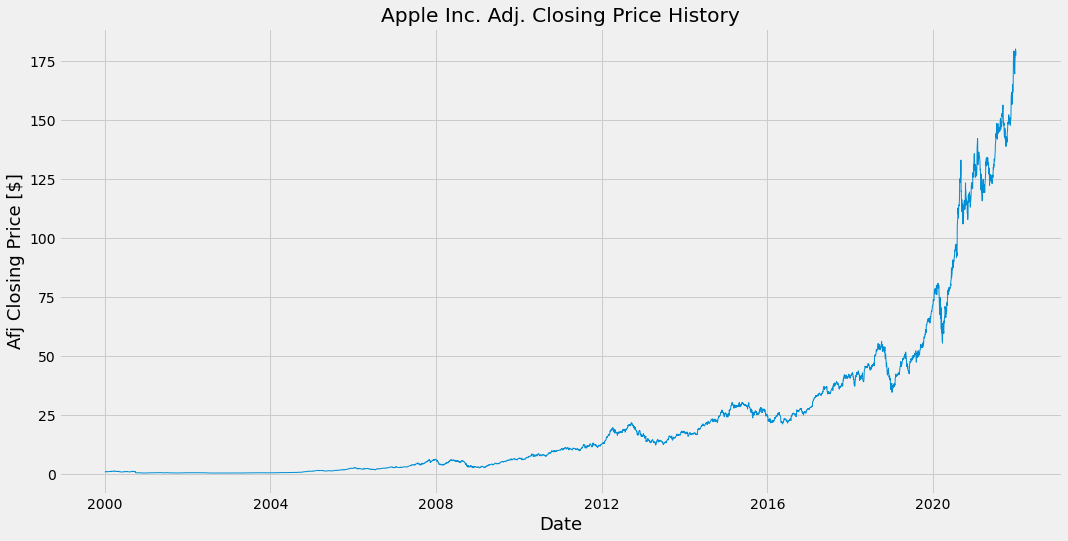

In [6]:
# visualize the closing price history
plt.figure(figsize=(16, 8))
plt.title("Apple Inc. Adj. Closing Price History")
plt.plot(df["Adj Close"], lw=1)  # lw = line width
plt.xlabel("Date", fontsize=18)
plt.ylabel("Afj Closing Price [$]", fontsize=18)
plt.show()

# Preprocess Data

## Find Local Extrema

In [7]:
extrema_constant = 4
df['Buy'] = df.iloc[argrelextrema(df["Adj Close"].values, np.less_equal,
                    order=extrema_constant)[0]]["Adj Close"]
df['Sell'] = df.iloc[argrelextrema(df["Adj Close"].values, np.greater_equal,
                    order=extrema_constant)[0]]["Adj Close"]

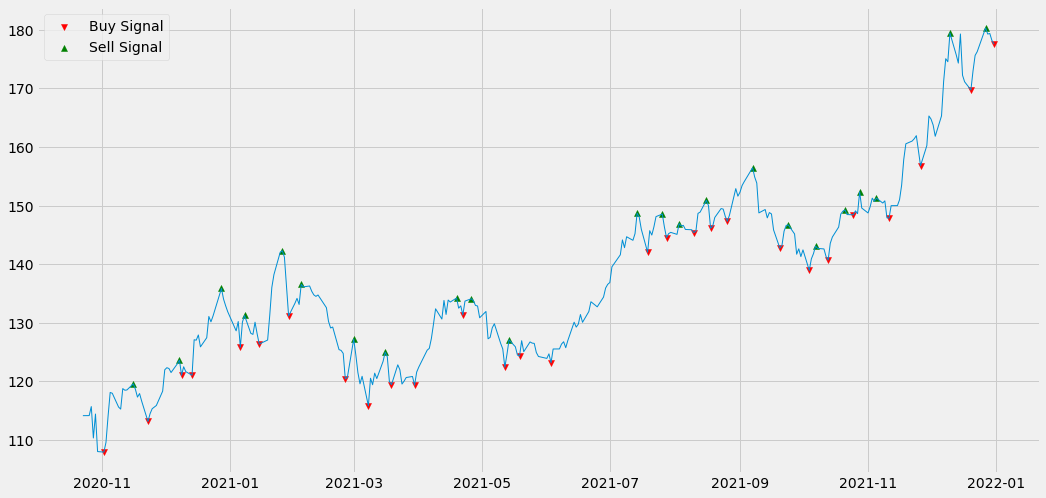

In [8]:
# Plot data
plt.figure(figsize=(16, 8))
plt.plot(df.index[-300:], df["Adj Close"][df.index[-300:]], lw=1)
plt.scatter(df.index[-300:], df['Buy'][df.index[-300:]], c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[-300:], df['Sell'][df.index[-300:]], c='g', marker="^", label="Sell Signal")
plt.legend()
plt.show()

## Delete all Buy_Sell_Signals that follows one of its own --> make signals alternating

In [9]:
# Create Column with Buy and Sell Signals
df["Buy_and_Sell"] = np.nan
for index in df.index:
    if str(df["Buy"][index]) != "nan":
        df["Buy_and_Sell"][index] = df["Buy"][index]
    if str(df["Sell"][index]) != "nan":
        df["Buy_and_Sell"][index] = df["Sell"][index]

# Delete not wanted signals
# --> leave lowest of repeated buy- and highest of repated sell-signals
flag_buy_last = False
flag_sell_last = False
df_reverse = df.iloc[::-1]  # df with rows in reversed order
df["Buy_Adj"] = df["Buy"]
df["Sell_Adj"] = df["Sell"]        

for index in df.index:
    if df["Buy_Adj"][index] == df["Buy_and_Sell"][index]\
    and str(df["Buy_Adj"][index]) != "nan":
        if flag_buy_last == True:
            # get last buy_signal that is not nan
            for index_last in df_reverse.index[df_reverse.index.get_loc(index) + 1:]:
                # df_reverse returns df with reversed indices -->[start:stop:steps]
                # df.index.get_loc(index) gets number of index
                if str(df["Buy_Adj"][index_last]) != "nan":
                    # delete smaller signal value (current or previous)
                    if df["Buy_Adj"][index] < df["Buy_Adj"][index_last]:
                        df["Buy_Adj"][index_last] = np.nan
                    elif df["Buy_Adj"][index] > df["Buy_Adj"][index_last]:
                        df["Buy_Adj"][index] = np.nan
                    elif df["Buy_Adj"][index] == df["Buy_Adj"][index_last]:
                        df["Buy_Adj"][index_last] = np.nan
                    break
        flag_buy_last = True
        flag_sell_last = False
    elif df["Sell_Adj"][index] == df["Buy_and_Sell"][index]\
    and str(df["Sell_Adj"][index]) != "nan":
        if flag_sell_last == True:
            # get last sell_signal that is not nan
            for index_last in df_reverse.index[df_reverse.index.get_loc(index) + 1:]:
                if str(df["Sell_Adj"][index_last]) != "nan":
                    # delete smaller signal value (current or previous)
                    if df["Sell_Adj"][index] > df["Sell_Adj"][index_last]:
                        df["Sell_Adj"][index_last] = np.nan
                    elif df["Sell_Adj"][index] < df["Sell_Adj"][index_last]:
                        df["Sell_Adj"][index] = np.nan
                    elif df["Sell_Adj"][index] == df["Sell_Adj"][index_last]:
                        df["Sell_Adj"][index] = np.nan
                    break
        flag_sell_last = True
        flag_buy_last = False


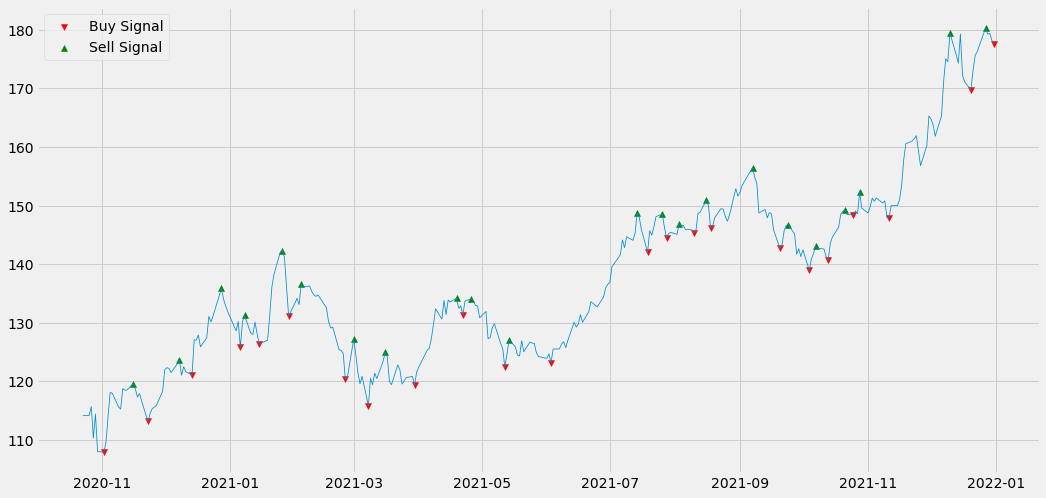

In [10]:
# Plot data
plt.figure(figsize=(16, 8))
plt.plot(df.index[-300:], df["Adj Close"][df.index[-300:]], lw=0.8)
plt.scatter(df.index[-300:], df['Buy_Adj'][df.index[-300:]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[-300:], df['Sell_Adj'][df.index[-300:]],
            c='g', marker="^", label="Sell Signal")
plt.legend()
plt.show()

## Calculate Income by this Method

In [11]:
buy_sum_adj = df["Buy_Adj"].fillna(0).values.sum()
sell_sum_adj = df["Sell_Adj"].fillna(0).values.sum()

# check if last transaction was buy
# if yes, correct it in income sum
for index in df.iloc[::-1].index:
    if str(df["Buy_and_Sell"][index]) != "nan":
        if df["Buy_and_Sell"][index] == df["Buy_Adj"][index]:
            last_buy_costs =  float(df["Buy_Adj"][index])
        elif df["Buy_and_Sell"][index] == df["Sell_Adj"][index]:
            last_buy_costs =  0.0
        break

income_adj = sell_sum_adj - buy_sum_adj + last_buy_costs
print(f"buy_sum_adj: {buy_sum_adj}\nsell_sum_adj: {sell_sum_adj}\nincome_adj: {income_adj}")

buy_sum_adj: 7637.9564326405525
sell_sum_adj: 8131.251591935754
income_adj: 670.86516661942


## Drop unimportant Columns

In [12]:
df = df.drop(
    ['High', 'Low', 'Open', 'Close', 'Volume', 'Buy', 'Sell', 'Buy_and_Sell'],
    axis=1
)
df

,Adj Close,Buy_Adj,Sell_Adj
Date,,,
2000-01-03,0.856887,NaN,0.856887
2000-01-04,0.784642,NaN,NaN
2000-01-05,0.796124,NaN,NaN
2000-01-06,0.727229,NaN,NaN
2000-01-07,0.761677,NaN,NaN
...,...,...,...
2021-12-27,180.330002,NaN,180.330002
2021-12-28,179.289993,NaN,NaN
2021-12-29,179.380005,NaN,NaN


In [13]:
# Rename columns because in following script "Buy" and "Sell" was used instead of 
# "Buy_Adj" and "Sell_Adj"
df = df.rename({'Buy_Adj': 'Buy', 'Sell_Adj': 'Sell'}, axis=1)
df

,Adj Close,Buy,Sell
Date,,,
2000-01-03,0.856887,NaN,0.856887
2000-01-04,0.784642,NaN,NaN
2000-01-05,0.796124,NaN,NaN
2000-01-06,0.727229,NaN,NaN
2000-01-07,0.761677,NaN,NaN
...,...,...,...
2021-12-27,180.330002,NaN,180.330002
2021-12-28,179.289993,NaN,NaN
2021-12-29,179.380005,NaN,NaN


## Create Recommendation Values from 0.99 to 0.01

### Variant with scaled Data (0.99 and 0.01 respectivliy at Buy and Sell Signals) 

In [14]:
df["Rec(Buy)"] = np.nan
df["Rec(Sell)"] = np.nan
sell_to_sell_period_list = []
buy_to_buy_period_list = []

i = 0
for index in df.index:
#1 FILL Rec(Buy) VALUES
    # check for sell_signal
    if str(df["Sell"][index]) != "nan":
        # clear sell_to_sell_period_list for new period
        sell_to_sell_period_list = []
        # find out the next sell_signal
        for sub_index in df.index[i + 1:]:
            if str(df["Sell"][sub_index]) != "nan":
                next_sell_signal = df["Sell"][sub_index]
                break
        # fill sell_to_sell_period_list
        for sub_index in df.index[i + 1:]:
            sell_to_sell_period_list.append(next_sell_signal - df["Adj Close"][sub_index])
            # scale the filled sell_to_sell_period_list min = 0.01 & max = 0.99
            # if next sell_signal is reached
            if str(df["Sell"][sub_index]) != "nan":
                # transform sell_to_sell_period_list to sell_to_sell_period_np for scaling
                # and reshape it to 2 diemensions for scaling
                # reshape(-1, 1) if 1 feature; reshape(1, -1) if 1 sample
                sell_to_sell_period_np = np.array(sell_to_sell_period_list)\
                                            .reshape(-1, 1)
                print(sell_to_sell_period_np)
                scaler = MinMaxScaler(feature_range=(0.01, 0.99))
                scaled_sell_to_sell_period_np = scaler.fit_transform(
                                                    sell_to_sell_period_np)
                break
        # set Rec(Buy) values to respective once out of scaled_sell_to_sell_period_list
        j = 0
        for sub_index in df.index[i + 1:]:
            if j == scaled_sell_to_sell_period_np.shape[0]:
                break
            print(scaled_sell_to_sell_period_np[j])
            df["Rec(Buy)"][sub_index] = scaled_sell_to_sell_period_np[j]
            j += 1
    
#2 FILL Rec(Sell) VALUES
    if str(df["Buy"][index]) != "nan":
        # clear buy_to_buy_period_list for new period
        buy_to_buy_period_list = []
        # find out the next buy_signal
        for sub_index in df.index[i + 1:]:
            if str(df["Buy"][sub_index]) != "nan":
                next_buy_signal = df["Buy"][sub_index]
                break
        # fill buy_to_buy_period_list
        for sub_index in df.index[i + 1:]:
            buy_to_buy_period_list.append(df["Adj Close"][sub_index] - next_buy_signal)
            # scale the filled buy_to_buy_period_list min = 0.01 & max = 0.99
            # if next buy_signal is reached
            if str(df["Buy"][sub_index]) != "nan":
                # transform buy_to_buy_period_list to buy_to_buy_period_np for scaling
                # and reshape it to 2 diemensions for scaling
                # reshape(-1, 1) if 1 feature; reshape(1, -1) if 1 sample
                buy_to_buy_period_np = np.array(buy_to_buy_period_list)\
                                            .reshape(-1, 1)
                print(buy_to_buy_period_np)
                scaler = MinMaxScaler(feature_range=(0.01, 0.99))
                scaled_buy_to_buy_period_np = scaler.fit_transform(
                                                    buy_to_buy_period_np)
                break
        # set Rec(Sell) values to respective ones out of scaled_buy_to_buy_period_list
        j = 0
        for sub_index in df.index[i + 1:]:
            if j == scaled_buy_to_buy_period_np.shape[0]:
                break
            print(scaled_buy_to_buy_period_np[j])
            df["Rec(Sell)"][sub_index] = scaled_buy_to_buy_period_np[j]
            j += 1
    
    i += 1

[[0.08420551]
 [0.07272363]
 [0.14161891]
 [0.1071707 ]
 [0.12056726]
 [0.15884244]
 [0.20142341]
 [0.12822247]
 [0.0999946 ]
 [0.07320195]
 [0.05310708]
 [0.        ]]
[0.4196912]
[0.36382757]
[0.69902881]
[0.53142543]
[0.5966047]
[0.78282774]
[0.99]
[0.63385012]
[0.49651102]
[0.36615481]
[0.26838577]
[0.01]
[[-0.01578838]
 [ 0.01243949]
 [ 0.03923213]
 [ 0.05932701]
 [ 0.11243409]
 [ 0.09568882]
 [ 0.05693507]
 [ 0.10286486]
 [ 0.08707654]
 [ 0.08564132]
 [ 0.02153003]
 [ 0.03779691]
 [ 0.01100427]
 [ 0.        ]]
[0.01]
[0.22574463]
[0.43051992]
[0.58410435]
[0.99]
[0.86201647]
[0.56582287]
[0.91686271]
[0.79619314]
[0.7852238]
[0.29522334]
[0.41955058]
[0.21477529]
[0.13067003]
[[0.05884773]
 [0.09760147]
 [0.05167168]
 [0.06746   ]
 [0.06889522]
 [0.13300651]
 [0.11673963]
 [0.14353228]
 [0.15453655]
 [0.12008852]
 [0.08420515]
 [0.03779691]
 [0.03157663]
 [0.04880112]
 [0.04210246]
 [0.07846421]
 [0.02440047]
 [0.        ]]
[0.38318533]
[0.62894385]
[0.33767816]
[0.43780043]
[0.4

[0.55420562]
[0.06952088]
[0.49468686]
[0.55420562]
[0.6477426]
[0.61373286]
[0.76891259]
[0.99]
[0.25234104]
[0.35012388]
[0.19919371]
[[0.62819257]
 [0.61718896]
 [0.6341733 ]
 [0.56743094]
 [0.49853566]
 [0.5186297 ]
 [0.48705295]
 [0.44877759]
 [0.5186297 ]
 [0.09377432]
 [0.07080993]
 [0.04114667]
 [0.06124076]
 [0.03731856]
 [0.03923225]
 [0.03253445]
 [0.01913816]
 [0.        ]]
[0.98075786]
[0.96375377]
[0.99]
[0.88686177]
[0.78039659]
[0.81144828]
[0.76265213]
[0.70350449]
[0.81144828]
[0.15491123]
[0.11942392]
[0.07358472]
[0.10463651]
[0.06766907]
[0.07062634]
[0.0602761]
[0.03957456]
[0.01]
[[-0.53011239]
 [-0.46121711]
 [-0.48131114]
 [-0.44973439]
 [-0.41145903]
 [-0.48131114]
 [-0.05645576]
 [-0.03349137]
 [-0.00382811]
 [-0.0239222 ]
 [ 0.        ]
 [-0.0019137 ]
 [ 0.00478411]
 [ 0.0181804 ]
 [ 0.03731856]
 [ 0.03157666]
 [ 0.        ]]
[0.01]
[0.12898783]
[0.09428377]
[0.14881942]
[0.21492413]
[0.09428377]
[0.82804402]
[0.86770541]
[0.91893632]
[0.88423216]
[0.9255477

[0.27696654]
[0.01]
[0.27696654]
[0.40875461]
[0.60814343]
[0.93931901]
[0.99]
[0.84130927]
[0.87847669]
[0.56758825]
[[0.05373883]
 [0.05205497]
 [0.0661397 ]
 [0.0577195 ]
 [0.05741346]
 [0.05787215]
 [0.05695397]
 [0.0528197 ]
 [0.05236095]
 [0.0456247 ]
 [0.0258745 ]
 [0.        ]]
[0.80625486]
[0.78130488]
[0.99]
[0.86523688]
[0.86070225]
[0.86749868]
[0.85389389]
[0.79263594]
[0.78583863]
[0.68602681]
[0.39338557]
[0.01]
[[-0.02893609]
 [-0.02863005]
 [-0.02908874]
 [-0.02817056]
 [-0.02403629]
 [-0.02357754]
 [-0.01684129]
 [ 0.00290892]
 [ 0.02878341]
 [ 0.02618042]
 [ 0.01178876]
 [ 0.01530987]
 [ 0.01102307]
 [ 0.01423824]
 [ 0.        ]]
[0.01258491]
[0.01776736]
[0.01]
[0.02554835]
[0.09555754]
[0.10332591]
[0.21739674]
[0.55184439]
[0.99]
[0.9459212]
[0.70221454]
[0.76184068]
[0.68924859]
[0.74369379]
[0.50258517]
[[0.00107169]
 [0.01546335]
 [0.01194224]
 [0.01622903]
 [0.01301387]
 [0.02725211]
 [0.0220463 ]
 [0.00244939]
 [0.00658369]
 [0.00903317]
 [0.        ]]
[0.048

[[0.05327836]
 [0.04914489]
 [0.05373794]
 [0.04746118]
 [0.036744  ]
 [0.0171473 ]
 [0.02495536]
 [0.        ]]
[0.98161877]
[0.90623825]
[0.99]
[0.87553299]
[0.68008746]
[0.32270936]
[0.46510222]
[0.01]
[[-0.01209489]
 [-0.0013777 ]
 [ 0.01821899]
 [ 0.01041093]
 [ 0.0353663 ]
 [ 0.01638252]
 [ 0.        ]]
[0.01]
[0.23129326]
[0.63593472]
[0.47471037]
[0.99]
[0.59801428]
[0.25974067]
[[0.01592216]
 [0.03230467]
 [0.03016126]
 [0.00398073]
 [0.        ]]
[0.49301727]
[0.99]
[0.92497707]
[0.13075997]
[0.01]
[[0.02128068]
 [0.04746121]
 [0.05144194]
 [0.02464926]
 [0.01178873]
 [0.02342409]
 [0.01515731]
 [0.01041102]
 [0.0061242 ]
 [0.        ]]
[0.41540974]
[0.91416476]
[0.99]
[0.47958335]
[0.23458235]
[0.45624305]
[0.29875596]
[0.2083363]
[0.12666968]
[0.01]
[[0.00153124]
 [0.01439178]
 [0.00275642]
 [0.01102319]
 [0.01576948]
 [0.02005631]
 [0.02618051]
 [0.02097544]
 [0.01745349]
 [0.0165351 ]
 [0.02449661]
 [0.02128142]
 [0.02296537]
 [0.02403709]
 [0.01408568]
 [0.0113301 ]
 [0.

[0.01]
[[0.04072484]
 [0.04761465]
 [0.04409344]
 [0.04072484]
 [0.03858148]
 [0.03582592]
 [0.03873487]
 [0.02755836]
 [0.02464923]
 [0.02725226]
 [0.01898468]
 [0.0176069 ]
 [0.01316655]
 [0.0050526 ]
 [0.004899  ]
 [0.        ]]
[0.84819471]
[0.99]
[0.91752693]
[0.84819471]
[0.80408012]
[0.74736561]
[0.80723723]
[0.57720337]
[0.51732807]
[0.57090326]
[0.40074071]
[0.37238346]
[0.28099257]
[0.11399204]
[0.11083063]
[0.01]
[[-0.01255438]
 [-0.00918578]
 [-0.00704241]
 [-0.00428686]
 [-0.0071958 ]
 [ 0.00398071]
 [ 0.00688984]
 [ 0.00428681]
 [ 0.01255439]
 [ 0.01393217]
 [ 0.01837252]
 [ 0.02648647]
 [ 0.02664007]
 [ 0.03153907]
 [ 0.01286052]
 [ 0.01041095]
 [ 0.        ]]
[0.01]
[0.08486893]
[0.13250642]
[0.19375002]
[0.12909719]
[0.37750103]
[0.44215784]
[0.38430426]
[0.56805561]
[0.59867741]
[0.69736657]
[0.87770339]
[0.88111726]
[0.99]
[0.57485949]
[0.52041647]
[0.28902764]
[[0.00459298]
 [0.00704256]
 [0.01745351]
 [0.01010425]
 [0.01086974]
 [0.        ]]
[0.26789231]
[0.405433

[0.99]
[0.87490946]
[0.86444058]
[0.80167003]
[0.85049315]
[0.5924247]
[0.40757327]
[0.58543231]
[0.69355151]
[0.59939875]
[0.58195853]
[0.68308534]
[0.5924247]
[0.23320838]
[0.24715377]
[0.33433384]
[0.26807049]
[0.27156736]
[0.36921768]
[0.01]
[[-0.01867867]
 [-0.01821908]
 [-0.01546347]
 [-0.01760679]
 [-0.00627765]
 [ 0.00183728]
 [-0.00597069]
 [-0.01071709]
 [-0.00658381]
 [-0.00581819]
 [-0.01025763]
 [-0.00627765]
 [ 0.00949186]
 [ 0.00887966]
 [ 0.00505248]
 [ 0.00796142]
 [ 0.00780791]
 [ 0.00352108]
 [ 0.01929066]
 [ 0.01086965]
 [ 0.00673625]
 [ 0.        ]]
[0.01]
[0.02186194]
[0.09298515]
[0.03766531]
[0.33007405]
[0.53952302]
[0.33799688]
[0.21549063]
[0.32217198]
[0.34193292]
[0.2273495]
[0.33007405]
[0.73709005]
[0.721289]
[0.62250817]
[0.69758895]
[0.69362676]
[0.58298246]
[0.99]
[0.77265127]
[0.66596684]
[0.49210216]
[[0.00336862]
 [0.00750202]
 [0.01423827]
 [0.00198999]
 [0.00734857]
 [0.        ]]
[0.24185712]
[0.52635346]
[0.99]
[0.14696825]
[0.51579156]
[0.01]
[

[0.71552732]
[0.61973489]
[0.65473707]
[0.65473707]
[0.54973125]
[[0.01791295]
 [0.01163539]
 [0.02863002]
 [0.03827542]
 [0.03260997]
 [0.04057145]
 [0.03766236]
 [0.03766236]
 [0.04638958]
 [0.0431743 ]
 [0.02219981]
 [0.01959687]
 [0.00627676]
 [0.00612429]
 [0.01959687]
 [0.01852518]
 [0.01255444]
 [0.        ]]
[0.38841893]
[0.25580272]
[0.61482156]
[0.81858487]
[0.69889975]
[0.86708951]
[0.80563363]
[0.80563363]
[0.99]
[0.92207575]
[0.47898061]
[0.42399248]
[0.1425992]
[0.13937824]
[0.42399248]
[0.40135253]
[0.27521793]
[0.01]
[[-0.01745331]
 [ 0.00352117]
 [ 0.00612411]
 [ 0.01944423]
 [ 0.0195967 ]
 [ 0.00612411]
 [ 0.0071958 ]
 [ 0.01316655]
 [ 0.02572098]
 [ 0.01821896]
 [ 0.01025847]
 [ 0.0136261 ]
 [ 0.02143413]
 [ 0.00444028]
 [ 0.        ]]
[0.01]
[0.48609339]
[0.5451766]
[0.84752585]
[0.85098669]
[0.5451766]
[0.5695026]
[0.70503072]
[0.99]
[0.81971398]
[0.63902109]
[0.71546195]
[0.89269399]
[0.50695584]
[0.40616735]
[[0.02250594]
 [0.03046644]
 [0.0270988 ]
 [0.01929078]

[0.17467799]
[0.1142202]
[0.01]
[[-0.21893525]
 [-0.13886309]
 [-0.13090187]
 [-0.09645355]
 [-0.10150611]
 [-0.10074043]
 [-0.09354544]
 [-0.1016596 ]
 [-0.09951627]
 [-0.09308589]
 [-0.0574137 ]
 [-0.02847737]
 [-0.02526212]
 [-0.02449656]
 [-0.00842106]
 [ 0.01929069]
 [ 0.0061233 ]
 [ 0.01025742]
 [ 0.00505173]
 [ 0.        ]]
[0.01]
[0.33939621]
[0.37214659]
[0.51385811]
[0.49307315]
[0.49622297]
[0.52582132]
[0.49244177]
[0.50125885]
[0.5277118]
[0.67445797]
[0.79349455]
[0.80672127]
[0.8098706]
[0.87600102]
[0.99]
[0.93583279]
[0.95283949]
[0.93142462]
[0.9106431]
[[0.01607549]
 [0.01194137]
 [0.01714706]
 [0.0221988 ]
 [0.01148182]
 [0.00306171]
 [0.        ]]
[0.71967731]
[0.53717029]
[0.76698352]
[0.99]
[0.51688267]
[0.14516398]
[0.01]
[[-0.00229615]
 [ 0.00612396]
 [ 0.00918567]
 [ 0.00520599]
 [ 0.00061196]
 [ 0.        ]]
[0.01]
[0.72867582]
[0.99]
[0.65032487]
[0.25821396]
[0.20598169]
[[0.20209295]
 [0.20668697]
 [0.20729893]
 [0.19979715]
 [0.20316476]
 [0.10854858]
 [0

[0.89624028]
[0.8692692]
[0.99]
[0.93348665]
[0.97330621]
[0.78321207]
[0.85899441]
[0.82816603]
[0.7485369]
[0.76780288]
[0.7498205]
[0.73568941]
[0.42743416]
[0.32468124]
[0.33238584]
[0.11403902]
[0.05752616]
[0.10119603]
[0.01]
[[-0.17882109]
 [-0.18831408]
 [-0.1429956 ]
 [-0.16106212]
 [-0.15371263]
 [-0.13472903]
 [-0.13932204]
 [-0.13503504]
 [-0.13166618]
 [-0.05817807]
 [-0.03368175]
 [-0.03551853]
 [ 0.0165354 ]
 [ 0.03000808]
 [ 0.01959717]
 [ 0.04133832]
 [ 0.03551984]
 [ 0.03000808]
 [ 0.04103136]
 [ 0.03521383]
 [ 0.        ]
 [ 0.00306284]
 [ 0.0165354 ]
 [ 0.01745331]
 [ 0.00183737]
 [ 0.01041126]
 [ 0.        ]]
[0.05050963]
[0.01]
[0.20338842]
[0.12629279]
[0.15765541]
[0.2386645]
[0.21906464]
[0.23735865]
[0.25173463]
[0.56533184]
[0.66986543]
[0.66202732]
[0.88415802]
[0.94165023]
[0.89722358]
[0.99]
[0.96517067]
[0.94165023]
[0.98869009]
[0.96386482]
[0.81359619]
[0.82666633]
[0.88415802]
[0.88807504]
[0.82143685]
[0.85802437]
[0.81359619]
[[0.11850011]
 [0.124011

[0.99]
[0.86593588]
[0.64739992]
[0.68723633]
[0.61097645]
[0.36284688]
[0.34690948]
[0.17503892]
[0.15227918]
[0.10105669]
[0.01]
[[0.15340662]
 [0.21219718]
 [0.20148039]
 [0.22199583]
 [0.28874767]
 [0.29303515]
 [0.33927178]
 [0.34539461]
 [0.35917449]
 [0.38367057]
 [0.27282548]
 [0.25996566]
 [0.26088417]
 [0.26302648]
 [0.30834436]
 [0.12339902]
 [0.        ]]
[0.40184264]
[0.55200989]
[0.52463625]
[0.57703832]
[0.74754084]
[0.75849225]
[0.87659331]
[0.89223269]
[0.92743029]
[0.99]
[0.7068712]
[0.67402369]
[0.67636981]
[0.68184185]
[0.79759619]
[0.32519498]
[0.01]
[[-0.07593739]
 [-0.06307757]
 [-0.06399608]
 [-0.06613839]
 [-0.11145627]
 [ 0.07348907]
 [ 0.19688809]
 [ 0.15248883]
 [ 0.1181947 ]
 [ 0.09737217]
 [ 0.05817926]
 [ 0.05083096]
 [ 0.        ]]
[0.12288842]
[0.16376033]
[0.16084107]
[0.15403224]
[0.01]
[0.59780526]
[0.99]
[0.8488874]
[0.73989158]
[0.67371208]
[0.54914663]
[0.52579179]
[0.36423754]
[[0.06430268]
 [0.09859681]
 [0.11941934]
 [0.15861225]
 [0.16596055]


[[0.34907007]
 [0.34876418]
 [0.32855654]
 [0.38734651]
 [0.39285827]
 [0.41398573]
 [0.37050486]
 [0.34600949]
 [0.28660583]
 [0.25935388]
 [0.26609015]
 [0.22842646]
 [0.2085247 ]
 [0.2376132 ]
 [0.18984652]
 [0.18249798]
 [0.16351342]
 [0.09829116]
 [0.0459311 ]
 [0.00551248]
 [0.06950998]
 [0.        ]]
[0.83632962]
[0.83560551]
[0.78776934]
[0.9269388]
[0.93998641]
[0.99]
[0.88707071]
[0.82908452]
[0.68846232]
[0.62395063]
[0.63989696]
[0.55073827]
[0.50362622]
[0.57248542]
[0.45941063]
[0.44201494]
[0.3970741]
[0.24267791]
[0.11872954]
[0.02304931]
[0.17454621]
[0.01]
[[-0.0355196 ]
 [-0.01102424]
 [ 0.04837942]
 [ 0.07563138]
 [ 0.0688951 ]
 [ 0.1065588 ]
 [ 0.12646055]
 [ 0.09737206]
 [ 0.14513874]
 [ 0.15248728]
 [ 0.17147183]
 [ 0.2366941 ]
 [ 0.28905416]
 [ 0.32947278]
 [ 0.26547527]
 [ 0.33498526]
 [ 0.3346777 ]
 [ 0.33039069]
 [ 0.3199811 ]
 [ 0.31385636]
 [ 0.31844974]
 [ 0.27435637]
 [ 0.18892527]
 [ 0.22628284]
 [ 0.24128628]
 [ 0.16136861]
 [ 0.25047183]
 [ 0.2351625 ]

[0.61813931]
[0.99]
[0.82860363]
[0.60265194]
[0.01]
[[-0.02755833]
 [ 0.02602625]
 [ 0.166574  ]
 [ 0.12278771]
 [ 0.05817842]
 [ 0.13013577]
 [ 0.10257816]
 [ 0.08236933]
 [ 0.        ]]
[0.01]
[0.28050046]
[0.99]
[0.76896231]
[0.44280796]
[0.80605608]
[0.66694241]
[0.56492613]
[0.14911727]
[[0.27833676]
 [0.34294605]
 [0.2709887 ]
 [0.29854631]
 [0.31875515]
 [0.40112448]
 [0.33253503]
 [0.37325954]
 [0.32794237]
 [0.35182691]
 [0.17086148]
 [0.        ]]
[0.69001342]
[0.84786244]
[0.67206114]
[0.73938802]
[0.78876087]
[0.99]
[0.82242693]
[0.92192229]
[0.81120646]
[0.86955953]
[0.42743714]
[0.01]
[[-0.39806342]
 [-0.43878794]
 [-0.39347076]
 [-0.4173553 ]
 [-0.23638988]
 [-0.06552839]
 [-0.07930803]
 [-0.13962936]
 [-0.07777643]
 [-0.07655144]
 [-0.0251112 ]
 [ 0.08696175]
 [ 0.09828806]
 [ 0.12309361]
 [ 0.0989027 ]
 [ 0.15646887]
 [ 0.27129364]
 [ 0.26976299]
 [ 0.        ]]
[0.06620485]
[0.01]
[0.07254328]
[0.03957968]
[0.28933424]
[0.52514413]
[0.50612653]
[0.42287566]
[0.508240

[0.99]
[0.87825612]
[0.73250639]
[0.57356686]
[0.06274675]
[0.01]
[[-0.13166857]
 [-0.0673666 ]
 [ 0.00275445]
 [ 0.22811842]
 [ 0.25138927]
 [ 0.12156034]
 [ 0.        ]]
[0.01]
[0.17450761]
[0.35390253]
[0.93046479]
[0.99]
[0.6578508]
[0.34685565]
[[0.19382644]
 [0.31538677]
 [0.17484212]
 [0.31385732]
 [0.25445414]
 [0.16779852]
 [0.09277964]
 [0.14299703]
 [0.07318282]
 [0.00949287]
 [0.01806641]
 [0.        ]]
[0.61227608]
[0.99]
[0.55328619]
[0.98524753]
[0.80066427]
[0.53139964]
[0.29829378]
[0.45433406]
[0.23740067]
[0.03949717]
[0.06613767]
[0.01]
[[0.15463185]
 [0.01561666]
 [0.07501984]
 [0.16167545]
 [0.23669434]
 [0.18647695]
 [0.25629115]
 [0.3199811 ]
 [0.31140757]
 [0.32947397]
 [0.21280932]
 [0.        ]]
[0.46994291]
[0.05645078]
[0.23314187]
[0.49089366]
[0.7140327]
[0.56466417]
[0.77232221]
[0.96176403]
[0.93626259]
[0.99]
[0.6429882]
[0.01]
[[0.10012865]
 [0.31293797]
 [0.16320586]
 [0.06246495]
 [0.15095639]
 [0.14697623]
 [0.03796864]
 [0.07838655]
 [0.        ]]

[0.28724134]
[0.99]
[0.66733576]
[0.34728349]
[0.55299534]
[0.31856778]
[0.37286728]
[0.01]
[[0.21311617]
 [0.40081763]
 [0.28017354]
 [0.41765857]
 [0.38581347]
 [0.59862471]
 [0.43388677]
 [0.39224482]
 [0.44889045]
 [0.58025098]
 [0.34080243]
 [0.19872379]
 [0.        ]]
[0.35888945]
[0.66617285]
[0.46866812]
[0.69374291]
[0.64160976]
[0.99]
[0.72030986]
[0.65213841]
[0.74487217]
[0.95992063]
[0.56792282]
[0.3353279]
[0.01]
[[0.50155902]
 [0.54320097]
 [0.48655534]
 [0.35519481]
 [0.59464335]
 [0.73672199]
 [0.93544579]
 [0.8298068 ]
 [0.81051564]
 [0.93391538]
 [0.6984458 ]
 [0.56984186]
 [0.54350758]
 [0.47124457]
 [0.43725657]
 [0.29487181]
 [0.48839211]
 [0.29854679]
 [0.23424459]
 [0.28844094]
 [0.17759705]
 [0.        ]]
[0.5354477]
[0.57907301]
[0.51972941]
[0.38211233]
[0.63296554]
[0.78181122]
[0.99]
[0.87932956]
[0.85911958]
[0.9883967]
[0.74171197]
[0.60698278]
[0.57939422]
[0.50368941]
[0.46808261]
[0.31891621]
[0.52165367]
[0.32276623]
[0.25540139]
[0.31217906]
[0.19605

[[-0.03123426]
 [ 0.00336647]
 [ 0.079     ]
 [ 0.08818579]
 [ 0.17943287]
 [ 0.20638037]
 [ 0.19841766]
 [ 0.22199631]
 [ 0.21280909]
 [ 0.10257721]
 [ 0.16718531]
 [ 0.27006912]
 [ 0.20239735]
 [ 0.09094095]
 [ 0.01194048]
 [ 0.02633286]
 [ 0.01224661]
 [ 0.        ]]
[0.01]
[0.12254012]
[0.36854086]
[0.39841797]
[0.69520236]
[0.78285006]
[0.75695108]
[0.83364146]
[0.80375969]
[0.44522659]
[0.65536672]
[0.99]
[0.76989514]
[0.40737925]
[0.15042739]
[0.19723911]
[0.15142309]
[0.11159056]
[[0.02511024]
 [0.13656664]
 [0.21556711]
 [0.20117474]
 [0.21526098]
 [0.22750759]
 [0.14146709]
 [0.09829235]
 [0.        ]]
[0.1181636]
[0.59826743]
[0.93856581]
[0.87656995]
[0.93724714]
[0.99]
[0.61937638]
[0.43339908]
[0.01]
[[0.86961222]
 [0.91278696]
 [1.01107931]
 [0.9553504 ]
 [0.98168325]
 [0.9155426 ]
 [0.79857445]
 [0.80071878]
 [0.65955877]
 [0.6399622 ]
 [0.51043892]
 [0.47491789]
 [0.51778936]
 [0.35764313]
 [0.32457542]
 [0.25812817]
 [0.25475979]
 [0.25782108]
 [0.25690365]
 [0.172390

[0.15150779]
[0.01]
[0.22859967]
[0.11561117]
[0.4904996]
[0.67108122]
[0.99]
[0.90024201]
[0.94037163]
[0.80730517]
[0.67530271]
[0.3204758]
[[0.73641348]
 [0.7247777 ]
 [0.76336098]
 [0.80163574]
 [0.90451956]
 [0.79428577]
 [0.75325441]
 [0.67303181]
 [0.53921938]
 [0.5435071 ]
 [0.5288105 ]
 [0.48655367]
 [0.23424339]
 [0.23026419]
 [0.10961962]
 [0.05389166]
 [0.03368282]
 [0.        ]]
[0.80786579]
[0.79525902]
[0.837062]
[0.87853072]
[0.99]
[0.87056742]
[0.82611207]
[0.73919504]
[0.59421621]
[0.59886174]
[0.58293873]
[0.53715565]
[0.26379056]
[0.2594793]
[0.12876717]
[0.06838882]
[0.04649359]
[0.01]
[[-0.66109037]
 [-0.62005901]
 [-0.53983641]
 [-0.40602398]
 [-0.4103117 ]
 [-0.3956151 ]
 [-0.35335827]
 [-0.10104799]
 [-0.09706879]
 [ 0.02357578]
 [ 0.07930374]
 [ 0.09951258]
 [ 0.1331954 ]
 [ 0.04868555]
 [ 0.06736231]
 [ 0.05725861]
 [ 0.07348633]
 [ 0.        ]]
[0.01]
[0.06062502]
[0.1596047]
[0.3247042]
[0.31941395]
[0.33754681]
[0.38968383]
[0.70098749]
[0.70589709]
[0.854

[0.67827114]
[0.78533432]
[0.77263529]
[0.86276772]
[0.89339243]
[0.99]
[0.73354714]
[0.72731937]
[0.7265726]
[0.60581623]
[0.57369875]
[0.49452133]
[0.45468408]
[0.40065348]
[0.09116727]
[0.01]
[[-0.36866951]
 [-0.36101055]
 [-0.36009216]
 [-0.21158504]
 [-0.17208672]
 [-0.07471371]
 [-0.02572155]
 [ 0.04072571]
 [ 0.42133427]
 [ 0.5211544 ]
 [ 0.26057816]
 [ 0.29242134]
 [ 0.26149559]
 [ 0.19872665]
 [ 0.24067116]
 [ 0.21648502]
 [ 0.20974827]
 [ 0.13044071]
 [ 0.        ]]
[0.01]
[0.01843513]
[0.01944659]
[0.18300364]
[0.22650479]
[0.33374572]
[0.38770282]
[0.46088394]
[0.88006394]
[0.99]
[0.70301657]
[0.73808679]
[0.70402697]
[0.63489694]
[0.68109216]
[0.65445497]
[0.6470355]
[0.5596908]
[0.41603103]
[[0.27956104]
 [0.24771786]
 [0.27864361]
 [0.34141254]
 [0.29946804]
 [0.32365417]
 [0.33039093]
 [0.40969849]
 [0.5401392 ]
 [0.44215584]
 [0.28354168]
 [0.17821026]
 [0.01071548]
 [0.04562569]
 [0.        ]]
[0.51722077]
[0.45944618]
[0.51555623]
[0.62944087]
[0.55333898]
[0.5972210

[[0.38611794]
 [0.41123104]
 [0.47889996]
 [0.33835411]
 [0.39285564]
 [0.31906605]
 [0.        ]]
[0.80013492]
[0.85152528]
[0.99]
[0.70239311]
[0.81392267]
[0.66292286]
[0.01]
[[0.65710735]
 [0.60260582]
 [0.67639542]
 [0.99546146]
 [0.92442036]
 [0.94248867]
 [0.86103916]
 [0.69569111]
 [0.51196957]
 [0.51809406]
 [0.49512482]
 [0.32395935]
 [0.34539223]
 [0.5242157 ]
 [0.34998703]
 [0.30130005]
 [0.15126324]
 [0.        ]]
[0.65690119]
[0.60324617]
[0.67588967]
[0.99]
[0.9200623]
[0.93784998]
[0.85766554]
[0.69488566]
[0.51401768]
[0.52004705]
[0.49743456]
[0.32892763]
[0.35002761]
[0.5260736]
[0.35455105]
[0.30662027]
[0.15891382]
[0.01]
[[1.77291012]
 [1.7548418 ]
 [1.83629131]
 [2.00163937]
 [2.18536091]
 [2.17923641]
 [2.20220566]
 [2.37337112]
 [2.35193825]
 [2.17311478]
 [2.34734344]
 [2.39603043]
 [2.54606724]
 [2.69733047]
 [2.39174461]
 [2.47411251]
 [2.21016502]
 [2.35959053]
 [2.18536091]
 [2.08676529]
 [2.1241188 ]
 [2.07421112]
 [1.8418026 ]
 [1.65287685]
 [1.58153057]

[0.1887989]
[0.19946924]
[0.17972077]
[0.14423265]
[0.12448308]
[0.06759553]
[0.0261535]
[0.01418764]
[0.01]
[[-4.56975937]
 [-4.53332233]
 [-4.11260033]
 [-4.09729099]
 [-4.0329895 ]
 [-3.88662338]
 [-3.78863716]
 [-3.90775204]
 [-3.83181477]
 [-3.83548737]
 [-3.64472198]
 [-3.57705307]
 [-3.43650627]
 [-3.30269623]
 [-3.32321358]
 [-3.27697754]
 [-3.29810333]
 [-3.33362198]
 [-3.38200092]
 [-3.23226929]
 [-3.09723186]
 [-3.13887882]
 [-3.36699867]
 [-3.14929008]
 [-3.36362934]
 [-2.55985069]
 [-2.62201023]
 [-2.54086781]
 [-2.36541462]
 [-2.25916386]
 [-2.26804161]
 [-2.30080223]
 [-2.16117573]
 [-2.02981281]
 [-1.88100147]
 [-1.64062977]
 [-1.13570309]
 [-1.12804985]
 [-0.84695339]
 [-0.63690376]
 [-0.99791718]
 [-0.85890007]
 [-0.86165524]
 [-0.47186089]
 [-0.52728462]
 [-0.42470741]
 [-0.24037552]
 [-0.13779259]
 [ 0.15769196]
 [ 0.3729496 ]
 [ 0.43510246]
 [ 0.45685387]
 [ 0.08880043]
 [ 0.        ]]
[0.01]
[0.01710385]
[0.09912877]
[0.10211351]
[0.11464988]
[0.14318575]
[0.16228

[0.65050841]
[0.76241541]
[0.61981208]
[0.52136795]
[0.93924114]
[0.99]
[0.77280469]
[0.46140151]
[0.26545481]
[0.06477692]
[0.01449543]
[0.01]
[[1.28203201]
 [1.68765259]
 [1.94288445]
 [2.20427895]
 [2.26977348]
 [2.27562904]
 [2.17106628]
 [2.21380997]
 [1.92782021]
 [1.39735603]
 [1.14026833]
 [1.63660431]
 [1.19931412]
 [0.96221924]
 [1.02126312]
 [1.3330822 ]
 [1.19008827]
 [0.75310516]
 [0.3096714 ]
 [0.23832512]
 [0.39392471]
 [0.        ]]
[0.56210728]
[0.73678785]
[0.84670349]
[0.95927307]
[0.9874783]
[0.99]
[0.94497003]
[0.96337761]
[0.84021607]
[0.61177159]
[0.50105673]
[0.7148039]
[0.52648481]
[0.42437986]
[0.44980712]
[0.58409206]
[0.5225117]
[0.33432486]
[0.14336004]
[0.11263475]
[0.17964374]
[0.01]
[[-1.50405884]
 [-1.54680252]
 [-1.26081276]
 [-0.73034859]
 [-0.47326088]
 [-0.96959686]
 [-0.53230667]
 [-0.29521179]
 [-0.35425568]
 [-0.66607475]
 [-0.52308083]
 [-0.08609772]
 [ 0.35733604]
 [ 0.42868233]
 [ 0.27308273]
 [ 0.66700745]
 [ 0.61749458]
 [ 0.46219826]
 [ 0. 

[0.42488508]
[0.19216754]
[[1.27613354]
 [1.23484516]
 [1.53730202]
 [1.43502426]
 [1.48788357]
 [1.51259422]
 [1.60673904]
 [1.490695  ]
 [1.60048389]
 [1.80785751]
 [1.74999237]
 [1.78095722]
 [1.7368536 ]
 [1.60548973]
 [1.39749241]
 [1.5022707 ]
 [1.41094017]
 [1.37059212]
 [1.20138073]
 [1.31929779]
 [1.13444519]
 [1.19543648]
 [1.188241  ]
 [0.91393471]
 [0.72126579]
 [0.61679554]
 [0.27399158]
 [0.27680588]
 [0.13418102]
 [0.        ]]
[0.70176407]
[0.67938254]
[0.84333779]
[0.78789525]
[0.81654913]
[0.82994423]
[0.88097808]
[0.81807314]
[0.8775873]
[0.99]
[0.95863257]
[0.97541794]
[0.95151033]
[0.88030085]
[0.76755006]
[0.82434807]
[0.77483979]
[0.752968]
[0.66124221]
[0.72516246]
[0.62495791]
[0.65801996]
[0.65411945]
[0.50542401]
[0.4009824]
[0.34435137]
[0.15852484]
[0.16005041]
[0.0827366]
[0.01]
[[0.6167984 ]
 [0.58583355]
 [0.62993717]
 [0.76130104]
 [0.96929836]
 [0.86452007]
 [0.9558506 ]
 [0.99619865]
 [1.16541004]
 [1.04749298]
 [1.23234558]
 [1.17135429]
 [1.17854977

[0.69314886]
[0.88898128]
[0.99]
[0.9112724]
[0.61047323]
[0.30092316]
[[1.13847446]
 [1.47605419]
 [1.82345486]
 [1.72496891]
 [1.29490948]
 [1.56093121]
 [1.63819218]
 [1.78608608]
 [1.46592236]
 [1.60621357]
 [0.21281338]
 [0.03072453]
 [0.        ]]
[0.62186323]
[0.80329253]
[0.99]
[0.93706958]
[0.70593787]
[0.84890894]
[0.89043218]
[0.96991648]
[0.79784726]
[0.87324555]
[0.1243747]
[0.02651263]
[0.01]
[[-0.15807915]
 [ 0.27198029]
 [ 0.00595856]
 [-0.07130241]
 [-0.21919632]
 [ 0.10096741]
 [-0.03932381]
 [ 1.35407639]
 [ 1.53616524]
 [ 1.56688976]
 [ 1.54092216]
 [ 1.51146698]
 [ 1.28155327]
 [ 1.16121674]
 [ 1.06659889]
 [ 0.83817863]
 [ 0.54158783]
 [ 0.3195343 ]
 [ 0.32080841]
 [ 0.04969597]
 [ 0.0637207 ]
 [ 0.        ]]
[0.04353412]
[0.27950161]
[0.13353927]
[0.09114728]
[0.01]
[0.18566928]
[0.10869349]
[0.87323233]
[0.97314189]
[0.99]
[0.97575195]
[0.95959031]
[0.83343993]
[0.76741299]
[0.71549752]
[0.59016658]
[0.42743143]
[0.30559382]
[0.30629291]
[0.15753737]
[0.16523254

[0.21654288]
[0.22286953]
[0.38513832]
[0.2333985]
[0.18914402]
[0.36406433]
[0.34299213]
[0.01]
[[0.70539474]
 [0.80229568]
 [0.8541317 ]
 [0.84736633]
 [0.67384529]
 [0.83610725]
 [0.88343048]
 [0.69638062]
 [0.71891403]
 [1.07499695]
 [0.87442398]
 [0.        ]]
[0.65305936]
[0.74139721]
[0.7886525]
[0.78248499]
[0.62429792]
[0.77222087]
[0.81536217]
[0.6448418]
[0.66538395]
[0.99]
[0.80715157]
[0.01]
[[-0.16452408]
 [ 0.7098999 ]
 [ 0.06084633]
 [ 0.20508003]
 [ 0.06084633]
 [ 0.41467285]
 [ 0.25240326]
 [ 0.31550789]
 [ 0.31550789]
 [ 0.51158142]
 [ 0.04958153]
 [ 0.        ]]
[0.01]
[0.99]
[0.26258113]
[0.42422929]
[0.26258113]
[0.65912789]
[0.47726622]
[0.54798997]
[0.54798997]
[0.76773698]
[0.24995624]
[0.19438835]
[[1.01189232]
 [0.86765862]
 [1.01189232]
 [0.6580658 ]
 [0.82033539]
 [0.75723076]
 [0.75723076]
 [0.56115723]
 [1.02315712]
 [1.07273865]
 [1.00738525]
 [0.80005074]
 [0.56115723]
 [0.28846741]
 [0.        ]]
[0.93441386]
[0.80264921]
[0.93441386]
[0.61117577]
[0.7

[0.99]
[0.59692384]
[0.92269258]
[0.88769591]
[0.68577139]
[0.72076806]
[0.64269338]
[0.66423014]
[0.56192605]
[0.46634516]
[0.35192243]
[0.30076982]
[0.49731128]
[0.45827057]
[0.26711893]
[0.23346465]
[0.32500149]
[0.28461726]
[0.36269306]
[0.19038664]
[[-0.3445549 ]
 [-0.89676094]
 [-0.83743858]
 [-0.49515915]
 [-0.55448151]
 [-0.42213821]
 [-0.45864487]
 [-0.28523064]
 [-0.12321281]
 [ 0.07074356]
 [ 0.15745163]
 [-0.17570305]
 [-0.10952568]
 [ 0.2144928 ]
 [ 0.27153969]
 [ 0.11637688]
 [ 0.18483162]
 [ 0.05248642]
 [ 0.34456062]
 [ 0.11410332]
 [ 0.24644089]
 [ 0.        ]]
[0.44595627]
[0.01]
[0.05683388]
[0.32705705]
[0.28022317]
[0.38470571]
[0.35588439]
[0.49279166]
[0.62070168]
[0.77382659]
[0.84228097]
[0.57926163]
[0.63150741]
[0.8873139]
[0.93235135]
[0.80985323]
[0.86389696]
[0.75941292]
[0.99]
[0.8080583]
[0.91253632]
[0.71797588]
[[1.72050476]
 [1.58816719]
 [1.83460808]
 [1.69540977]
 [1.52427292]
 [1.01770401]
 [1.22307014]
 [1.49004745]
 [1.45354271]
 [1.35313797]
 [1

[0.30211657]
[0.276204]
[0.18786246]
[0.01]
[[-2.10386467]
 [-1.95110512]
 [-1.91638374]
 [-1.96730614]
 [-1.07854652]
 [-1.02762985]
 [-0.85404396]
 [-0.50455475]
 [-0.7684021 ]
 [-0.96282578]
 [-0.9419899 ]
 [-0.93041801]
 [-0.67814064]
 [-0.6179657 ]
 [-0.14118385]
 [ 0.18053055]
 [ 0.14118385]
 [ 0.16895866]
 [ 0.16664124]
 [ 0.35411453]
 [ 0.21755791]
 [ 0.11109352]
 [ 0.        ]]
[0.01]
[0.07090546]
[0.08474893]
[0.06444609]
[0.41879588]
[0.43909644]
[0.50830539]
[0.64764727]
[0.54245093]
[0.46493392]
[0.47324122]
[0.47785494]
[0.57843831]
[0.60243015]
[0.79252379]
[0.9207918]
[0.90510422]
[0.91617808]
[0.91525411]
[0.99]
[0.93555467]
[0.89310716]
[0.848814]
[[2.14088821]
 [2.33531189]
 [2.31447601]
 [2.30290413]
 [2.05062675]
 [1.99045181]
 [1.51366997]
 [1.19195557]
 [1.23130226]
 [1.20352745]
 [1.20584488]
 [1.01837158]
 [1.15492821]
 [1.26139259]
 [1.37248611]
 [0.79618073]
 [0.36105728]
 [0.49298477]
 [0.26153183]
 [0.        ]]
[0.90841124]
[0.99]
[0.98125635]
[0.97640027]

[0.5611518]
[0.56523655]
[0.63385343]
[0.64774012]
[0.81029495]
[0.83071537]
[0.91566793]
[0.88626012]
[0.93935455]
[0.93282082]
[0.92628641]
[0.89769849]
[0.89279519]
[0.85522121]
[0.94098965]
[0.99]
[0.77271764]
[0.6820479]
[0.61996808]
[0.60526218]
[0.43780871]
[0.44597688]
[0.34827429]
[0.26698856]
[0.39589177]
[0.44926105]
[0.43448262]
[0.18078023]
[0.2333263]
[0.01]
[[-0.75292206]
 [-0.49305344]
 [-0.31512642]
 [-0.27297783]
 [ 0.20696068]
 [ 0.18354988]
 [ 0.46357536]
 [ 0.69654846]
 [ 0.32709885]
 [ 0.17413712]
 [ 0.21649361]
 [ 0.94363022]
 [ 0.79302788]
 [ 1.43310356]
 [ 1.10364914]
 [ 0.4259243 ]
 [ 0.4353466 ]
 [ 0.40945625]
 [ 0.01647186]
 [ 0.        ]]
[0.01]
[0.12649966]
[0.20626473]
[0.22516003]
[0.4403175]
[0.42982239]
[0.55535842]
[0.65980076]
[0.4941757]
[0.42560263]
[0.44459113]
[0.77056804]
[0.70305269]
[0.99]
[0.84230487]
[0.53847937]
[0.5427034]
[0.5310967]
[0.35492095]
[0.34753658]
[[-0.47063637]
 [ 0.20708847]
 [ 0.19766617]
 [ 0.22355652]
 [ 0.61654091]
 [ 0.

[0.29678644]
[0.27486609]
[0.33423205]
[0.29221768]
[0.10133258]
[0.29313085]
[0.09676529]
[0.12782168]
[0.08032686]
[0.1342109]
[0.01]
[0.14243231]
[0.22280839]
[0.26573152]
[0.28491384]
[0.47031555]
[0.58630504]
[0.63380279]
[0.68129615]
[0.76714827]
[0.70504135]
[0.69865214]
[0.86487447]
[0.92424189]
[0.99]
[0.72513537]
[0.62832234]
[0.55799548]
[[2.77057648]
 [3.02213287]
 [3.20486832]
 [2.89160919]
 [1.20903778]
 [1.58163071]
 [1.3870163 ]
 [0.81271744]
 [0.51131821]
 [0.27875519]
 [1.49620056]
 [0.98159027]
 [0.41693115]
 [0.        ]]
[0.85720016]
[0.93412228]
[0.99]
[0.89421012]
[0.37970537]
[0.49363862]
[0.43412849]
[0.25851663]
[0.16635333]
[0.0952391]
[0.46751538]
[0.31015538]
[0.13749121]
[0.01]
[[-1.84569931]
 [-0.1631279 ]
 [-0.53572083]
 [-0.34110641]
 [ 0.23319244]
 [ 0.53459167]
 [ 0.76715469]
 [-0.45029068]
 [ 0.06431961]
 [ 0.62897873]
 [ 1.04590988]
 [ 0.89104462]
 [ 0.15486145]
 [ 0.06908798]
 [ 0.        ]]
[0.01]
[0.58024303]
[0.45396695]
[0.51992404]
[0.7145606]

[0.99]
[0.47946173]
[0.76831224]
[0.88958791]
[0.80482403]
[0.87654947]
[0.76505289]
[0.55509818]
[0.4775057]
[0.76570352]
[0.65681463]
[0.44816324]
[0.50097698]
[0.39013103]
[0.35166632]
[0.28059255]
[0.1227999]
[[2.50882721]
 [1.44527054]
 [0.99872971]
 [1.31083298]
 [1.04673767]
 [1.45727158]
 [2.23033142]
 [2.51602936]
 [1.45487595]
 [1.85580826]
 [2.62406921]
 [2.42960739]
 [2.83774567]
 [2.97937393]
 [3.24106979]
 [3.82206726]
 [3.72603226]
 [2.51602936]
 [0.81626892]
 [0.70102692]
 [0.14884567]
 [0.31930161]
 [0.45615005]
 [0.        ]]
[0.65327771]
[0.38057567]
[0.26608003]
[0.3461051]
[0.27838955]
[0.3836528]
[0.58186979]
[0.65512438]
[0.38303855]
[0.4858399]
[0.68282642]
[0.63296529]
[0.73761429]
[0.77392859]
[0.84102891]
[0.99]
[0.96537607]
[0.65512438]
[0.21929604]
[0.18974733]
[0.04816489]
[0.09187077]
[0.12695949]
[0.01]
[[2.92897034]
 [4.13897324]
 [5.83873367]
 [5.95397568]
 [6.50615692]
 [6.33570099]
 [6.19885254]
 [6.65500259]
 [5.9491806 ]
 [5.02727509]
 [3.23386765]

 [0.        ]]
[0.37787354]
[0.3550688]
[0.75715039]
[0.67373425]
[0.6155235]
[0.99]
[0.50210068]
[0.38387752]
[0.01]
[[-1.39307022]
 [-0.91496658]
 [ 0.59702301]
 [ 0.3276329 ]
 [ 0.5630455 ]
 [ 0.44897842]
 [ 0.        ]]
[0.01]
[0.24543699]
[0.99]
[0.85734174]
[0.97326814]
[0.91709704]
[0.69600244]
[[5.52615356]
 [5.29074097]
 [5.40480804]
 [5.85378647]
 [4.52624512]
 [4.15250397]
 [4.66943359]
 [3.41228104]
 [2.42694855]
 [0.94649887]
 [0.        ]]
[0.93514999]
[0.89573886]
[0.91483517]
[0.99]
[0.76775231]
[0.70518318]
[0.79172392]
[0.58126023]
[0.41630276]
[0.16845622]
[0.01]
[[-1.83476257]
 [-1.46102142]
 [-1.97795105]
 [-0.72079849]
 [ 0.264534  ]
 [ 1.74498367]
 [ 2.69148254]
 [ 0.18202972]
 [ 0.42957687]
 [ 0.41016006]
 [ 0.04368591]
 [ 0.        ]]
[0.04005176]
[0.1184909]
[0.01]
[0.2738456]
[0.48064281]
[0.79135302]
[0.99]
[0.46332718]
[0.51528128]
[0.51120616]
[0.43429219]
[0.42512359]
[[3.63555527]
 [3.38800812]
 [3.40742493]
 [3.77389908]
 [3.81758499]
 [0.        ]]
[0.

 [ 0.        ]]
[0.01]
[0.13154795]
[0.3931121]
[0.29323258]
[0.26273086]
[0.77050379]
[0.39849437]
[0.33808825]
[0.62277648]
[0.85303909]
[0.85363547]
[0.99]
[0.9792336]
[0.39191655]
[[2.73356628]
 [5.14538956]
 [4.19981384]
 [4.77207565]
 [4.43560028]
 [3.58089828]
 [3.64720917]
 [4.3938446 ]
 [3.53669357]
 [2.53216553]
 [2.53707886]
 [2.31358337]
 [1.69220352]
 [0.        ]]
[0.53063987]
[0.99]
[0.80990398]
[0.91889797]
[0.85481228]
[0.69202422]
[0.70465391]
[0.84685942]
[0.68360492]
[0.49228073]
[0.49321653]
[0.45064918]
[0.33230008]
[0.01]
[[-2.74829483]
 [-3.32055664]
 [-2.98408127]
 [-2.12937927]
 [-2.19569016]
 [-2.94232559]
 [-2.08517456]
 [-1.08064651]
 [-1.08555984]
 [-0.86206436]
 [-0.24068451]
 [ 1.45151901]
 [ 1.32872009]
 [ 0.26279449]
 [ 0.54524231]
 [ 0.74172211]
 [ 1.2501297 ]
 [ 0.80558777]
 [ 0.01227951]
 [ 0.25542831]
 [ 0.        ]]
[0.12752047]
[0.01]
[0.07909904]
[0.25462182]
[0.24100412]
[0.08767405]
[0.26369976]
[0.46999101]
[0.46898201]
[0.51487935]
[0.642486

[0.90539487]
[0.99]
[0.91359812]
[0.92417392]
[0.84569664]
[0.84371958]
[0.88908638]
[0.79864931]
[0.73865486]
[0.78540506]
[0.74498061]
[0.70149193]
[0.67114855]
[0.64041031]
[0.56895475]
[0.52059151]
[0.55626966]
[0.59353307]
[0.57480196]
[0.59293879]
[0.52108715]
[0.53912412]
[0.47876901]
[0.50235605]
[0.48213863]
[0.50354491]
[0.48986885]
[0.48848118]
[0.49155305]
[0.45280302]
[0.43803704]
[0.42039585]
[0.44814529]
[0.35716616]
[0.33774213]
[0.23338377]
[0.14567531]
[0.31356021]
[0.28481949]
[0.24329443]
[0.15320733]
[0.15806326]
[0.15667559]
[0.17659648]
[0.08591448]
[0.01]
[[-19.38051605]
 [-19.64472961]
 [-17.68414307]
 [-17.63475037]
 [-18.7681427 ]
 [-16.50876617]
 [-15.00993347]
 [-16.17788696]
 [-15.16796875]
 [-14.08149719]
 [-13.32343292]
 [-12.55550385]
 [-10.77033997]
 [ -9.56208801]
 [-10.45343018]
 [-11.38437653]
 [-10.91641998]
 [-11.36952972]
 [ -9.57447052]
 [-10.02508545]
 [ -8.51724243]
 [ -9.10651398]
 [ -8.60142517]
 [ -9.13621521]
 [ -8.79454803]
 [ -8.75988007

[0.70153406]
[0.60149527]
[0.28292435]
[0.43832386]
[0.01]
[[-2.80273438]
 [-1.65977478]
 [-0.63609314]
 [ 2.62379456]
 [ 1.03361511]
 [ 5.41658783]
 [ 1.12304688]
 [ 0.        ]]
[0.01]
[0.14627649]
[0.26833133]
[0.65701179]
[0.46741272]
[0.99]
[0.47807578]
[0.3441735]
[[3.7568512 ]
 [4.87989807]
 [1.82873535]
 [1.64984131]
 [3.72703552]
 [1.75917053]
 [0.        ]]
[0.76446538]
[0.99]
[0.3772537]
[0.34132751]
[0.75847769]
[0.36328343]
[0.01]
[[14.09312439]
 [14.27201843]
 [12.19482422]
 [14.16268921]
 [15.92185974]
 [15.23608398]
 [11.06182861]
 [ 6.25149536]
 [ 4.06495667]
 [ 0.23852539]
 [ 0.        ]]
[0.87744024]
[0.88845128]
[0.76059873]
[0.881722]
[0.99]
[0.94779009]
[0.69086217]
[0.39478328]
[0.26020052]
[0.02468138]
[0.01]
[[-4.10469055]
 [ 0.06956482]
 [ 4.87989807]
 [ 7.06643677]
 [10.89286804]
 [11.13139343]
 [10.03813171]
 [ 5.09858704]
 [ 0.        ]]
[0.01]
[0.27849224]
[0.58789763]
[0.72853796]
[0.97465781]
[0.99]
[0.91968032]
[0.60196392]
[0.27401776]
[[-4.6414032 ]
 

[[ 6.49052429]
 [10.31495667]
 [ 9.97544861]
 [ 8.48760986]
 [ 6.96981812]
 [ 7.05970764]
 [ 8.31787109]
 [ 9.13667297]
 [ 8.07820129]
 [ 3.56480408]
 [ 4.85292053]
 [ 4.17391968]
 [ 3.0355835 ]
 [ 2.38652039]
 [ 0.        ]]
[0.62664959]
[0.99]
[0.95774413]
[0.81638804]
[0.67218618]
[0.68072637]
[0.80026155]
[0.87805401]
[0.77749108]
[0.34868373]
[0.47106467]
[0.40655438]
[0.29840372]
[0.23673774]
[0.01]
[[ 3.7545166 ]
 [ 5.24235535]
 [ 6.76014709]
 [ 6.67025757]
 [ 5.41209412]
 [ 4.59329224]
 [ 5.65176392]
 [10.16516113]
 [ 8.87704468]
 [ 9.55604553]
 [10.69438171]
 [11.34344482]
 [13.72996521]
 [12.15226746]
 [11.11378479]
 [ 6.02120972]
 [ 6.60037231]
 [ 5.17243958]
 [ 6.08111572]
 [ 5.84146118]
 [ 3.115448  ]
 [ 0.        ]]
[0.27798511]
[0.38418217]
[0.49251718]
[0.48610116]
[0.39629757]
[0.33785417]
[0.41340442]
[0.73555595]
[0.64361441]
[0.69207927]
[0.77332998]
[0.81965798]
[0.99]
[0.8773891]
[0.8032656]
[0.43977425]
[0.48111298]
[0.37919182]
[0.44405015]
[0.42694439]
[0.23237

In [15]:
df.head(10)  # shows 1st 10 rows

,Adj Close,Buy,Sell,Rec(Buy),Rec(Sell)
Date,,,,,
2000-01-03,0.856887,NaN,0.856887,NaN,NaN
2000-01-04,0.784642,NaN,NaN,0.419691,NaN
2000-01-05,0.796124,NaN,NaN,0.363828,NaN
2000-01-06,0.727229,NaN,NaN,0.699029,NaN
2000-01-07,0.761677,NaN,NaN,0.531425,NaN
2000-01-10,0.748281,NaN,NaN,0.596605,NaN
2000-01-11,0.710005,NaN,NaN,0.782828,NaN
2000-01-12,0.667424,0.667424,NaN,0.990000,NaN
2000-01-13,0.740625,NaN,NaN,0.633850,0.010000


In [16]:
df.tail(8)  # shows last 8 rows

,Adj Close,Buy,Sell,Rec(Buy),Rec(Sell)
Date,,,,,
2021-12-21,172.990005,NaN,NaN,0.689886,0.010000
2021-12-22,175.639999,NaN,NaN,0.444424,0.363814
2021-12-23,176.279999,NaN,NaN,0.385142,0.449264
2021-12-27,180.330002,NaN,180.330002,0.010000,0.990000
2021-12-28,179.289993,NaN,NaN,0.435160,0.851143
2021-12-29,179.380005,NaN,NaN,0.565765,0.863161
2021-12-30,178.199997,NaN,NaN,0.105406,0.705612
2021-12-31,177.570007,177.570007,NaN,0.757505,0.621499


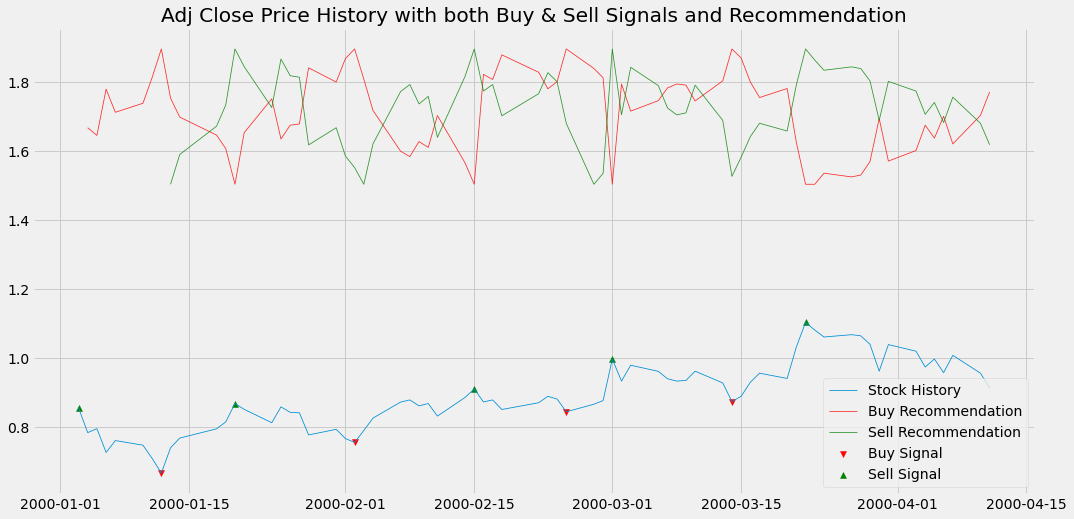

In [17]:
# Plot 1st 100 Days
plt.figure(figsize=(16, 8))
plt.title("Adj Close Price History with both Buy & Sell Signals and Recommendation")
plt.plot(df.index[:70], df["Adj Close"][df.index[:70]], lw=0.8,
         label="Stock History")
plt.plot(df.index[:70], df["Rec(Buy)"][df.index[:70]] * 0.4 + 1.5,
         lw=0.8, alpha = 0.8, label="Buy Recommendation", c='r')
plt.plot(df.index[:70], df["Rec(Sell)"][df.index[:70]] * 0.4 + 1.5,
         lw=0.8, alpha = 0.8, label="Sell Recommendation", c='g')
plt.scatter(df.index[:70], df['Buy'][df.index[:70]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[:70], df['Sell'][df.index[:70]],
            c='g', marker="^", label="Sell Signal")
plt.legend(loc="lower right")
plt.show()

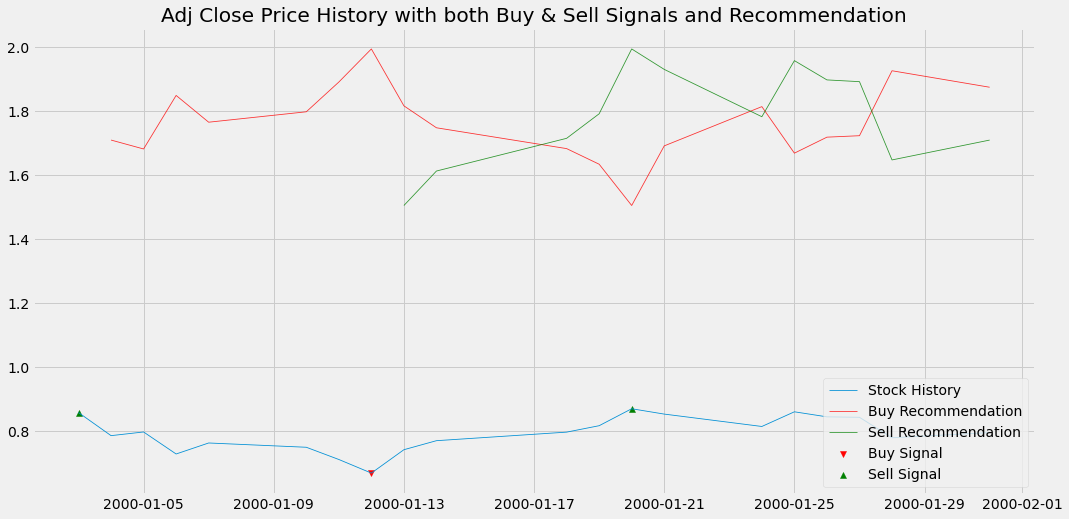

In [18]:
# Plot 1st 20 days
plt.figure(figsize=(16, 8))
plt.title("Adj Close Price History with both Buy & Sell Signals and Recommendation")
plt.plot(df.index[:20], df["Adj Close"][df.index[:20]], lw=0.8,
         label="Stock History")
plt.plot(df.index[:20], df["Rec(Buy)"][df.index[:20]] * 0.5 + 1.5,
         lw=0.8, alpha = 0.8, label="Buy Recommendation", c='r')
plt.plot(df.index[:20], df["Rec(Sell)"][df.index[:20]] * 0.5 + 1.5,
         lw=0.8, alpha = 0.8, label="Sell Recommendation", c='g')
plt.scatter(df.index[:20], df['Buy'][df.index[:20]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[:20], df['Sell'][df.index[:20]],
            c='g', marker="^", label="Sell Signal")
plt.legend(loc="lower right")
plt.show()

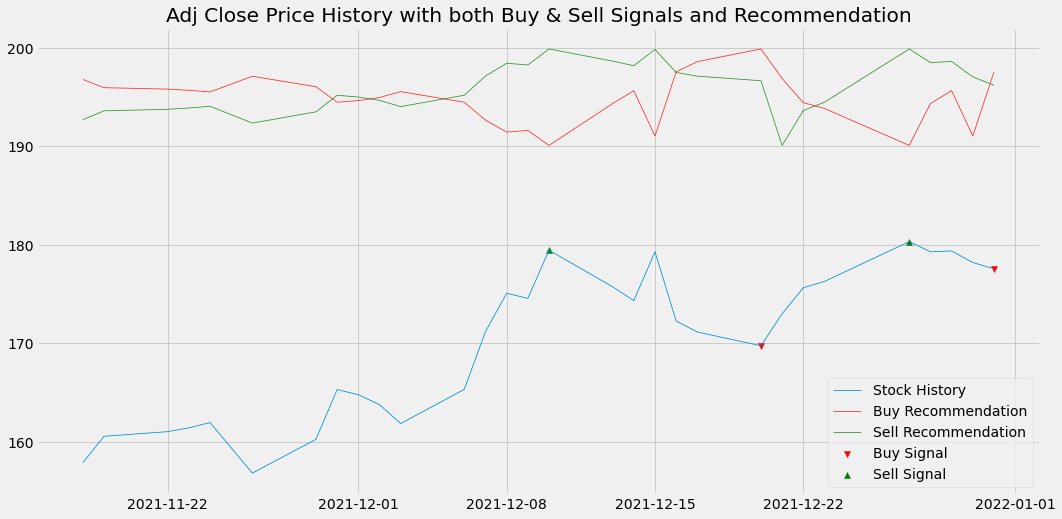

In [19]:
# Plot last 30 days
plt.figure(figsize=(16, 8))
plt.title("Adj Close Price History with both Buy & Sell Signals and Recommendation")
plt.plot(df.index[-30:], df["Adj Close"][df.index[-30:]], lw=0.8,
         label="Stock History")
plt.plot(df.index[-30:], df["Rec(Buy)"][df.index[-30:]] * 10 + 190,
         lw=0.8, alpha = 0.8, label="Buy Recommendation", c='r')
plt.plot(df.index[-30:], df["Rec(Sell)"][df.index[-30:]] * 10 + 190,
         lw=0.8, alpha = 0.8, label="Sell Recommendation", c='g')
plt.scatter(df.index[-30:], df['Buy'][df.index[-30:]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[-30:], df['Sell'][df.index[-30:]],
            c='g', marker="^", label="Sell Signal")
plt.legend(loc="lower right")
plt.show()

### Variant with not scaled Data (currently without Rec(Sell))

In [20]:
# df["Rec(Buy)"] = np.nan
# df["Rec(Sell)"] = np.nan
# sell_to_sell_period_list = []
# buy_to_buy_period_list = []

# i = 0
# for index in df.index:
#     # check for sell_signal
#     if str(df["Sell"][index]) != "nan":
#         # clear sell_to_sell_period_list for new period
#         sell_to_sell_period_list = []
#         # find out the next sell_signal
#         for sub_index in df.index[i + 1:]:
#             if str(df["Sell"][sub_index]) != "nan":
#                 next_sell_signal = df["Sell"][sub_index]
#                 break
#         # fill sell_to_sell_period_list
#         for sub_index in df.index[i + 1:]:
#             sell_to_sell_period_list.append(next_sell_signal - df["Adj Close"][sub_index])
#             """
#             # scale the filled sell_to_sell_period_list min = 0.01 & max = 0.99
#             # if next sell_signal is reached
#             """
#             if str(df["Sell"][sub_index]) != "nan":
#                 """
#                 # transform sell_to_sell_period_list to sell_to_sell_period_np for scaling
#                 # and reshape it to 2 diemensions for scaling
#                 # reshape(-1, 1) if 1 feature; reshape(1, -1) if 1 sample
#                 sell_to_sell_period_np = np.array(sell_to_sell_period_list)\
#                                             .reshape(-1, 1)
#                 print(sell_to_sell_period_np)
#                 scaler = MinMaxScaler(feature_range=(0.01, 0.99))
#                 scaled_sell_to_sell_period_np = scaler.fit_transform(
#                                                     sell_to_sell_period_np)
#                 """
                
#                 break
#         # set Rec(Buy) values to respective once out of scaled_sell_to_sell_period_list
#         j = 0
#         for sub_index in df.index[i + 1:]:
#             """
#             if j == scaled_sell_to_sell_period_np.shape[0]:
#                 break
#             print(scaled_sell_to_sell_period_np[j])
#             df["Rec(Buy)"][sub_index] = scaled_sell_to_sell_period_np[j]
#             """
#             if j == len(sell_to_sell_period_list):
#                 break
#             print(sell_to_sell_period_list[j])
#             df["Rec(Buy)"][sub_index] = sell_to_sell_period_list[j]
#             j += 1
#     i += 1
# df

In [21]:
# # Plot data
# plt.figure(figsize=(16, 8))
# plt.plot(df.index[-300:-200], df["Adj Close"][df.index[-300:-200]], lw=0.8,
#          label="Stock History")
# plt.plot(df.index[-300:-200], df["Rec(Buy)"][df.index[-300:-200]] + 60,
#          lw=0.8, alpha = 0.8, label="Buy Recommendation")
# plt.scatter(df.index[-300:-200], df['Buy'][df.index[-300:-200]],
#             c='r', marker="v", label="Buy Signal")
# plt.scatter(df.index[-300:-200], df['Sell'][df.index[-300:-200]],
#             c='g', marker="^", label="Sell Signal")
# plt.legend()
# plt.show()

## Check when both R(Sell) and R(Buy) are != "nan" from beginning on

In [22]:
# calculate index_rec_buy_sell_not_nan = first index that isn't nan
index_rec_buy_sell_not_nan = 0
for index in df.index[:100]:
    if str(df["Rec(Sell)"][index]) != "nan" and str(df["Rec(Buy)"][index]) != "nan":
        print(f'Rec(Sell){index_rec_buy_sell_not_nan}: ', df["Rec(Sell)"][index])
        print(f"Rec(Buy){index_rec_buy_sell_not_nan}: ", df["Rec(Buy)"][index])
        print("\nindex_rec_buy_sell_not_nan: ", index_rec_buy_sell_not_nan)
        break
    print(f'Rec(Sell){index_rec_buy_sell_not_nan}: ', df["Rec(Sell)"][index])
    print(f"Rec(Buy){index_rec_buy_sell_not_nan}: ", df["Rec(Buy)"][index])
    index_rec_buy_sell_not_nan += 1
    
df.head(index_rec_buy_sell_not_nan + 2)

Rec(Sell)0:  nan
Rec(Buy)0:  nan
Rec(Sell)1:  nan
Rec(Buy)1:  0.419691204513092
Rec(Sell)2:  nan
Rec(Buy)2:  0.3638275702477774
Rec(Sell)3:  nan
Rec(Buy)3:  0.6990288057611522
Rec(Sell)4:  nan
Rec(Buy)4:  0.5314254330155972
Rec(Sell)5:  nan
Rec(Buy)5:  0.5966046996381525
Rec(Sell)6:  nan
Rec(Buy)6:  0.7828277371450622
Rec(Sell)7:  nan
Rec(Buy)7:  0.99
Rec(Sell)8:  0.009999999999999995
Rec(Buy)8:  0.6338501191362533

index_rec_buy_sell_not_nan:  8


,Adj Close,Buy,Sell,Rec(Buy),Rec(Sell)
Date,,,,,
2000-01-03,0.856887,NaN,0.856887,NaN,NaN
2000-01-04,0.784642,NaN,NaN,0.419691,NaN
2000-01-05,0.796124,NaN,NaN,0.363828,NaN
2000-01-06,0.727229,NaN,NaN,0.699029,NaN
2000-01-07,0.761677,NaN,NaN,0.531425,NaN
2000-01-10,0.748281,NaN,NaN,0.596605,NaN
2000-01-11,0.710005,NaN,NaN,0.782828,NaN
2000-01-12,0.667424,0.667424,NaN,0.990000,NaN
2000-01-13,0.740625,NaN,NaN,0.633850,0.010000


## Identify the Buy or Sell Signal before the last one

In [23]:
# identify the Buy or Sell Signal before the last one (important for end of dataset)
i = -1
last_buy_signal_from_end = None
last_sell_signal_from_end = None
for index in reversed(df.index):  # reversed() creates reversed list object of input
    if pd.isna(df['Buy'][index]) == False and last_buy_signal_from_end == None:
        # pd.isna() checks if given value is np.nan and returns True if it is
        last_buy_signal_from_end = i
    if pd.isna(df['Sell'][index]) == False and last_sell_signal_from_end == None:
        last_sell_signal_from_end = i
    if last_buy_signal_from_end != None and last_sell_signal_from_end != None:
        break
    i -=1
    
if last_buy_signal_from_end < last_sell_signal_from_end:
    buy_or_sell_signal_before_the_last_one = last_buy_signal_from_end
elif last_sell_signal_from_end < last_buy_signal_from_end:
    buy_or_sell_signal_before_the_last_one = last_sell_signal_from_end
else:
    print(
        f"ERROR while identifing buy_or_sell_signal_before_the_last_one"
    )

print(
    f"buy_or_sell_signal_before_the_last_one: {buy_or_sell_signal_before_the_last_one}\
    \nlast_buy_signal_from_end: {last_buy_signal_from_end}\
    \nlast_sell_signal_from_end: {last_sell_signal_from_end}"
    )


buy_or_sell_signal_before_the_last_one: -5    
last_buy_signal_from_end: -1    
last_sell_signal_from_end: -5


## Create dataset out of df["Adj Close"]

In [24]:
# get only "Adj close" coulumn
data = df.filter(["Adj Close"])

# convert df to np-array
dataset = data["Adj Close"][
    index_rec_buy_sell_not_nan:buy_or_sell_signal_before_the_last_one + 1
].values

"""
# set number of training data (rows) to 80%
training_data_len = math.ceil(len(dataset) * .8)  # ceil() rounds up integer
print(f"training_data_len: {training_data_len}\n{dataset}\ndataset.shape: {dataset.shape}")
"""

'\n# set number of training data (rows) to 80%\ntraining_data_len = math.ceil(len(dataset) * .8)  # ceil() rounds up integer\nprint(f"training_data_len: {training_data_len}\n{dataset}\ndataset.shape: {dataset.shape}")\n'

In [25]:
df.tail(25), dataset[-5:]

(             Adj Close         Buy        Sell  Rec(Buy)  Rec(Sell)
 Date                                                               
 2021-11-26  156.809998         NaN         NaN  0.712571   0.236870
 2021-11-29  160.240005         NaN         NaN  0.606130   0.350971
 2021-11-30  165.300003         NaN         NaN  0.449107   0.519294
 2021-12-01  164.770004         NaN         NaN  0.465554   0.501663
 2021-12-02  163.759995         NaN         NaN  0.496897   0.468065
 2021-12-03  161.839996         NaN         NaN  0.556479   0.404195
 2021-12-06  165.320007         NaN         NaN  0.448486   0.519959
 2021-12-07  171.179993         NaN         NaN  0.266637   0.714895
 2021-12-08  175.080002         NaN         NaN  0.145611   0.844630
 2021-12-09  174.559998         NaN         NaN  0.161748   0.827332
 2021-12-10  179.449997         NaN  179.449997  0.010000   0.990000
 2021-12-13  175.740005         NaN         NaN  0.435160   0.866585
 2021-12-14  174.330002         Na

In [26]:
# Reshape dataset for scaling
dataset = dataset.reshape(dataset.shape[0], 1)
dataset.shape

(5524, 1)

## Scale dataset

In [27]:
# Scale data from 0.01 to 0.99
scaler = MinMaxScaler(feature_range=(0.01, 0.99))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01293657],
       [0.01309014],
       [0.01323591],
       ...,
       [0.96448385],
       [0.96796579],
       [0.99      ]])

In [28]:
scaled_data.shape

(5524, 1)

## Create x and y out of dataset 

In [71]:
# Create x and y; x = training and testing data (independent variable),
# y = traget (dependent) variable
x = []
y = []

# x = data of history_days days (interating forward)
# y = last value of history_days days
history_days = 30
output_neuron_no = 2

j = 0
# index_rec_buy_sell_not_nan already was added bay creating the dataset
for i in range(history_days, scaled_data.shape[0]):
    x.append(scaled_data[i - history_days:i, 0])
    y.append(
        # index_rec_buy_sell_not_nan has to be added because of index of df is used
        [df["Rec(Buy)"][df.index[i + index_rec_buy_sell_not_nan]],
         df["Rec(Sell)"][df.index[i + index_rec_buy_sell_not_nan]]]
    )
    # print values to compare to upper graph
    # "Adj Close Price History with both Buy & Sell Signals and Recommendation"
    if j < 10 - index_rec_buy_sell_not_nan:
        print(
        f"x[{j}]\
        \n{x[-1]}\
        \ny[{j}]\
        \n{y[-1]}\
        \n"
        )
    j += 1
x = np.array(x)
y = np.array(y)

x[0]        
[0.01293657 0.01309014 0.01323591 0.01334524 0.01363417 0.01354306
 0.01333222 0.01358211 0.01349621 0.0134884  0.0131396  0.0132281
 0.01308234 0.01302247 0.01320988 0.01340511 0.01365759 0.01369144
 0.01359772 0.01363417 0.01343634 0.01373048 0.01386323 0.0136602
 0.01369144 0.01354046 0.01364718 0.0137487  0.0137051  0.01350402]        
y[0]        
[0.848678992023276, 0.010000000000000002]        

x[1]        
[0.01309014 0.01323591 0.01334524 0.01363417 0.01354306 0.01333222
 0.01358211 0.01349621 0.0134884  0.0131396  0.0132281  0.01308234
 0.01302247 0.01320988 0.01340511 0.01365759 0.01369144 0.01359772
 0.01363417 0.01343634 0.01373048 0.01386323 0.0136602  0.01369144
 0.01354046 0.01364718 0.0137487  0.0137051  0.01350402 0.01362376]        
y[1]        
[0.7810936957519307, 0.08897370862495647]        



# Put Data in Function and create Test Model

In [72]:
x.shape, y.shape

((5494, 30), (5494, 2))

In [73]:
x = x.reshape((x.shape[0], x.shape[1], 1))
x.shape

(5494, 30, 1)

In [74]:
model = create_model(
    x, y,
    first_layer_type="LSTM", second_layer_type="Dense",
    neuron_percent_x=0.9, neuron_shrink=0.6, dropout_rate=0.2,
    neuron_count_min=10, layer_no_max=8,
    activation_function_out=None, activation_function_rest="relu"
)
model.summary()

resulting_layer_no: 3
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 30, 27)            3132      
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 30, 27)            0         
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 16)                2816      
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 16)                0         
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 10)                170       
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 10)                0         
_________________________________________________________________
Output_Layer (Dense

In [75]:
layer_type_list

['LSTM', 'LSTM', 'Dense', 'Output (Dense)']

# Fuction that evaluates the Model and Error Analytics

## Fuction that evaluates the Model

Method that is used to handle cross-validation behavior (assigning x and y to test and training data) below:\
**"Shuffle & Split"**\
see details of sklearn.model_selection.ShuffleSplit at\
https://scikit-learn.org/stable/modules/cross_validation.html#shufflesplit \
Note: ShuffleSplit is not affected by classes or groups

vizualisation of cross-validation (CV) behavior:
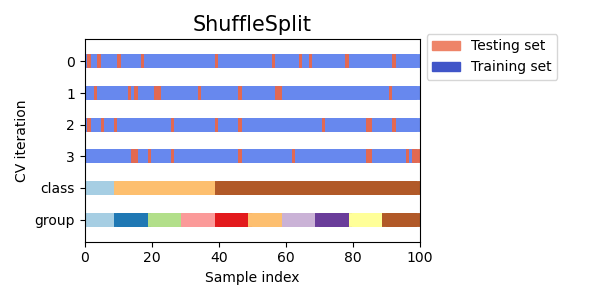

In [29]:
# create evaluate_model function
# (with bootstraping
#   = method to split x and y in test & train data see exmaple in picture above)

# the variable parameters in the evaluate_model function are these that will get optimized
# --> all others has to be fixed
def evaluate_model(
    neuron_percent_x, neuron_shrink, dropout_rate, # has to be float between 0 and 1
#     learning_rate,
    history_days,
    neuron_count_min, layer_no_max,  # has to be integer
    first_by_all_layers_ratio,  # first layer no will get rounded down
    epochs=20, batch_size=128,
    activation_function_out=None, activation_function_rest="relu",
    loss_function="mean_squared_error",
        # (has to be "binary_crossentropy", "categorical_crossentropy"
        # or "mean_squared_error" (string)?)
        # works with "mean_squared_error" (string yet)
    first_layer_type="LSTM",  # at current state only Dense or "LSTM" (string)
    second_layer_type="Dense",  # can't be LSTM (at current state only Dense; string)
    test_size=0.2,  # has to be float between 0 and 1
    optimizer="adam",  # only works with adam at current state
    metrics=["accuracy"]
):

    # Bootstrap
    SPLITS = 2
    boot = ShuffleSplit(n_splits=SPLITS, test_size=test_size)
        # test_size = 10% of x and y

    # Track progress
    mean_benchmark = []
    epochs_needed = []
    current_SPLIT = 0
    
    # Create x and y; x = training and testing data (independent variable),
    # y = traget (dependent) variable
    x = []
    y = []

    # x = data of history_days days (interating forward)
    # y = last value of history_days days
    history_days = int(round(history_days, 0))
    output_neuron_no = 2

    # index_rec_buy_sell_not_nan already was added bay creating the dataset
    for i in range(history_days, scaled_data.shape[0]):
        x.append(scaled_data[i - history_days:i, 0])
        y.append(
            # index_rec_buy_sell_not_nan has to be added because of index of df is used
            [df["Rec(Buy)"][df.index[i + index_rec_buy_sell_not_nan]],
             df["Rec(Sell)"][df.index[i + index_rec_buy_sell_not_nan]]]
        )
    x = np.array(x)
    y = np.array(y)

    # Loop through samples
    for train, test in boot.split(x,y):
        start_time = time.time()
        current_SPLIT += 1

        # Split train and test
        x_train = x[train]
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        y_train = y[train]
        x_test = x[test]
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_test = y[test]
        
        # check if there are nan or infinite values

        # numpy_train.isnan(ar)     # True wherever nan
        # numpy_train.isinf(ar)     # True wherever pos-inf or neg-inf

        ar_nan_x_train = np.where(np.isnan(x_train))
        ar_nan_x_test = np.where(np.isnan(x_test))

        ar_inf_x_train = np.where(np.isinf(x_train))
        ar_inf_x_test = np.where(np.isinf(x_test))

        ar_nan_y_train = np.where(np.isnan(y_train))
        ar_nan_y_test = np.where(np.isnan(y_test))

        ar_inf_y_train = np.where(np.isinf(y_train))
        ar_inf_y_test = np.where(np.isinf(y_test))

        ar_nan_inf_string_list = [
            'ar_nan_x_train', 'ar_nan_x_test', 'ar_inf_x_train', 'ar_inf_x_test',
            'ar_nan_y_train', 'ar_nan_y_test', 'ar_inf_y_train', 'ar_inf_y_test'
        ]
        i = 0
        for j, k, l in [ar_nan_x_train, ar_nan_x_test, ar_inf_x_train, ar_inf_x_test]:
            # j, k, l are the 1st, 2nd and 3rd element of list element after "in"
            # works also without [] after in
            if (j.size and k.size and l.size) == 0:
                # np_array.size == 0 checks if array is empty
                print(
                    f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
                    f" of SPLIT No {current_SPLIT}"
                )
            else:
                print(
                    f"{ar_nan_inf_string_list[i]}:\
                    \n{j, k, l}"
                )
            i += 1

        for j, k in [ar_nan_y_train, ar_nan_y_test, ar_inf_y_train, ar_inf_y_test]:
            if (j.size and k.size) == 0:
                print(f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
                    f" of SPLIT No {current_SPLIT}"
                )
            else:
                print(
                    f"{ar_nan_inf_string_list[i]}:\
                    \n{j, k}"
                )
            i += 1
        # create model        
        model = create_model(
            x_train=x_train, y_train=y_train,
            first_layer_type=first_layer_type, second_layer_type=second_layer_type,
            neuron_percent_x=neuron_percent_x, neuron_shrink=neuron_shrink,
            dropout_rate=neuron_shrink,
            neuron_count_min=int(round(neuron_count_min, 0)),
            layer_no_max=int(round(layer_no_max)),
            activation_function_out=activation_function_out,
            activation_function_rest=activation_function_rest
        )
        
        model.summary()
        
        # if fist layer is Dense and not LSTM input_dim of x has to be 2 not 3
        if layer_type_list[0] == 'Dense':
            x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
            x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
        
        # compile model
        model.compile(
            loss=loss_function,
#             optimizer=Adam(learning_rate=learning_rate),
            optimizer='adam',
            metrics=metrics
        )
        monitor = EarlyStopping(
            monitor='val_loss', min_delta=1e-3, patience=100,
#             verbose=0,
            mode='auto',
            restore_best_weights=True
        )

        # Train on the bootstrap sample
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        model.fit(
            x_train, y_train,validation_data=(x_test, y_test),
            callbacks=[monitor],
#             verbose=0,
            epochs=int(round(epochs, 0)), batch_size=int(round(batch_size, 0))
        )
        epochs_for_tracking = monitor.stopped_epoch
        epochs_needed.append(epochs_for_tracking)

        # Predict on the out of boot (validation)
        y_pred = model.predict(x_test)

        # Measure this bootstrap's mean_squared_error
        score = mean_squared_error(y_test, y_pred)
        mean_benchmark.append(score)
        m1 = statistics.mean(mean_benchmark)
        m2 = statistics.mean(epochs_needed)
        mdev = statistics.pstdev(mean_benchmark)

        # Record this iteration
        time_took = time.time() - start_time
        
    tensorflow.keras.backend.clear_session()
    return(-m1)

In [ ]:
# # Check if function works
# evaluate_model(
#     neuron_percent_x=0.9, neuron_shrink=0.6, dropout_rate=0.2,
#     neuron_count_min=10, layer_no_max=8,
#     learning_rate=0.01, history_days=30,
# )

## Error Analytics

### "ValueError: Input contains NaN, infinity or a value too large for dtype('float64')."
probably at x- or y_train- oder test

In [34]:
# # Create x and y; x = training and testing data (independent variable),
# # y = traget (dependent) variable
# x = []
# y = []

# # x = data of history_days days (interating forward)
# # y = last value of history_days days
# history_days = int(30)
# output_neuron_no = 2

# # index_rec_buy_sell_not_nan already was added bay creating the dataset
# for i in range(history_days, scaled_data.shape[0]):
#     x.append(scaled_data[i - history_days:i, 0])
#     y.append(
#         # index_rec_buy_sell_not_nan has to be added because of index of df is used
#         [df["Rec(Buy)"][df.index[i + index_rec_buy_sell_not_nan]],
#          df["Rec(Sell)"][df.index[i + index_rec_buy_sell_not_nan]]]
#     )
# x = np.array(x)
# y = np.array(y)

# model = create_model(
#     x, y,
#     first_layer_type="LSTM", second_layer_type="Dense",
#     neuron_percent_x=0.9, neuron_shrink=0.6, dropout_rate=0.2,
#     neuron_count_min=10, layer_no_max=8,
#     activation_function_out=None, activation_function_rest="relu"
# )
# model.summary()

# # Bootstrap
# SPLITS = 6
# boot = ShuffleSplit(n_splits=SPLITS, test_size=0.2)
#     # test_size = 10% of x and y

# # Track progress
# mean_benchmark = []
# epochs_needed = []
# # Loop through samples
# for train, test in boot.split(x,y):

#     # Split train and test
#     x_train = x[train]
#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#     y_train = y[train]
#     x_test = x[test]
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#     y_test = y[test]

#     # check if loss is nan
#     model.compile(
#                 loss="mean_squared_error",
#                 optimizer=Adam(learning_rate=0.1),
#                 metrics=['accuracy']
#     )
#     model.fit(
#                 x_train, y_train, epochs=1
#     )

#     model.evaluate(x_test, y_test)

In [38]:
# """variant that checks if there are and if there are no nan or infinite values only"""

# # Create x and y; x = training and testing data (independent variable),
# # y = traget (dependent) variable
# x = []
# y = []

# # x = data of history_days days (interating forward)
# # y = last value of history_days days
# history_days = int(1000)
# output_neuron_no = 2

# # index_rec_buy_sell_not_nan already was added bay creating the dataset
# for i in range(history_days, scaled_data.shape[0]):
#     x.append(scaled_data[i - history_days:i, 0])
#     y.append(
#         # index_rec_buy_sell_not_nan has to be added because of index of df is used
#         [df["Rec(Buy)"][df.index[i + index_rec_buy_sell_not_nan]],
#          df["Rec(Sell)"][df.index[i + index_rec_buy_sell_not_nan]]]
#     )
# x = np.array(x)
# y = np.array(y)

# # Bootstrap
# SPLITS = 1
# test_size = 0.2
# boot = ShuffleSplit(n_splits=SPLITS, test_size=test_size)
#     # test_size = 10% of x and y

# for train, test in boot.split(x,y):
#     start_time = time.time()

#     # Split train and test
#     x_train = x[train]
#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#     x_train[20][15][0] = np.nan  # put test nan value in
#     y_train = y[train]
#     x_test = x[test]
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#     y_test = y[test]
    
#     # check if there are nan or infinite values

#     # numpy_train.isnan(ar)     # True wherever nan
#     # numpy_train.isposinf(ar)  # True wherever pos-inf
#     # numpy_train.isneginf(ar)  # True wherever neg-inf
#     # numpy_train.isinf(ar)     # True wherever pos-inf or neg-inf
#     # numpy_train.isfinite(ar) # True wherever pos-inf or neg-inf or nan

#     ar_nan_x_train = np.where(np.isnan(x_train))
#     ar_nan_x_test = np.where(np.isnan(x_test))
    
#     ar_inf_x_train = np.where(np.isinf(x_train))
#     ar_inf_x_test = np.where(np.isinf(x_test))

#     ar_nan_y_train = np.where(np.isnan(y_train))
#     ar_nan_y_test = np.where(np.isnan(y_test))
    
#     ar_inf_y_train = np.where(np.isinf(y_train))
#     ar_inf_y_test = np.where(np.isinf(y_test))
    
#     ar_nan_inf_string_list = [
#         'ar_nan_x_train', 'ar_nan_x_test', 'ar_inf_x_train', 'ar_inf_x_test',
#         'ar_nan_y_train', 'ar_nan_y_test', 'ar_inf_y_train', 'ar_inf_y_test'
#     ]
#     i = 0
#     for j, k, l in [ar_nan_x_train, ar_nan_x_test, ar_inf_x_train, ar_inf_x_test]:
#         # j, k, l are the 1st, 2nd and 3rd element of list element after "in"
#         # works also without [] after in
#         if (j.size and k.size and l.size) == 0:
#             # np_array.size == 0 checks if array is empty
#             print(f"no nan or infinite value in {ar_nan_inf_string_list[i]}")
#         else:
#             print(
#                 f"{ar_nan_inf_string_list[i]}:\
#                 \n{j, k, l}"
#             )
#         i += 1
    
#     for j, k in [ar_nan_y_train, ar_nan_y_test, ar_inf_y_train, ar_inf_y_test]:
#         if (j.size and k.size) == 0:
#             print(f"no nan or infinite value in {ar_nan_inf_string_list[i]}")
#         else:
#             print(
#                 f"{ar_nan_inf_string_list[i]}:\
#                 \n{j, k}"
#             )
#         i += 1

ar_nan_x_train:                
(array([20], dtype=int64), array([15], dtype=int64), array([0], dtype=int64))
no nan or infinite value in ar_nan_x_test
no nan or infinite value in ar_inf_x_train
no nan or infinite value in ar_inf_x_test
no nan or infinite value in ar_nan_y_train
no nan or infinite value in ar_nan_y_test
no nan or infinite value in ar_inf_y_train
no nan or infinite value in ar_inf_y_test


In [36]:
#         """variant that checks IF THERE ARE nan or infinite values only"""

# # Create x and y; x = training and testing data (independent variable),
# # y = traget (dependent) variable
# x = []
# y = []

# # x = data of history_days days (interating forward)
# # y = last value of history_days days
# history_days = int(1000)
# output_neuron_no = 2

# # index_rec_buy_sell_not_nan already was added bay creating the dataset
# for i in range(history_days, scaled_data.shape[0]):
#     x.append(scaled_data[i - history_days:i, 0])
#     y.append(
#         # index_rec_buy_sell_not_nan has to be added because of index of df is used
#         [df["Rec(Buy)"][df.index[i + index_rec_buy_sell_not_nan]],
#          df["Rec(Sell)"][df.index[i + index_rec_buy_sell_not_nan]]]
#     )
# x = np.array(x)
# y = np.array(y)

# # Bootstrap
# SPLITS = 1
# test_size = 0.2
# boot = ShuffleSplit(n_splits=SPLITS, test_size=test_size)
#     # test_size = 10% of x and y

# for train, test in boot.split(x,y):
#     start_time = time.time()

#     # Split train and test
#     x_train = x[train]
#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#     x_train[20][15][0] = np.nan  # put test nan value in
#     y_train = y[train]
#     x_test = x[test]
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#     y_test = y[test]
    
#     # check if there are nan or infinite values

#     # numpy_train.isnan(ar)     # True wherever nan
#     # numpy_train.isposinf(ar)  # True wherever pos-inf
#     # numpy_train.isneginf(ar)  # True wherever neg-inf
#     # numpy_train.isinf(ar)     # True wherever pos-inf or neg-inf
#     # numpy_train.isfinite(ar) # True wherever pos-inf or neg-inf or nan

#     ar_nan_x_train = np.where(np.isnan(x_train))
#     ar_nan_x_test = np.where(np.isnan(x_test))
    
#     ar_inf_x_train = np.where(np.isinf(x_train))
#     ar_inf_x_test = np.where(np.isinf(x_test))

#     ar_nan_y_train = np.where(np.isnan(y_train))
#     ar_nan_y_test = np.where(np.isnan(y_test))
    
#     ar_inf_y_train = np.where(np.isinf(y_train))
#     ar_inf_y_test = np.where(np.isinf(y_test))
    
#     ar_nan_inf_string_list = [
#         'ar_nan_x_train', 'ar_nan_x_test', 'ar_inf_x_train', 'ar_inf_x_test',
#         'ar_nan_y_train', 'ar_nan_y_test', 'ar_inf_y_train', 'ar_inf_y_test'
#     ]
#     i = 0
#     for j, k, l in [ar_nan_x_train, ar_nan_x_test, ar_inf_x_train, ar_inf_x_test]:
#         # j, k, l are the 1st, 2nd and 3rd element of list element after "in"
#         # works also without [] after in
#         if (j.size and k.size and l.size) > 0:
#             # np_array.size > 0 checks if array is not empty
#             print(
#                 f"{ar_nan_inf_string_list[i]}:\
#                 \n{j, k, l}"
#             )
#         i += 1
    
#     for j, k in [ar_nan_y_train, ar_nan_y_test, ar_inf_y_train, ar_inf_y_test]:
#         if (j.size and k.size) > 0:
#             print(
#                 f"{ar_nan_inf_string_list[i]}:\
#                 \n{j, k}"
#             )
#         i += 1

### rebuild situation in maximize() that fails with NaN_Error at
"score = mean_squared_error(y_test, y_pred)"

In [49]:
# rebuild situation in maximize() that fails with NaN_Error at
# score = mean_squared_error(y_test, y_pred)
# evaluate_model(0.9, 0.1, 0.2, 0.1, 60, 3, 8, 0.5, 3, 64)

no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [38]:
# # rebuild situation in maximize()/evaluate_model() that fails with NaN_Error before
# # score = mean_squared_error(y_test, y_pred)
# # Bootstrap
# SPLITS = 1
# boot = ShuffleSplit(n_splits=SPLITS, test_size=0.2)
#     # test_size = 10% of x and y

# # Track progress
# mean_benchmark = []
# epochs_needed = []
# current_SPLIT = 0

# # Create x and y; x = training and testing data (independent variable),
# # y = traget (dependent) variable
# x = []
# y = []

# # x = data of history_days days (interating forward)
# # y = last value of history_days days
# history_days = int(365)
# output_neuron_no = 2

# # index_rec_buy_sell_not_nan already was added bay creating the dataset
# for i in range(history_days, scaled_data.shape[0]):
#     x.append(scaled_data[i - history_days:i, 0])
#     y.append(
#         # index_rec_buy_sell_not_nan has to be added because of index of df is used
#         [df["Rec(Buy)"][df.index[i + index_rec_buy_sell_not_nan]],
#          df["Rec(Sell)"][df.index[i + index_rec_buy_sell_not_nan]]]
#     )
# x = np.array(x)
# y = np.array(y)

# # Loop through samples
# for train, test in boot.split(x,y):
#     start_time = time.time()
#     current_SPLIT += 1

#     # Split train and test
#     x_train = x[train]
#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#     y_train = y[train]
#     x_test = x[test]
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#     y_test = y[test]
    
#     ar_nan_x_train = np.where(np.isnan(x_train))
#     ar_nan_x_test = np.where(np.isnan(x_test))

#     ar_inf_x_train = np.where(np.isinf(x_train))
#     ar_inf_x_test = np.where(np.isinf(x_test))

#     ar_nan_y_train = np.where(np.isnan(y_train))
#     ar_nan_y_test = np.where(np.isnan(y_test))

#     ar_inf_y_train = np.where(np.isinf(y_train))
#     ar_inf_y_test = np.where(np.isinf(y_test))

#     ar_nan_inf_string_list = [
#         'ar_nan_x_train', 'ar_nan_x_test', 'ar_inf_x_train', 'ar_inf_x_test',
#         'ar_nan_y_train', 'ar_nan_y_test', 'ar_inf_y_train', 'ar_inf_y_test'
#     ]
#     i = 0
#     for j, k, l in [ar_nan_x_train, ar_nan_x_test, ar_inf_x_train, ar_inf_x_test]:
#         # j, k, l are the 1st, 2nd and 3rd element of list element after "in"
#         # works also without [] after in
#         if (j.size and k.size and l.size) == 0:
#             # np_array.size == 0 checks if array is empty
#             print(
#                 f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
#                 f" of SPLIT No {current_SPLIT}"
#             )
#         else:
#             print(
#                 f"{ar_nan_inf_string_list[i]}:\
#                 \n{j, k, l}"
#             )
#         i += 1

#     for j, k in [ar_nan_y_train, ar_nan_y_test, ar_inf_y_train, ar_inf_y_test]:
#         if (j.size and k.size) == 0:
#             print(f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
#                 f" of SPLIT No {current_SPLIT}"
#             )
#         else:
#             print(
#                 f"{ar_nan_inf_string_list[i]}:\
#                 \n{j, k}"
#             )
#         i += 1
    
#     # create model        
#     model = create_model(
#         x_train=x_train, y_train=y_train,
#         first_layer_type="LSTM", second_layer_type="Dense",
#         neuron_percent_x=0.9, neuron_shrink=0.9,
#         dropout_rate=0.2,
#         neuron_count_min=int(3), layer_no_max=int(8),
#         activation_function_out="linear",
#         activation_function_rest="relu"
#     )

#     # compile model
#     model.compile(
#         loss="mean_squared_error", optimizer="adam",
#         metrics=['accuracy']
#     )
#     monitor = EarlyStopping(
#         monitor='val_loss', min_delta=1e-3, patience=100, mode='auto',
#         restore_best_weights=True
#     )

#     # Train on the bootstrap sample
#     model.fit(
#         x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor],
#         epochs=int(3), batch_size=int(128)
#     )
#     epochs_for_tracking = monitor.stopped_epoch
#     epochs_needed.append(epochs_for_tracking)
    
#     model.evaluate(x_test, y_test, batch_size=128)

# #     # Predict on the out of boot (validation)
# #     y_pred = model.predict(x_test)

# #     ar_nan_y_pred = np.where(np.isnan(y_pred))
# #     ar_inf_y_pred = np.where(np.isinf(y_pred))

# #     ar_nan_inf_string_list = ['ar_nan_y_pred', 'ar_inf_y_pred']
# #     i = 0
# #     for j, k in [ar_nan_y_pred, ar_inf_y_pred]:
# #                 if (j.size and k.size) == 0:
# #                     print(
# #                         f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
# #                         f" of SPLIT No {current_SPLIT}"
# #                     )
# #                 else:
# #                     print(
# #                         f"{ar_nan_inf_string_list[i]}:\
# #                         \n{j, k}"
# #                     )
# #                 i += 1
# #     print(y_pred)

no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
Epoch 1/3
 5/33 [===>..........................] - ETA: 45:51 - loss: 0.3618 - accuracy: 0.5047

KeyboardInterrupt: 

# Run Optimization

## Run with too high history_days bound (runtime ca. 24h)

In [91]:
from bayes_opt import BayesianOptimization
import time

n_iter = 50
# How many steps of bayesian optimization you want to perform.
# The more steps the more likely to find a good maximum you are.

init_points = 10
# How many steps of random exploration you want to perform.
# Random exploration can help by diversifying the exploration space.


# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

# Bounded region of parameter space
pbounds = {
    'dropout_rate': (0, 0.499),
    'epochs': (3, 50),
    'first_by_all_layers_ratio': (0.1, 0.9),
    'history_days': (20, 1500),
    'layer_no_max': (4, 20),
#     'learning_rate': (0.0001, 0.15),
    'neuron_count_min': (3, 10),
    'neuron_percent_x': (0.1, 0.99),
    'neuron_shrink': (0.1, 0.99),   
#     'batch_size': (32, 128)
}

optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=init_points, n_iter=n_iter,)
time_took = time.time() - start_time

print(f"Total runtime: {datetime.timedelta(seconds=time_took)}")
print(optimizer.max)

|   iter    |  target   | dropou... |  epochs   | first_... | histor... | layer_... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------------------
no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 5
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 467, 124)          62496     
_________________________________________________

Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 467, 124)          62496     
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 467, 124)          0         
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 51)                35904     
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 51)                0         
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 21)                1092      
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 21)                0         
_________________________________________________________________
Dense_Layer_4 (Dense)        (None, 9)   

29/29 [==============================] - 1622s 56s/step - loss: 0.3513 - accuracy: 0.5061 - val_loss: 0.2898 - val_accuracy: 0.5000
Epoch 2/28
29/29 [==============================] - 1691s 58s/step - loss: 0.2629 - accuracy: 0.5017 - val_loss: 0.1918 - val_accuracy: 0.5000
Epoch 3/28
29/29 [==============================] - 1769s 61s/step - loss: 0.2035 - accuracy: 0.4997 - val_loss: 0.1400 - val_accuracy: 0.5000
Epoch 4/28
29/29 [==============================] - 1814s 63s/step - loss: 0.1710 - accuracy: 0.5022 - val_loss: 0.1197 - val_accuracy: 0.5000
Epoch 5/28
29/29 [==============================] - 1837s 63s/step - loss: 0.1556 - accuracy: 0.5131 - val_loss: 0.1120 - val_accuracy: 0.5000
Epoch 6/28
29/29 [==============================] - 1856s 64s/step - loss: 0.1489 - accuracy: 0.4983 - val_loss: 0.1083 - val_accuracy: 0.5000
Epoch 7/28
29/29 [==============================] - 1957s 68s/step - loss: 0.1429 - accuracy: 0.5059 - val_loss: 0.1049 - val_accuracy: 0.5000
Epoch 8/28

KeyboardInterrupt: 

## Compare standard Optimizer, mutated Optimizer and scaling between 0.01 - 0.99 and -0.99 - 0.99 as output

### Define and run Optimizers

In [62]:
# Try to contract pbounds with SequentialDomainReductionTransformer
# see:
    # https://github.com/fmfn/BayesianOptimization
    # and https://github.com/fmfn/BayesianOptimization/blob/master/examples/domain_reduction.ipynb

from bayes_opt import SequentialDomainReductionTransformer

# Bounded region of parameter space
pbounds_for_contract = {
    'dropout_rate': (0, 0.499),
    'epochs': (3, 20),
    'first_by_all_layers_ratio': (0.1, 0.9),
    'history_days': (30, 90),
    'layer_no_max': (4, 20),
#     'learning_rate': (0.0001, 0.15),
    'neuron_count_min': (3, 10),
    'neuron_percent_x': (0.1, 0.9),
    'neuron_shrink': (0.1, 0.9),   
#     'batch_size': (32, 128)
}

bounds_transformer = SequentialDomainReductionTransformer()

mutating_optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds_for_contract,
    verbose=2,
    random_state=1,
    bounds_transformer=bounds_transformer
)

mutating_optimizer.maximize(
    init_points=2,
    n_iter=5,
)

print(
    50*"=",
    50*"=",
    50*"=",
    sep="\n"
)

standard_optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds_for_contract,
    verbose=2,
    random_state=1,
)


standard_optimizer.maximize(
    init_points=2,
    n_iter=5,
)


|   iter    |  target   | dropou... |  epochs   | first_... | histor... | layer_... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------------------
no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 2
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 12)                672       
_________________________________________________

35/35 [==============================] - 1s 11ms/step - loss: 0.4058 - accuracy: 0.4958 - val_loss: 0.3745 - val_accuracy: 0.4908
Epoch 2/12
35/35 [==============================] - 0s 4ms/step - loss: 0.3892 - accuracy: 0.5029 - val_loss: 0.3721 - val_accuracy: 0.4899
Epoch 3/12
35/35 [==============================] - 0s 5ms/step - loss: 0.3867 - accuracy: 0.5006 - val_loss: 0.3716 - val_accuracy: 0.4908
Epoch 4/12
35/35 [==============================] - 0s 4ms/step - loss: 0.3868 - accuracy: 0.5026 - val_loss: 0.3711 - val_accuracy: 0.4908
Epoch 5/12
35/35 [==============================] - 0s 4ms/step - loss: 0.3860 - accuracy: 0.5026 - val_loss: 0.3712 - val_accuracy: 0.4908
Epoch 6/12
35/35 [==============================] - 0s 6ms/step - loss: 0.3860 - accuracy: 0.5026 - val_loss: 0.3709 - val_accuracy: 0.4908
Epoch 7/12
35/35 [==============================] - 0s 8ms/step - loss: 0.3859 - accuracy: 0.5026 - val_loss: 0.3709 - val_accuracy: 0.4908
Epoch 8/12
35/35 [============

no nan or infinite value in ar_nan_x_train of SPLIT No 2
no nan or infinite value in ar_nan_x_test of SPLIT No 2
no nan or infinite value in ar_inf_x_train of SPLIT No 2
no nan or infinite value in ar_inf_x_test of SPLIT No 2
no nan or infinite value in ar_nan_y_train of SPLIT No 2
no nan or infinite value in ar_nan_y_test of SPLIT No 2
no nan or infinite value in ar_inf_y_train of SPLIT No 2
no nan or infinite value in ar_inf_y_test of SPLIT No 2
resulting_layer_no: 1
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer_1 (Dense)        (None, 12)                588       
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 12)                0         
_________________________________________________________________
Output_Layer (Dense)         (None, 2)                 26        
Total params: 614
Trainable p

35/35 [==============================] - 8s 94ms/step - loss: 0.3917 - accuracy: 0.5111 - val_loss: 0.3711 - val_accuracy: 0.5269
Epoch 2/11
35/35 [==============================] - 3s 93ms/step - loss: 0.3880 - accuracy: 0.4953 - val_loss: 0.3693 - val_accuracy: 0.5123
Epoch 3/11
35/35 [==============================] - 4s 102ms/step - loss: 0.3875 - accuracy: 0.4912 - val_loss: 0.3691 - val_accuracy: 0.5068
Epoch 4/11
35/35 [==============================] - 3s 79ms/step - loss: 0.3863 - accuracy: 0.5049 - val_loss: 0.3688 - val_accuracy: 0.5087
Epoch 5/11
35/35 [==============================] - 3s 80ms/step - loss: 0.3862 - accuracy: 0.5051 - val_loss: 0.3688 - val_accuracy: 0.4858
Epoch 6/11
35/35 [==============================] - 2s 71ms/step - loss: 0.3861 - accuracy: 0.5049 - val_loss: 0.3686 - val_accuracy: 0.5068
Epoch 7/11
35/35 [==============================] - 3s 75ms/step - loss: 0.3860 - accuracy: 0.5045 - val_loss: 0.3685 - val_accuracy: 0.5068
Epoch 8/11
35/35 [=====

35/35 [==============================] - 1s 39ms/step - loss: 0.3840 - accuracy: 0.5035 - val_loss: 0.3785 - val_accuracy: 0.5027
Epoch 8/15
35/35 [==============================] - 1s 31ms/step - loss: 0.3837 - accuracy: 0.5099 - val_loss: 0.3785 - val_accuracy: 0.5027
Epoch 9/15
35/35 [==============================] - 1s 30ms/step - loss: 0.3838 - accuracy: 0.4987 - val_loss: 0.3785 - val_accuracy: 0.5027
Epoch 10/15
35/35 [==============================] - 1s 29ms/step - loss: 0.3834 - accuracy: 0.5022 - val_loss: 0.3786 - val_accuracy: 0.5027
Epoch 11/15
35/35 [==============================] - 1s 35ms/step - loss: 0.3836 - accuracy: 0.5010 - val_loss: 0.3786 - val_accuracy: 0.5027
Epoch 12/15
35/35 [==============================] - 1s 37ms/step - loss: 0.3836 - accuracy: 0.5015 - val_loss: 0.3786 - val_accuracy: 0.5027
Epoch 13/15
35/35 [==============================] - 1s 34ms/step - loss: 0.3836 - accuracy: 0.5003 - val_loss: 0.3786 - val_accuracy: 0.5027
Epoch 14/15
35/35 [=

35/35 [==============================] - 2s 50ms/step - loss: 0.3802 - accuracy: 0.5031 - val_loss: 0.3914 - val_accuracy: 0.4913
|  1        | -0.3868   |  0.2081   |  15.25    |  0.1001   |  48.14    |  6.348    |  3.646    |  0.249    |  0.3764   |
no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 1
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer_1 (Dense)        (None, 9)                 648       
_________________________________________

35/35 [==============================] - 15s 278ms/step - loss: 0.3886 - accuracy: 0.4950 - val_loss: 0.3779 - val_accuracy: 0.5046
Epoch 2/12
35/35 [==============================] - 10s 283ms/step - loss: 0.3853 - accuracy: 0.5124 - val_loss: 0.3771 - val_accuracy: 0.5046
Epoch 3/12
35/35 [==============================] - 9s 251ms/step - loss: 0.3851 - accuracy: 0.4986 - val_loss: 0.3771 - val_accuracy: 0.5046
Epoch 4/12
35/35 [==============================] - 9s 251ms/step - loss: 0.3851 - accuracy: 0.5085 - val_loss: 0.3770 - val_accuracy: 0.5046
Epoch 5/12
35/35 [==============================] - 9s 270ms/step - loss: 0.3845 - accuracy: 0.5053 - val_loss: 0.3770 - val_accuracy: 0.5046
Epoch 6/12
35/35 [==============================] - 9s 262ms/step - loss: 0.3846 - accuracy: 0.4862 - val_loss: 0.3770 - val_accuracy: 0.5046
Epoch 7/12
35/35 [==============================] - 9s 263ms/step - loss: 0.3844 - accuracy: 0.4972 - val_loss: 0.3770 - val_accuracy: 0.5046
Epoch 8/12
35/3

35/35 [==============================] - 17s 493ms/step - loss: 0.3846 - accuracy: 0.4835 - val_loss: 0.3838 - val_accuracy: 0.4945
Epoch 3/12
35/35 [==============================] - 15s 426ms/step - loss: 0.3834 - accuracy: 0.5016 - val_loss: 0.3834 - val_accuracy: 0.4945
Epoch 4/12
35/35 [==============================] - 14s 394ms/step - loss: 0.3830 - accuracy: 0.4959 - val_loss: 0.3835 - val_accuracy: 0.4945
Epoch 5/12
35/35 [==============================] - 15s 442ms/step - loss: 0.3830 - accuracy: 0.5023 - val_loss: 0.3834 - val_accuracy: 0.4945
Epoch 6/12
35/35 [==============================] - 14s 409ms/step - loss: 0.3831 - accuracy: 0.4853 - val_loss: 0.3833 - val_accuracy: 0.5055
Epoch 7/12
35/35 [==============================] - 15s 437ms/step - loss: 0.3830 - accuracy: 0.4995 - val_loss: 0.3834 - val_accuracy: 0.4945
Epoch 8/12
35/35 [==============================] - 16s 457ms/step - loss: 0.3828 - accuracy: 0.5053 - val_loss: 0.3832 - val_accuracy: 0.5055
Epoch 9/12

Epoch 7/13
35/35 [==============================] - 7s 203ms/step - loss: 0.3854 - accuracy: 0.5024 - val_loss: 0.3741 - val_accuracy: 0.5037
Epoch 8/13
35/35 [==============================] - 8s 219ms/step - loss: 0.3852 - accuracy: 0.5118 - val_loss: 0.3741 - val_accuracy: 0.5229
Epoch 9/13
35/35 [==============================] - 7s 200ms/step - loss: 0.3846 - accuracy: 0.5095 - val_loss: 0.3741 - val_accuracy: 0.5266
Epoch 10/13
35/35 [==============================] - 7s 195ms/step - loss: 0.3843 - accuracy: 0.5036 - val_loss: 0.3743 - val_accuracy: 0.4835
Epoch 11/13
35/35 [==============================] - 7s 202ms/step - loss: 0.3850 - accuracy: 0.5201 - val_loss: 0.3740 - val_accuracy: 0.5009
Epoch 12/13
35/35 [==============================] - 6s 185ms/step - loss: 0.3845 - accuracy: 0.5141 - val_loss: 0.3742 - val_accuracy: 0.5138
Epoch 13/13
35/35 [==============================] - 7s 197ms/step - loss: 0.3842 - accuracy: 0.5309 - val_loss: 0.3741 - val_accuracy: 0.4826
no

35/35 [==============================] - 7s 109ms/step - loss: 0.3825 - accuracy: 0.5008 - val_loss: 0.3974 - val_accuracy: 0.5046
Epoch 2/10
35/35 [==============================] - 3s 95ms/step - loss: 0.3801 - accuracy: 0.5091 - val_loss: 0.3971 - val_accuracy: 0.5046
Epoch 3/10
35/35 [==============================] - 4s 109ms/step - loss: 0.3803 - accuracy: 0.5015 - val_loss: 0.3970 - val_accuracy: 0.5046
Epoch 4/10
35/35 [==============================] - 4s 101ms/step - loss: 0.3800 - accuracy: 0.5019 - val_loss: 0.3971 - val_accuracy: 0.5046
Epoch 5/10
35/35 [==============================] - 3s 95ms/step - loss: 0.3799 - accuracy: 0.5045 - val_loss: 0.3968 - val_accuracy: 0.5248
Epoch 6/10
35/35 [==============================] - 3s 94ms/step - loss: 0.3794 - accuracy: 0.5017 - val_loss: 0.3966 - val_accuracy: 0.5303
Epoch 7/10
35/35 [==============================] - 4s 101ms/step - loss: 0.3791 - accuracy: 0.5146 - val_loss: 0.3968 - val_accuracy: 0.5367
Epoch 8/10
35/35 [==

### Results of SequentialDomainReductionTransformer() with Output Values scaled between -0.99 and 0.99

mutating_optimizer.max:    
{'target': -0.37253000229772915, 'params': {'dropout_rate': 0.20809398034658444, 'epochs': 15.245516388516688, 'first_by_all_layers_ratio': 0.10009149985387591, 'history_days': 48.13995435791038, 'layer_no_max': 6.348094253073809, 'neuron_count_min': 3.646370163381585, 'neuron_percent_x': 0.24900816910213674, 'neuron_shrink': 0.3764485816344382}}    
    
standard_optimizer.max::    
{'target': -0.3730605447162557, 'params': {'dropout_rate': 0.25885208080031025, 'epochs': 11.674949101515784, 'first_by_all_layers_ratio': 0.3661379206561419, 'history_days': 71.9861112897437, 'layer_no_max': 6.823212389674488, 'neuron_count_min': 9.075816307760014, 'neuron_percent_x': 0.5606100850472355, 'neuron_shrink': 0.6568261470527703}}


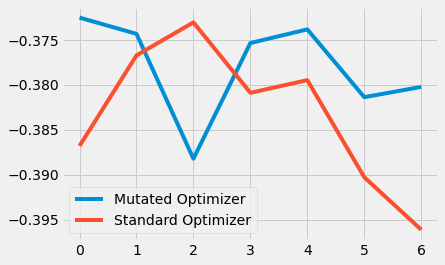

In [82]:
# plot performance comparison
plt.plot(mutating_optimizer.space.target, label='Mutated Optimizer')
plt.plot(standard_optimizer.space.target, label='Standard Optimizer')
plt.legend()
print(
    f"mutating_optimizer.max:\
    \n{mutating_optimizer.max}\
    \n\
    \nstandard_optimizer.max::\
    \n{standard_optimizer.max}"
)
# scaling between 0.01:0.99 has a greater relative range (=> better improvement?)
# ...of values plotted (e.g. -0.37/-0,39 (range-0.99:0.99) > 0,095/0,115(range0.01:0.99))
# => scaling of range0.01:0.99 will be choosen

### Results of SequentialDomainReductionTransformer() with Output Values scaled between 0.01 and 0.99 (detailed analysis included)

In [114]:
# transformed bounds ofer iterations are loged in bounds_transformer.bounds
print("Bounds:")
for idx, val in enumerate(bounds_transformer.bounds):
    print(
        f"chosen bounds over iterations of parameter{idx}:\
        \n{val}\n"
    )

# corresponding chosen parameters can be found in mutating_optimizer.space.params
print("\nParameters:")
for idx, val in enumerate(mutating_optimizer.space.params):
    print(
        f"chosen parameters over iterations of parameter{idx}:\
        \n{val}\n"
    )

Bounds:
chosen bounds over iterations of parameter0:        
[[ 0.     0.499]
 [ 3.    20.   ]
 [ 0.1    0.9  ]
 [30.    90.   ]
 [ 4.    20.   ]
 [ 3.    10.   ]
 [ 0.1    0.9  ]
 [ 0.1    0.9  ]]

chosen bounds over iterations of parameter1:        
[[8.06928133e-03 4.08118679e-01]
 [8.54779221e+00 2.00000000e+01]
 [1.00000000e-01 4.04096075e-01]
 [3.00000000e+01 7.18469521e+01]
 [4.00000000e+00 1.25454990e+01]
 [3.00000000e+00 6.33868867e+00]
 [1.00000000e-01 5.60458578e-01]
 [1.00000000e-01 6.94271011e-01]]

chosen bounds over iterations of parameter2:        
[[2.80717512e-02 3.88116209e-01]
 [9.21756463e+00 2.00000000e+01]
 [1.00000000e-01 3.73695617e-01]
 [3.00000000e+01 6.94762523e+01]
 [4.00000000e+00 1.19257585e+01]
 [3.00000000e+00 6.06945682e+00]
 [1.00000000e-01 5.29313537e-01]
 [1.00000000e-01 6.62488768e-01]]

chosen bounds over iterations of parameter3:        
[[ 0.          0.18608357]
 [ 9.28234796 20.        ]
 [ 0.1         0.56687997]
 [30.         67.41900977]
 [

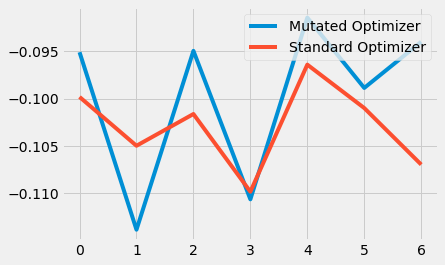

In [95]:
# plot performance comparison
plt.plot(mutating_optimizer.space.target, label='Mutated Optimizer')
plt.plot(standard_optimizer.space.target, label='Standard Optimizer')
plt.legend()

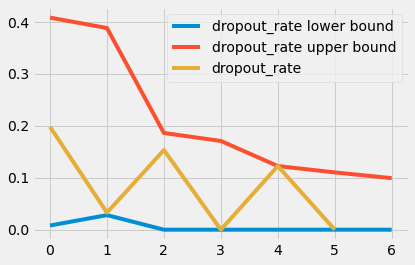

In [102]:
# example dropout_rate-bound shrinking
dropout_rate_min_bound = [b[0][0] for b in bounds_transformer.bounds]
dropout_rate_max_bound = [b[0][1] for b in bounds_transformer.bounds]
dropout_rate = [dropout_rate[0] for dropout_rate in mutating_optimizer.space.params]

plt.plot(dropout_rate_min_bound[1:], label='dropout_rate lower bound')
plt.plot(dropout_rate_max_bound[1:], label='dropout_rate upper bound')
plt.plot(dropout_rate[1:], label='dropout_rate')
plt.legend()

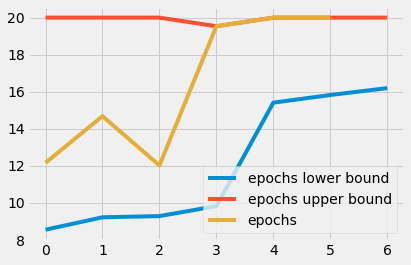

In [103]:
# example epochs-bound shrinking
epochs_min_bound = [b[1][0] for b in bounds_transformer.bounds]
epochs_max_bound = [b[1][1] for b in bounds_transformer.bounds]
epochs = [epochs[1] for epochs in mutating_optimizer.space.params]

plt.plot(epochs_min_bound[1:], label='epochs lower bound')
plt.plot(epochs_max_bound[1:], label='epochs upper bound')
plt.plot(epochs[1:], label='epochs')
plt.legend()

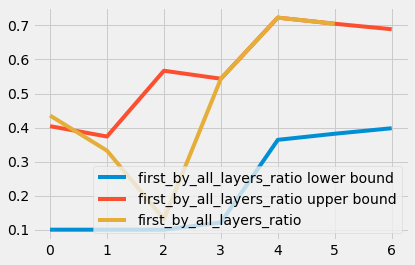

In [104]:
# example first_by_all_layers_ratio-bound shrinking
first_by_all_layers_ratio_min_bound = [b[2][0] for b in bounds_transformer.bounds]
first_by_all_layers_ratio_max_bound = [b[2][1] for b in bounds_transformer.bounds]
first_by_all_layers_ratio = [first_by_all_layers_ratio[2] for first_by_all_layers_ratio in mutating_optimizer.space.params]

plt.plot(first_by_all_layers_ratio_min_bound[1:], label='first_by_all_layers_ratio lower bound')
plt.plot(first_by_all_layers_ratio_max_bound[1:], label='first_by_all_layers_ratio upper bound')
plt.plot(first_by_all_layers_ratio[1:], label='first_by_all_layers_ratio')
plt.legend()

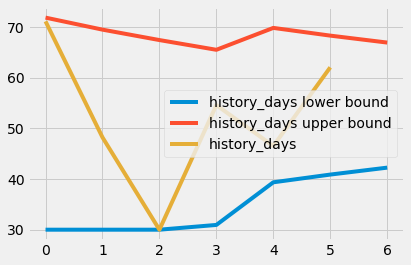

In [105]:
# example history_days-bound shrinking
history_days_min_bound = [b[3][0] for b in bounds_transformer.bounds]
history_days_max_bound = [b[3][1] for b in bounds_transformer.bounds]
history_days = [history_days[3] for history_days in mutating_optimizer.space.params]

plt.plot(history_days_min_bound[1:], label='history_days lower bound')
plt.plot(history_days_max_bound[1:], label='history_days upper bound')
plt.plot(history_days[1:], label='history_days')
plt.legend()

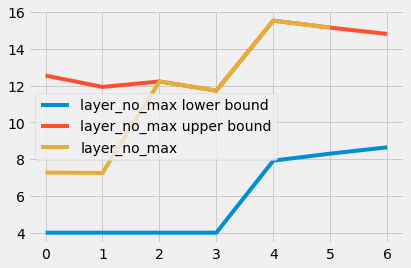

In [106]:
# example layer_no_max-bound shrinking
layer_no_max_min_bound = [b[4][0] for b in bounds_transformer.bounds]
layer_no_max_max_bound = [b[4][1] for b in bounds_transformer.bounds]
layer_no_max = [layer_no_max[4] for layer_no_max in mutating_optimizer.space.params]

plt.plot(layer_no_max_min_bound[1:], label='layer_no_max lower bound')
plt.plot(layer_no_max_max_bound[1:], label='layer_no_max upper bound')
plt.plot(layer_no_max[1:], label='layer_no_max')
plt.legend()

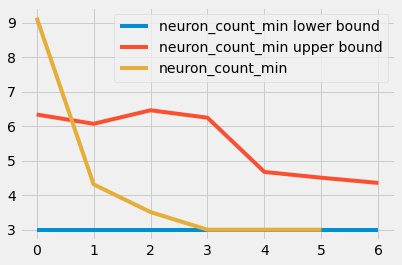

In [107]:
# example neuron_count_min-bound shrinking
neuron_count_min_min_bound = [b[5][0] for b in bounds_transformer.bounds]
neuron_count_min_max_bound = [b[5][1] for b in bounds_transformer.bounds]
neuron_count_min = [neuron_count_min[5] for neuron_count_min in mutating_optimizer.space.params]

plt.plot(neuron_count_min_min_bound[1:], label='neuron_count_min lower bound')
plt.plot(neuron_count_min_max_bound[1:], label='neuron_count_min upper bound')
plt.plot(neuron_count_min[1:], label='neuron_count_min')
plt.legend()

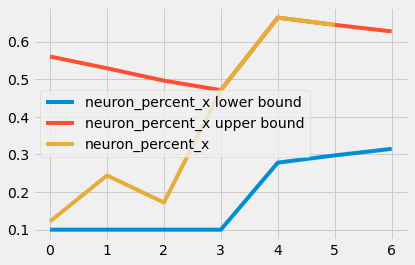

In [108]:
# example neuron_percent_x-bound shrinking
neuron_percent_x_min_bound = [b[6][0] for b in bounds_transformer.bounds]
neuron_percent_x_max_bound = [b[6][1] for b in bounds_transformer.bounds]
neuron_percent_x = [neuron_percent_x[6] for neuron_percent_x in mutating_optimizer.space.params]

plt.plot(neuron_percent_x_min_bound[1:], label='neuron_percent_x lower bound')
plt.plot(neuron_percent_x_max_bound[1:], label='neuron_percent_x upper bound')
plt.plot(neuron_percent_x[1:], label='neuron_percent_x')
plt.legend()

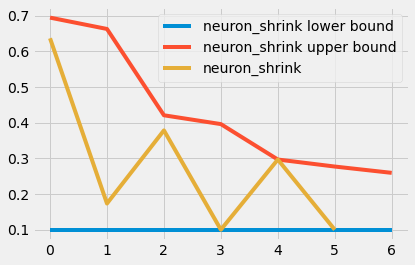

In [109]:
# example neuron_shrink-bound shrinking
neuron_shrink_min_bound = [b[7][0] for b in bounds_transformer.bounds]
neuron_shrink_max_bound = [b[7][1] for b in bounds_transformer.bounds]
neuron_shrink = [neuron_shrink[7] for neuron_shrink in mutating_optimizer.space.params]

plt.plot(neuron_shrink_min_bound[1:], label='neuron_shrink lower bound')
plt.plot(neuron_shrink_max_bound[1:], label='neuron_shrink upper bound')
plt.plot(neuron_shrink[1:], label='neuron_shrink')
plt.legend()

## Run mutated optimizer with lower history_days bounds

### Find out a history_days bound that doesnt take too much time

In [86]:
mutating_optimizer.probe(  # only folowing parameters will get tested
    params={
    'dropout_rate': 0.2,
#     'epochs': (3, 20),
    'first_by_all_layers_ratio': 0.2,
    'history_days': 100,
    'layer_no_max': 10,
#     'learning_rate': (0.0001, 0.15),
    'neuron_count_min': 5,
    'neuron_percent_x': 0.6,
    'neuron_shrink': 0.4,   
#     'batch_size': (32, 128)
    },
    lazy=True,
)

start_time = time.time()
mutating_optimizer.maximize(
    init_points=0,
    n_iter=0,
)
time_took = time.time() - start_time
print(f"Total runtime: {datetime.timedelta(seconds=time_took)}")

|   iter    |  target   | dropou... | first_... | histor... | layer_... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------
no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 3
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 100, 60)           14880     
_________________________________________________________________
Dropout

KeyboardInterrupt: 

### Run mutated Optimizer

In [88]:
# Bounded region of parameter space
pbounds_for_contract = {
    'dropout_rate': (0, 0.499),
#     'epochs': (3, 20),
    'first_by_all_layers_ratio': (0.1, 0.9),
    'history_days': (20, 150),
    'layer_no_max': (4, 20),
#     'learning_rate': (0.0001, 0.15),
    'neuron_count_min': (3, 10),
    'neuron_percent_x': (0.1, 0.9),
    'neuron_shrink': (0.1, 0.9),   
#     'batch_size': (32, 128)
}

bounds_transformer = SequentialDomainReductionTransformer()

mutating_optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds_for_contract,
    verbose=2,
    random_state=1,
    bounds_transformer=bounds_transformer
)


In [89]:
start_time = time.time()
mutating_optimizer.maximize(
    init_points=3,
    n_iter=10,
)
time_took = time.time() - start_time

print(f"Total runtime: {datetime.timedelta(seconds=time_took)}")
print(optimizer.max)  # is the wrong optimizer printed here

|   iter    |  target   | dropou... | first_... | histor... | layer_... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------
no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 1
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer_1 (Dense)        (None, 3)                 63        
_________________________________________________________________
Dropout

34/34 [==============================] - 17s 305ms/step - loss: 0.3771 - accuracy: 0.4972 - val_loss: 0.3508 - val_accuracy: 0.5064
Epoch 2/20
34/34 [==============================] - 10s 293ms/step - loss: 0.3371 - accuracy: 0.4986 - val_loss: 0.3187 - val_accuracy: 0.5064
Epoch 3/20
34/34 [==============================] - 10s 288ms/step - loss: 0.3060 - accuracy: 0.4986 - val_loss: 0.2896 - val_accuracy: 0.5064
Epoch 4/20
34/34 [==============================] - 9s 280ms/step - loss: 0.2785 - accuracy: 0.4986 - val_loss: 0.2635 - val_accuracy: 0.5064
Epoch 5/20
34/34 [==============================] - 10s 300ms/step - loss: 0.2533 - accuracy: 0.4984 - val_loss: 0.2402 - val_accuracy: 0.5064
Epoch 6/20
34/34 [==============================] - 9s 280ms/step - loss: 0.2311 - accuracy: 0.4986 - val_loss: 0.2195 - val_accuracy: 0.5064
Epoch 7/20
34/34 [==============================] - 11s 311ms/step - loss: 0.2113 - accuracy: 0.4986 - val_loss: 0.2011 - val_accuracy: 0.5064
Epoch 8/20
3

35/35 [==============================] - 10s 167ms/step - loss: 0.3714 - accuracy: 0.5057 - val_loss: 0.3501 - val_accuracy: 0.4807
Epoch 2/20
35/35 [==============================] - 5s 155ms/step - loss: 0.3354 - accuracy: 0.5046 - val_loss: 0.3171 - val_accuracy: 0.4807
Epoch 3/20
35/35 [==============================] - 6s 167ms/step - loss: 0.3039 - accuracy: 0.4949 - val_loss: 0.2874 - val_accuracy: 0.5193
Epoch 4/20
35/35 [==============================] - 5s 155ms/step - loss: 0.2755 - accuracy: 0.4915 - val_loss: 0.2609 - val_accuracy: 0.4807
Epoch 5/20
35/35 [==============================] - 5s 154ms/step - loss: 0.2501 - accuracy: 0.5055 - val_loss: 0.2370 - val_accuracy: 0.5193
Epoch 6/20
35/35 [==============================] - 5s 156ms/step - loss: 0.2275 - accuracy: 0.4949 - val_loss: 0.2160 - val_accuracy: 0.5193
Epoch 7/20
35/35 [==============================] - 6s 158ms/step - loss: 0.2075 - accuracy: 0.4949 - val_loss: 0.1975 - val_accuracy: 0.5193
Epoch 8/20
35/35

no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 15
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 74, 7)             252       
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 74, 7)             0         
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 74, 6)             336       
____________________________

Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 74, 7)             252       
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 74, 7)             0         
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 74, 6)             336       
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 74, 6)             0         
_________________________________________________________________
LSTM_Layer_3 (LSTM)          (None, 74, 5)             240       
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 74, 5)             0         
_________________________________________________________________
LSTM_Layer_4 (LSTM)          (None, 74, 4

35/35 [==============================] - 17s 253ms/step - loss: 0.3632 - accuracy: 0.4999 - val_loss: 0.3220 - val_accuracy: 0.5064
Epoch 2/20
35/35 [==============================] - 8s 226ms/step - loss: 0.3108 - accuracy: 0.5049 - val_loss: 0.2680 - val_accuracy: 0.5064
Epoch 3/20
35/35 [==============================] - 8s 227ms/step - loss: 0.2631 - accuracy: 0.5045 - val_loss: 0.2207 - val_accuracy: 0.5064
Epoch 4/20
35/35 [==============================] - 8s 228ms/step - loss: 0.2340 - accuracy: 0.4898 - val_loss: 0.1919 - val_accuracy: 0.5064
Epoch 5/20
35/35 [==============================] - 8s 225ms/step - loss: 0.2073 - accuracy: 0.4992 - val_loss: 0.1691 - val_accuracy: 0.5064
Epoch 6/20
35/35 [==============================] - 8s 223ms/step - loss: 0.1923 - accuracy: 0.4891 - val_loss: 0.1548 - val_accuracy: 0.5064 - loss: 0.193
Epoch 7/20
35/35 [==============================] - 8s 222ms/step - loss: 0.1791 - accuracy: 0.5187 - val_loss: 0.1420 - val_accuracy: 0.5064
Ep

35/35 [==============================] - 25s 406ms/step - loss: 0.4330 - accuracy: 0.4948 - val_loss: 0.3122 - val_accuracy: 0.5092
Epoch 2/20
35/35 [==============================] - 13s 370ms/step - loss: 0.3050 - accuracy: 0.5026 - val_loss: 0.2552 - val_accuracy: 0.5092
Epoch 3/20
35/35 [==============================] - 13s 373ms/step - loss: 0.2625 - accuracy: 0.4964 - val_loss: 0.2133 - val_accuracy: 0.4908
Epoch 4/20
35/35 [==============================] - 13s 370ms/step - loss: 0.2345 - accuracy: 0.5026 - val_loss: 0.1868 - val_accuracy: 0.4908
Epoch 5/20
35/35 [==============================] - 13s 381ms/step - loss: 0.2157 - accuracy: 0.4969 - val_loss: 0.1697 - val_accuracy: 0.4908
Epoch 6/20
35/35 [==============================] - 13s 378ms/step - loss: 0.1964 - accuracy: 0.5100 - val_loss: 0.1559 - val_accuracy: 0.4908
Epoch 7/20
35/35 [==============================] - 13s 370ms/step - loss: 0.1837 - accuracy: 0.5008 - val_loss: 0.1458 - val_accuracy: 0.4908
Epoch 8/20

Epoch 19/20
35/35 [==============================] - 9s 250ms/step - loss: 0.1035 - accuracy: 0.5048 - val_loss: 0.1029 - val_accuracy: 0.4798
Epoch 20/20
35/35 [==============================] - 9s 251ms/step - loss: 0.1013 - accuracy: 0.4966 - val_loss: 0.1010 - val_accuracy: 0.4798
|  8        | -0.1024   |  0.1322   |  0.9      |  72.2     |  11.0     |  3.717    |  0.1      |  0.9      |
no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 5
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 

Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 72, 33)            4620      
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 72, 33)            0         
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 18)                3744      
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 18)                0         
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 10)                190       
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 10)                0         
_________________________________________________________________
Dense_Layer_4 (Dense)        (None, 5)   

35/35 [==============================] - 11s 155ms/step - loss: 0.3541 - accuracy: 0.5021 - val_loss: 0.3082 - val_accuracy: 0.5225
Epoch 2/20
35/35 [==============================] - 5s 140ms/step - loss: 0.2878 - accuracy: 0.4947 - val_loss: 0.2289 - val_accuracy: 0.5225
Epoch 3/20
35/35 [==============================] - 5s 137ms/step - loss: 0.2409 - accuracy: 0.4979 - val_loss: 0.1875 - val_accuracy: 0.5225
Epoch 4/20
35/35 [==============================] - 5s 137ms/step - loss: 0.2124 - accuracy: 0.4966 - val_loss: 0.1632 - val_accuracy: 0.5225
Epoch 5/20
35/35 [==============================] - 5s 148ms/step - loss: 0.1933 - accuracy: 0.4995 - val_loss: 0.1482 - val_accuracy: 0.5225
Epoch 6/20
35/35 [==============================] - 5s 141ms/step - loss: 0.1780 - accuracy: 0.4972 - val_loss: 0.1366 - val_accuracy: 0.5225
Epoch 7/20
35/35 [==============================] - 5s 138ms/step - loss: 0.1648 - accuracy: 0.4998 - val_loss: 0.1280 - val_accuracy: 0.5225
Epoch 8/20
35/35

no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 3
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 71, 49)            9996      
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 71, 49)            0         
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 16)                4224      
_____________________________

Epoch 13/20
35/35 [==============================] - 8s 239ms/step - loss: 0.1164 - accuracy: 0.4962 - val_loss: 0.0974 - val_accuracy: 0.4945
Epoch 14/20
35/35 [==============================] - 8s 242ms/step - loss: 0.1139 - accuracy: 0.5070 - val_loss: 0.0962 - val_accuracy: 0.4945
Epoch 15/20
35/35 [==============================] - 9s 257ms/step - loss: 0.1112 - accuracy: 0.4992 - val_loss: 0.0958 - val_accuracy: 0.5257
Epoch 16/20
35/35 [==============================] - 9s 246ms/step - loss: 0.1105 - accuracy: 0.4884 - val_loss: 0.0961 - val_accuracy: 0.5248
Epoch 17/20
35/35 [==============================] - 8s 242ms/step - loss: 0.1089 - accuracy: 0.5008 - val_loss: 0.0951 - val_accuracy: 0.5312
Epoch 18/20
35/35 [==============================] - 9s 247ms/step - loss: 0.1075 - accuracy: 0.4909 - val_loss: 0.0953 - val_accuracy: 0.5147
Epoch 19/20
35/35 [==============================] - 9s 247ms/step - loss: 0.1062 - accuracy: 0.5114 - val_loss: 0.0943 - val_accuracy: 0.5128

In [39]:
print(mutating_optimizer.max)

{'target': -0.09384047477948629, 'params': {'dropout_rate': 0.0, 'first_by_all_layers_ratio': 0.4561405521089625, 'history_days': 70.91989593362982, 'layer_no_max': 14.121356230957268, 'neuron_count_min': 3.0, 'neuron_percent_x': 0.5853289623888028, 'neuron_shrink': 0.43280230165008265}}


### Analyze Results

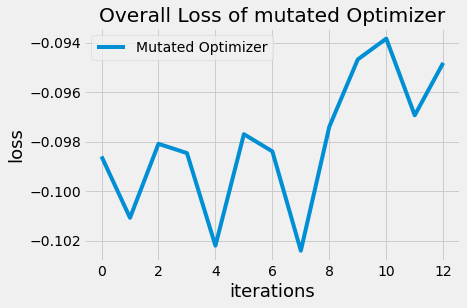

In [42]:
#
plt.style.use("fivethirtyeight")
plt.title("Overall Loss of mutated Optimizer")
plt.plot(mutating_optimizer.space.target, label='Mutated Optimizer')
plt.xlabel("iterations", fontsize=18)
plt.ylabel("loss", fontsize=18)
plt.legend()
plt.show()

In [34]:
# transformed bounds ofer iterations are loged in bounds_transformer.bounds
print("Bounds:")
for idx, val in enumerate(bounds_transformer.bounds):
    print(
        f"chosen bounds over iterations of parameter{idx}:\
        \n{val}\n"
    )
    
# don't know why this iterable has 14 elements here and only 7 later

Bounds:
chosen bounds over iterations of parameter0:        
[[0.00e+00 4.99e-01]
 [1.00e-01 9.00e-01]
 [2.00e+01 1.50e+02]
 [4.00e+00 2.00e+01]
 [3.00e+00 1.00e+01]
 [1.00e-01 9.00e-01]
 [1.00e-01 9.00e-01]]

chosen bounds over iterations of parameter1:        
[[8.06928133e-03 4.08118679e-01]
 [3.61072574e-01 9.00000000e-01]
 [2.00000000e+01 6.94156122e+01]
 [4.00000000e+00 1.51591872e+01]
 [3.00000000e+00 6.73865580e+00]
 [1.00000000e-01 4.81564420e-01]
 [1.00000000e-01 5.60458578e-01]]

chosen bounds over iterations of parameter2:        
[[2.80717512e-02 3.88116209e-01]
 [3.92591277e-01 9.00000000e-01]
 [2.00000000e+01 6.44755378e+01]
 [4.00000000e+00 1.45270006e+01]
 [3.00000000e+00 6.46751934e+00]
 [1.00000000e-01 4.50795065e-01]
 [1.00000000e-01 5.29313537e-01]]

chosen bounds over iterations of parameter3:        
[[0.00000000e+00 1.65965037e-01]
 [3.83066801e-01 8.89681215e-01]
 [3.69467599e+01 1.11552489e+02]
 [8.02341155e+00 1.78546630e+01]
 [3.00000000e+00 6.17668473e+00]


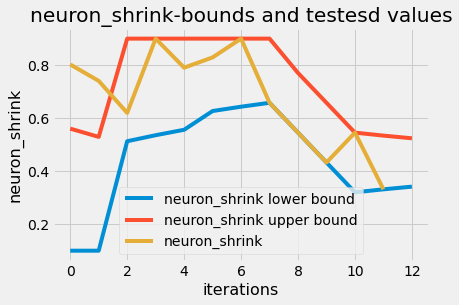

In [28]:
# example neuron_shrink-bound shrinking
neuron_shrink_min_bound = [b[-1][0] for b in bounds_transformer.bounds]
neuron_shrink_max_bound = [b[-1][1] for b in bounds_transformer.bounds]
neuron_shrink = [neuron_shrink[-1] for neuron_shrink in mutating_optimizer.space.params]

plt.title("neuron_shrink-bounds and testesd values")
plt.plot(neuron_shrink_min_bound[1:], label='neuron_shrink lower bound')
plt.plot(neuron_shrink_max_bound[1:], label='neuron_shrink upper bound')
plt.plot(neuron_shrink[1:], label='neuron_shrink')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("neuron_shrink", fontsize=16)
plt.legend()

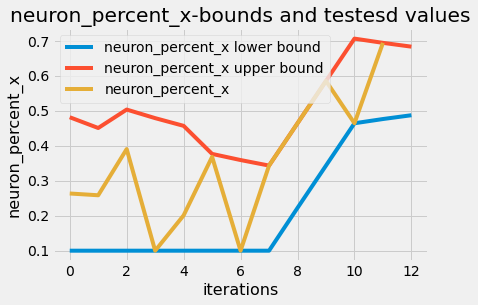

In [27]:
# example neuron_percent_x-bound shrinking
neuron_percent_x_min_bound = [b[-2][0] for b in bounds_transformer.bounds]
neuron_percent_x_max_bound = [b[-2][1] for b in bounds_transformer.bounds]
neuron_percent_x = [neuron_percent_x[-2] for neuron_percent_x in mutating_optimizer.space.params]

plt.title("neuron_percent_x-bounds and testesd values")
plt.plot(neuron_percent_x_min_bound[1:], label='neuron_percent_x lower bound')
plt.plot(neuron_percent_x_max_bound[1:], label='neuron_percent_x upper bound')
plt.plot(neuron_percent_x[1:], label='neuron_percent_x')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("neuron_percent_x", fontsize=16)
plt.legend()

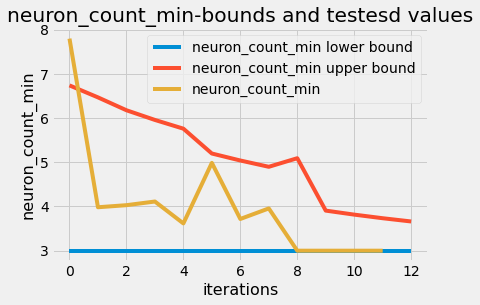

In [26]:
# example neuron_count_min-bound shrinking
neuron_count_min_min_bound = [b[-3][0] for b in bounds_transformer.bounds]
neuron_count_min_max_bound = [b[-3][1] for b in bounds_transformer.bounds]
neuron_count_min = [neuron_count_min[-3] for neuron_count_min in mutating_optimizer.space.params]

plt.title("neuron_count_min-bounds and testesd values")
plt.plot(neuron_count_min_min_bound[1:], label='neuron_count_min lower bound')
plt.plot(neuron_count_min_max_bound[1:], label='neuron_count_min upper bound')
plt.plot(neuron_count_min[1:], label='neuron_count_min')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("neuron_count_min", fontsize=16)
plt.legend()

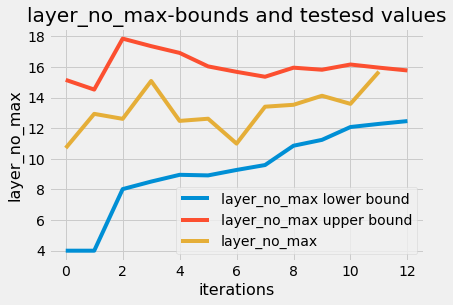

In [25]:
# example layer_no_max-bound shrinking
layer_no_max_min_bound = [b[-4][0] for b in bounds_transformer.bounds]
layer_no_max_max_bound = [b[-4][1] for b in bounds_transformer.bounds]
layer_no_max = [layer_no_max[-4] for layer_no_max in mutating_optimizer.space.params]

plt.title("layer_no_max-bounds and testesd values")
plt.plot(layer_no_max_min_bound[1:], label='layer_no_max lower bound')
plt.plot(layer_no_max_max_bound[1:], label='layer_no_max upper bound')
plt.plot(layer_no_max[1:], label='layer_no_max')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("layer_no_max", fontsize=16)
plt.legend()

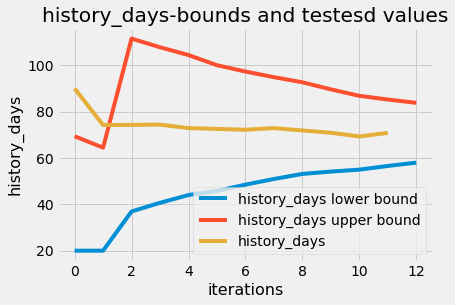

In [24]:
# example history_days-bound shrinking
history_days_min_bound = [b[-5][0] for b in bounds_transformer.bounds]
history_days_max_bound = [b[-5][1] for b in bounds_transformer.bounds]
history_days = [history_days[-5] for history_days in mutating_optimizer.space.params]

plt.title("history_days-bounds and testesd values")
plt.plot(history_days_min_bound[1:], label='history_days lower bound')
plt.plot(history_days_max_bound[1:], label='history_days upper bound')
plt.plot(history_days[1:], label='history_days')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("history_days", fontsize=16)
plt.legend()

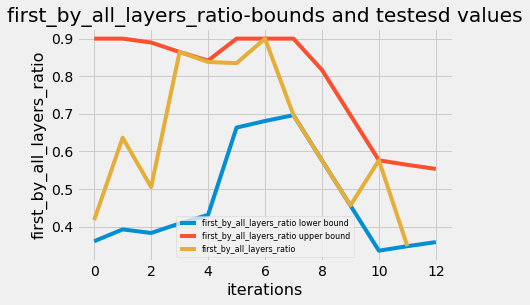

In [23]:
# example first_by_all_layers_ratio-bound shrinking
first_by_all_layers_ratio_min_bound = [b[-6][0] for b in bounds_transformer.bounds]
first_by_all_layers_ratio_max_bound = [b[-6][1] for b in bounds_transformer.bounds]
first_by_all_layers_ratio = [
    first_by_all_layers_ratio[-6] for first_by_all_layers_ratio\
    in mutating_optimizer.space.params
]

plt.title("first_by_all_layers_ratio-bounds and testesd values")
plt.plot(first_by_all_layers_ratio_min_bound[1:], label='first_by_all_layers_ratio lower bound')
plt.plot(first_by_all_layers_ratio_max_bound[1:], label='first_by_all_layers_ratio upper bound')
plt.plot(first_by_all_layers_ratio[1:], label='first_by_all_layers_ratio')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("first_by_all_layers_ratio", fontsize=16)
plt.legend(fontsize=8)

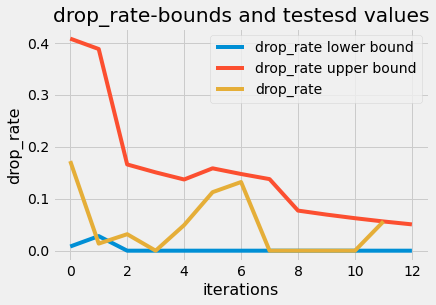

In [31]:
# example drop_rate-bound shrinking
drop_rate_min_bound = [b[-7][0] for b in bounds_transformer.bounds]
drop_rate_max_bound = [b[-7][1] for b in bounds_transformer.bounds]
drop_rate = [drop_rate[-7] for drop_rate in mutating_optimizer.space.params]

plt.title("drop_rate-bounds and testesd values")
plt.plot(drop_rate_min_bound[1:], label='drop_rate lower bound')
plt.plot(drop_rate_max_bound[1:], label='drop_rate upper bound')
plt.plot(drop_rate[1:], label='drop_rate')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("drop_rate", fontsize=16)
plt.legend()

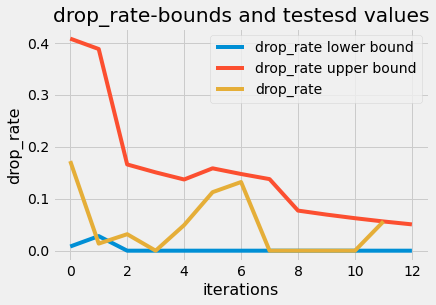

In [40]:
# example drop_rate-bound shrinking
drop_rate_min_bound = [b[0][0] for b in bounds_transformer.bounds]
drop_rate_max_bound = [b[0][1] for b in bounds_transformer.bounds]
drop_rate = [drop_rate[0] for drop_rate in mutating_optimizer.space.params]

plt.title("drop_rate-bounds and testesd values")
plt.plot(drop_rate_min_bound[1:], label='drop_rate lower bound')
plt.plot(drop_rate_max_bound[1:], label='drop_rate upper bound')
plt.plot(drop_rate[1:], label='drop_rate')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("drop_rate", fontsize=16)
plt.legend()
# same output as index -7 => bounds_transformer.bounds has only 7 elements

## Run mutated Optimizer with adapted bounds

### Test Duration of 200 history_days

In [45]:
mutating_optimizer.probe(
    params={
        'dropout_rate': 0.2,
        'first_by_all_layers_ratio': 0.6,
        'history_days': 200,
        'layer_no_max': 15,
        'neuron_count_min': 6,
        'neuron_percent_x': 0.7,
        'neuron_shrink': 0.6
    },
    lazy=True,
)
mutating_optimizer.maximize(init_points=0, n_iter=0)

|   iter    |  target   | dropou... | first_... | histor... | layer_... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------
no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 7
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 200, 140)          79520     
_________________________________________________________________
Dropout

KeyboardInterrupt: 

### Set new Parameters

In [46]:
# Bounded region of parameter space
mutating_optimizer.set_bounds(
    new_bounds={
        'dropout_rate': (0, 0.3),  # before: (0, 0.499)
        'first_by_all_layers_ratio': (0.3, 0.9),  # before: (0.1, 0.9)
        'history_days': (45, 200),  # before: (20, 150)
        'layer_no_max': (9, 20),  # before: (4, 20) still high due to higher history_days
        'neuron_count_min': (3, 10),  # before: (3, 10) same due to higher history_days
        'neuron_percent_x': (0.1, 0.8),  # before: (0.1, 0.9)
        'neuron_shrink': (0.1, 0.9)  # before: (0.1, 0.9) same due to heterogenous results
    }
)

### Run mutated Optimizer

In [47]:
start_time = time.time()
mutating_optimizer.maximize(
    init_points=3,
    n_iter=10,
)
time_took = time.time() - start_time

print(f"Total runtime: {datetime.timedelta(seconds=time_took)}")
print(mutating_optimizer.max)  # is the wrong optimizer printed here

|   iter    |  target   | dropou... | first_... | histor... | layer_... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------
no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 1
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer_1 (Dense)        (None, 24)                3672      
_________________________________________________________________
Dropout

Epoch 10/20
35/35 [==============================] - 5s 157ms/step - loss: 0.1275 - accuracy: 0.5080 - val_loss: 0.0985 - val_accuracy: 0.4808
Epoch 11/20
35/35 [==============================] - 6s 159ms/step - loss: 0.1239 - accuracy: 0.5119 - val_loss: 0.0971 - val_accuracy: 0.4808
Epoch 12/20
35/35 [==============================] - 6s 162ms/step - loss: 0.1203 - accuracy: 0.4961 - val_loss: 0.0949 - val_accuracy: 0.4808
Epoch 13/20
35/35 [==============================] - 5s 143ms/step - loss: 0.1177 - accuracy: 0.4849 - val_loss: 0.0938 - val_accuracy: 0.4808
Epoch 14/20
35/35 [==============================] - 5s 135ms/step - loss: 0.1156 - accuracy: 0.5133 - val_loss: 0.0924 - val_accuracy: 0.4808
Epoch 15/20
35/35 [==============================] - 5s 136ms/step - loss: 0.1125 - accuracy: 0.5021 - val_loss: 0.0921 - val_accuracy: 0.4808
Epoch 16/20
35/35 [==============================] - 5s 156ms/step - loss: 0.1106 - accuracy: 0.5046 - val_loss: 0.0912 - val_accuracy: 0.4808

Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 174, 138)          77280     
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 174, 138)          0         
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 174, 96)           90240     
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 174, 96)           0         
_________________________________________________________________
LSTM_Layer_3 (LSTM)          (None, 174, 67)           43952     
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 174, 67)           0         
_________________________________________________________________
LSTM_Layer_4 (LSTM)          (None, 47)  

ValueError: LBFGSB - one of the lower bounds is greater than an upper bound.

### Try again with new variables

In [2]:
# Bounded region of parameter space
new_pbounds = {
    'dropout_rate': (0, 0.3),  # before: (0, 0.499)
    'first_by_all_layers_ratio': (0.3, 0.9),  # before: (0.1, 0.9)
    'history_days': (45, 200),  # before: (20, 150)
    'layer_no_max': (9, 20),  # before: (4, 20) still high due to higher history_days
    'neuron_count_min': (3, 10),  # before: (3, 10) same due to higher history_days
    'neuron_percent_x': (0.1, 0.8),  # before: (0.1, 0.9)
    'neuron_shrink': (0.1, 0.9)  # before: (0.1, 0.9) same due to heterogenous results
}

new_bounds_transformer = SequentialDomainReductionTransformer()

new_mutating_optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=new_pbounds,
    verbose=2,
    random_state=1,
    bounds_transformer=new_bounds_transformer
)

start_time = time.time()
new_mutating_optimizer.maximize(
    init_points=3,
    n_iter=10,
)
time_took = time.time() - start_time

print(f"Total runtime: {datetime.timedelta(seconds=time_took)}")
print(new_mutating_optimizer.max)

|   iter    |  target   | dropou... | first_... | histor... | layer_... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------
no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
resulting_layer_no: 1
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer_1 (Dense)        (None, 7)                 322       
_________________________________________________________________
Dropout

34/34 [==============================] - 29s 580ms/step - loss: 0.3440 - accuracy: 0.4986 - val_loss: 0.2834 - val_accuracy: 0.5264
Epoch 2/20
34/34 [==============================] - 19s 569ms/step - loss: 0.2753 - accuracy: 0.5060 - val_loss: 0.2239 - val_accuracy: 0.5264
Epoch 3/20
34/34 [==============================] - 19s 566ms/step - loss: 0.2368 - accuracy: 0.5167 - val_loss: 0.1894 - val_accuracy: 0.5264
Epoch 4/20
34/34 [==============================] - 21s 619ms/step - loss: 0.2136 - accuracy: 0.4986 - val_loss: 0.1673 - val_accuracy: 0.5264
Epoch 5/20
34/34 [==============================] - 19s 570ms/step - loss: 0.1954 - accuracy: 0.4956 - val_loss: 0.1537 - val_accuracy: 0.5264
Epoch 6/20
34/34 [==============================] - 20s 573ms/step - loss: 0.1830 - accuracy: 0.4914 - val_loss: 0.1428 - val_accuracy: 0.5264
Epoch 7/20
34/34 [==============================] - 20s 576ms/step - loss: 0.1738 - accuracy: 0.5063 - val_loss: 0.1359 - val_accuracy: 0.5264
Epoch 8/20

Epoch 17/20
34/34 [==============================] - 14s 397ms/step - loss: 0.1135 - accuracy: 0.4908 - val_loss: 0.1017 - val_accuracy: 0.5037
Epoch 18/20
34/34 [==============================] - 13s 391ms/step - loss: 0.1104 - accuracy: 0.5000 - val_loss: 0.1001 - val_accuracy: 0.5037
Epoch 19/20
34/34 [==============================] - 13s 392ms/step - loss: 0.1087 - accuracy: 0.5016 - val_loss: 0.0988 - val_accuracy: 0.5037
Epoch 20/20
34/34 [==============================] - 13s 393ms/step - loss: 0.1060 - accuracy: 0.4917 - val_loss: 0.0978 - val_accuracy: 0.5037
no nan or infinite value in ar_nan_x_train of SPLIT No 2
no nan or infinite value in ar_nan_x_test of SPLIT No 2
no nan or infinite value in ar_inf_x_train of SPLIT No 2
no nan or infinite value in ar_inf_x_test of SPLIT No 2
no nan or infinite value in ar_nan_y_train of SPLIT No 2
no nan or infinite value in ar_nan_y_test of SPLIT No 2
no nan or infinite value in ar_inf_y_train of SPLIT No 2
no nan or infinite value in 

Epoch 4/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1736 - accuracy: 0.4995 - val_loss: 0.1407 - val_accuracy: 0.5114
Epoch 5/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1539 - accuracy: 0.5080 - val_loss: 0.1222 - val_accuracy: 0.5205
Epoch 6/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1410 - accuracy: 0.4957 - val_loss: 0.1115 - val_accuracy: 0.5059
Epoch 7/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1310 - accuracy: 0.4950 - val_loss: 0.1056 - val_accuracy: 0.5068
Epoch 8/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1260 - accuracy: 0.4797 - val_loss: 0.1014 - val_accuracy: 0.5096
Epoch 9/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1213 - accuracy: 0.5046 - val_loss: 0.0990 - val_accuracy: 0.5068
Epoch 10/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1197 - accuracy: 0.4904 - val_loss: 0.0984 - val_accuracy: 0.5050
Epoch 11/20
35/35 [

35/35 [==============================] - 1s 10ms/step - loss: 0.3033 - accuracy: 0.5085 - val_loss: 0.2442 - val_accuracy: 0.4904
Epoch 2/20
35/35 [==============================] - 0s 5ms/step - loss: 0.2467 - accuracy: 0.5101 - val_loss: 0.2126 - val_accuracy: 0.4877
Epoch 3/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2176 - accuracy: 0.4989 - val_loss: 0.1850 - val_accuracy: 0.5160
Epoch 4/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1896 - accuracy: 0.5043 - val_loss: 0.1609 - val_accuracy: 0.5142
Epoch 5/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1679 - accuracy: 0.5139 - val_loss: 0.1419 - val_accuracy: 0.5151
Epoch 6/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1512 - accuracy: 0.5094 - val_loss: 0.1266 - val_accuracy: 0.5123
Epoch 7/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1349 - accuracy: 0.5050 - val_loss: 0.1154 - val_accuracy: 0.5142
Epoch 8/20
35/35 [============

35/35 [==============================] - 1s 9ms/step - loss: 0.3751 - accuracy: 0.4961 - val_loss: 0.3448 - val_accuracy: 0.5146
Epoch 2/20
35/35 [==============================] - 0s 3ms/step - loss: 0.3366 - accuracy: 0.4954 - val_loss: 0.3121 - val_accuracy: 0.5146
Epoch 3/20
35/35 [==============================] - 0s 3ms/step - loss: 0.3049 - accuracy: 0.4954 - val_loss: 0.2827 - val_accuracy: 0.5146
Epoch 4/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2765 - accuracy: 0.4954 - val_loss: 0.2563 - val_accuracy: 0.5146
Epoch 5/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2511 - accuracy: 0.4954 - val_loss: 0.2328 - val_accuracy: 0.5146
Epoch 6/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2285 - accuracy: 0.4954 - val_loss: 0.2121 - val_accuracy: 0.5146
Epoch 7/20
35/35 [==============================] - 0s 3ms/step - loss: 0.2086 - accuracy: 0.4954 - val_loss: 0.1939 - val_accuracy: 0.5146
Epoch 8/20
35/35 [=============

35/35 [==============================] - 1s 9ms/step - loss: 0.3508 - accuracy: 0.5031 - val_loss: 0.2973 - val_accuracy: 0.4922
Epoch 2/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2843 - accuracy: 0.5006 - val_loss: 0.2436 - val_accuracy: 0.4922
Epoch 3/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2392 - accuracy: 0.5086 - val_loss: 0.2024 - val_accuracy: 0.4922
Epoch 4/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2059 - accuracy: 0.5010 - val_loss: 0.1773 - val_accuracy: 0.4821
Epoch 5/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1838 - accuracy: 0.4992 - val_loss: 0.1592 - val_accuracy: 0.4766
Epoch 6/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1632 - accuracy: 0.5047 - val_loss: 0.1434 - val_accuracy: 0.4812
Epoch 7/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1483 - accuracy: 0.4955 - val_loss: 0.1298 - val_accuracy: 0.4793
Epoch 8/20
35/35 [=============

35/35 [==============================] - 1s 9ms/step - loss: 0.2997 - accuracy: 0.5018 - val_loss: 0.2409 - val_accuracy: 0.5083
Epoch 2/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2320 - accuracy: 0.5002 - val_loss: 0.2049 - val_accuracy: 0.5257
Epoch 3/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1979 - accuracy: 0.5163 - val_loss: 0.1727 - val_accuracy: 0.5229
Epoch 4/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.5158 - val_loss: 0.1458 - val_accuracy: 0.5156
Epoch 5/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1414 - accuracy: 0.5191 - val_loss: 0.1254 - val_accuracy: 0.4917
Epoch 6/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1212 - accuracy: 0.5044 - val_loss: 0.1100 - val_accuracy: 0.5183
Epoch 7/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1102 - accuracy: 0.5018 - val_loss: 0.1012 - val_accuracy: 0.5055
Epoch 8/20
35/35 [=============

(4360, 70, 1) (4360, 2) (1090, 70, 1) (1090, 2)
Epoch 1/20
35/35 [==============================] - 5s 74ms/step - loss: 0.3193 - accuracy: 0.5078 - val_loss: 0.2078 - val_accuracy: 0.4688
Epoch 2/20
35/35 [==============================] - 2s 70ms/step - loss: 0.1485 - accuracy: 0.5078 - val_loss: 0.1090 - val_accuracy: 0.46880.1486 - accuracy: 0.50
Epoch 3/20
35/35 [==============================] - 2s 67ms/step - loss: 0.1235 - accuracy: 0.5005 - val_loss: 0.1012 - val_accuracy: 0.4688
Epoch 4/20
35/35 [==============================] - 2s 69ms/step - loss: 0.1208 - accuracy: 0.4991 - val_loss: 0.0975 - val_accuracy: 0.4688
Epoch 5/20
35/35 [==============================] - 2s 66ms/step - loss: 0.1173 - accuracy: 0.5151 - val_loss: 0.0939 - val_accuracy: 0.4688
Epoch 6/20
35/35 [==============================] - 2s 70ms/step - loss: 0.1192 - accuracy: 0.5092 - val_loss: 0.0946 - val_accuracy: 0.4688
Epoch 7/20
35/35 [==============================] - 2s 66ms/step - loss: 0.1177 - a

Epoch 1/20
35/35 [==============================] - 4s 44ms/step - loss: 0.3652 - accuracy: 0.4968 - val_loss: 0.3345 - val_accuracy: 0.5059
Epoch 2/20
35/35 [==============================] - 1s 34ms/step - loss: 0.3101 - accuracy: 0.4979 - val_loss: 0.2846 - val_accuracy: 0.5059
Epoch 3/20
35/35 [==============================] - 1s 35ms/step - loss: 0.2669 - accuracy: 0.4970 - val_loss: 0.2452 - val_accuracy: 0.5059
Epoch 4/20
35/35 [==============================] - 1s 33ms/step - loss: 0.2333 - accuracy: 0.4904 - val_loss: 0.2124 - val_accuracy: 0.5059
Epoch 5/20
35/35 [==============================] - 1s 33ms/step - loss: 0.2033 - accuracy: 0.4957 - val_loss: 0.1821 - val_accuracy: 0.5059
Epoch 6/20
35/35 [==============================] - 1s 35ms/step - loss: 0.1753 - accuracy: 0.4954 - val_loss: 0.1526 - val_accuracy: 0.5059
Epoch 7/20
35/35 [==============================] - 1s 35ms/step - loss: 0.1476 - accuracy: 0.4973 - val_loss: 0.1279 - val_accuracy: 0.5059
Epoch 8/20
35

35/35 [==============================] - 1s 9ms/step - loss: 0.3040 - accuracy: 0.5026 - val_loss: 0.2336 - val_accuracy: 0.4973
Epoch 2/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2321 - accuracy: 0.4939 - val_loss: 0.1979 - val_accuracy: 0.5119
Epoch 3/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1949 - accuracy: 0.4932 - val_loss: 0.1684 - val_accuracy: 0.5101
Epoch 4/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1648 - accuracy: 0.4932 - val_loss: 0.1453 - val_accuracy: 0.5128
Epoch 5/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1424 - accuracy: 0.5145 - val_loss: 0.1269 - val_accuracy: 0.5064
Epoch 6/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1266 - accuracy: 0.5024 - val_loss: 0.1153 - val_accuracy: 0.5064
Epoch 7/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1142 - accuracy: 0.5072 - val_loss: 0.1060 - val_accuracy: 0.5128
Epoch 8/20
35/35 [=============

35/35 [==============================] - 1s 10ms/step - loss: 0.3207 - accuracy: 0.5065 - val_loss: 0.2372 - val_accuracy: 0.4712
Epoch 2/20
35/35 [==============================] - 0s 4ms/step - loss: 0.2192 - accuracy: 0.5058 - val_loss: 0.1932 - val_accuracy: 0.4868
Epoch 3/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1841 - accuracy: 0.5017 - val_loss: 0.1626 - val_accuracy: 0.4758
Epoch 4/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1517 - accuracy: 0.4990 - val_loss: 0.1366 - val_accuracy: 0.4868
Epoch 5/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1309 - accuracy: 0.5001 - val_loss: 0.1195 - val_accuracy: 0.4749
Epoch 6/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1159 - accuracy: 0.4994 - val_loss: 0.1081 - val_accuracy: 0.4922
Epoch 7/20
35/35 [==============================] - 0s 4ms/step - loss: 0.1070 - accuracy: 0.4951 - val_loss: 0.1012 - val_accuracy: 0.4858
Epoch 8/20
35/35 [============

### Result Analysis

In [12]:
plt.style.use("fivethirtyeight")

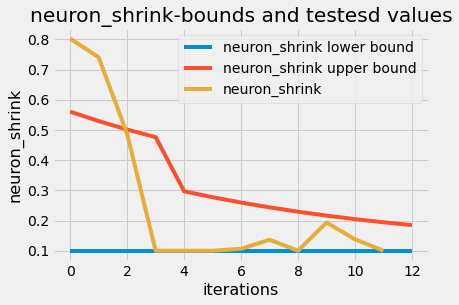

In [21]:
# example neuron_shrink-bound shrinking
neuron_shrink_min_bound = [b[-1][0] for b in new_bounds_transformer.bounds]
neuron_shrink_max_bound = [b[-1][1] for b in new_bounds_transformer.bounds]
neuron_shrink = [neuron_shrink[-1] for neuron_shrink in new_mutating_optimizer.space.params]

plt.title("neuron_shrink-bounds and testesd values")
plt.plot(neuron_shrink_min_bound[1:], label='neuron_shrink lower bound')
plt.plot(neuron_shrink_max_bound[1:], label='neuron_shrink upper bound')
plt.plot(neuron_shrink[1:], label='neuron_shrink')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("neuron_shrink", fontsize=16)
plt.legend()

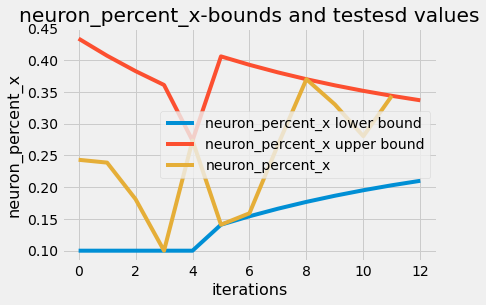

In [22]:
# example neuron_percent_x-bound shrinking
neuron_percent_x_min_bound = [b[-2][0] for b in new_bounds_transformer.bounds]
neuron_percent_x_max_bound = [b[-2][1] for b in new_bounds_transformer.bounds]
neuron_percent_x = [neuron_percent_x[-2] for neuron_percent_x in new_mutating_optimizer.space.params]

plt.title("neuron_percent_x-bounds and testesd values")
plt.plot(neuron_percent_x_min_bound[1:], label='neuron_percent_x lower bound')
plt.plot(neuron_percent_x_max_bound[1:], label='neuron_percent_x upper bound')
plt.plot(neuron_percent_x[1:], label='neuron_percent_x')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("neuron_percent_x", fontsize=16)
plt.legend()

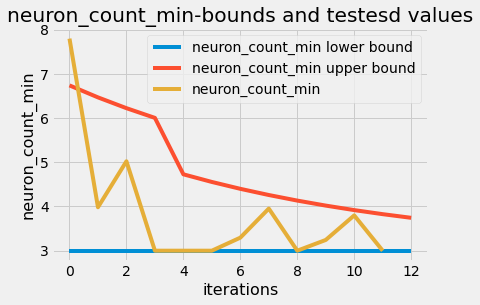

In [23]:
# example neuron_count_min-bound shrinking
neuron_count_min_min_bound = [b[-3][0] for b in new_bounds_transformer.bounds]
neuron_count_min_max_bound = [b[-3][1] for b in new_bounds_transformer.bounds]
neuron_count_min = [neuron_count_min[-3] for neuron_count_min in new_mutating_optimizer.space.params]

plt.title("neuron_count_min-bounds and testesd values")
plt.plot(neuron_count_min_min_bound[1:], label='neuron_count_min lower bound')
plt.plot(neuron_count_min_max_bound[1:], label='neuron_count_min upper bound')
plt.plot(neuron_count_min[1:], label='neuron_count_min')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("neuron_count_min", fontsize=16)
plt.legend()

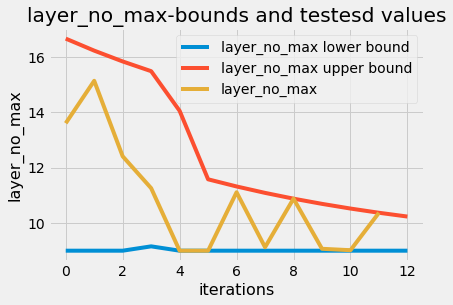

In [24]:
# example layer_no_max-bound shrinking
layer_no_max_min_bound = [b[-4][0] for b in new_bounds_transformer.bounds]
layer_no_max_max_bound = [b[-4][1] for b in new_bounds_transformer.bounds]
layer_no_max = [layer_no_max[-4] for layer_no_max in new_mutating_optimizer.space.params]

plt.title("layer_no_max-bounds and testesd values")
plt.plot(layer_no_max_min_bound[1:], label='layer_no_max lower bound')
plt.plot(layer_no_max_max_bound[1:], label='layer_no_max upper bound')
plt.plot(layer_no_max[1:], label='layer_no_max')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("layer_no_max", fontsize=16)
plt.legend()

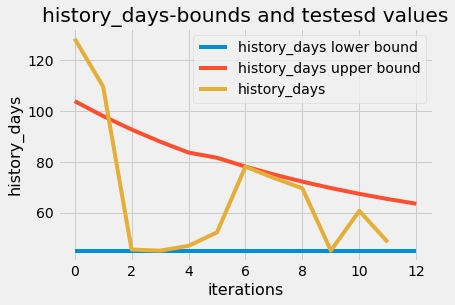

In [25]:
# example history_days-bound shrinking
history_days_min_bound = [b[-5][0] for b in new_bounds_transformer.bounds]
history_days_max_bound = [b[-5][1] for b in new_bounds_transformer.bounds]
history_days = [history_days[-5] for history_days in new_mutating_optimizer.space.params]

plt.title("history_days-bounds and testesd values")
plt.plot(history_days_min_bound[1:], label='history_days lower bound')
plt.plot(history_days_max_bound[1:], label='history_days upper bound')
plt.plot(history_days[1:], label='history_days')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("history_days", fontsize=16)
plt.legend()

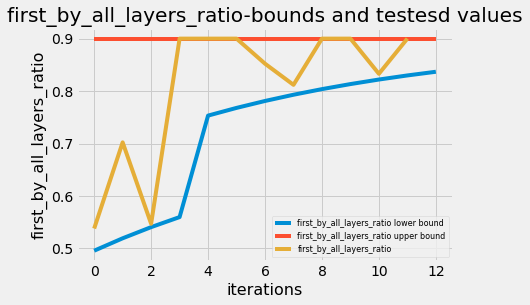

In [26]:
# example first_by_all_layers_ratio-bound shrinking
first_by_all_layers_ratio_min_bound = [b[-6][0] for b in new_bounds_transformer.bounds]
first_by_all_layers_ratio_max_bound = [b[-6][1] for b in new_bounds_transformer.bounds]
first_by_all_layers_ratio = [
    first_by_all_layers_ratio[-6] for first_by_all_layers_ratio\
    in new_mutating_optimizer.space.params
]

plt.title("first_by_all_layers_ratio-bounds and testesd values")
plt.plot(first_by_all_layers_ratio_min_bound[1:], label='first_by_all_layers_ratio lower bound')
plt.plot(first_by_all_layers_ratio_max_bound[1:], label='first_by_all_layers_ratio upper bound')
plt.plot(first_by_all_layers_ratio[1:], label='first_by_all_layers_ratio')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("first_by_all_layers_ratio", fontsize=16)
plt.legend(fontsize=8)

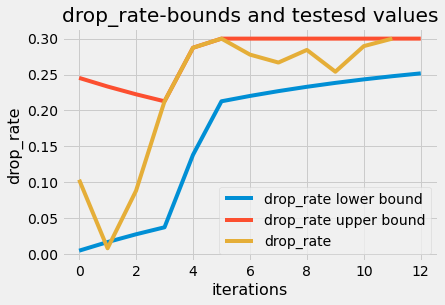

In [27]:
# example drop_rate-bound shrinking
drop_rate_min_bound = [b[-7][0] for b in new_bounds_transformer.bounds]
drop_rate_max_bound = [b[-7][1] for b in new_bounds_transformer.bounds]
drop_rate = [drop_rate[-7] for drop_rate in new_mutating_optimizer.space.params]

plt.title("drop_rate-bounds and testesd values")
plt.plot(drop_rate_min_bound[1:], label='drop_rate lower bound')
plt.plot(drop_rate_max_bound[1:], label='drop_rate upper bound')
plt.plot(drop_rate[1:], label='drop_rate')
plt.xlabel("iterations", fontsize=16)
plt.ylabel("drop_rate", fontsize=16)
plt.legend()

In [3]:
# save variables
import dill
dill.dump_session('ANN_floating_Buy_Sell_Recommendation_bayseian_optimized.db')

# Fit and evaluate Model with optimized parameters

## Parameters close to optimized values

### Create x & y, define parameters, create and fit model

In [78]:
# Create x and y; x = training and testing data (independent variable),
# y = traget (dependent) variable
x = []
y = []

# x = data of history_days days (interating forward)
# y = last value of history_days days

# index_rec_buy_sell_not_nan already was added bay creating the dataset
histroy_days = 70
for i in range(history_days, scaled_data.shape[0]):
    x.append(scaled_data[i - history_days:i, 0])
    y.append(
        # index_rec_buy_sell_not_nan has to be added because of index of df is used
        [df["Rec(Buy)"][df.index[i + index_rec_buy_sell_not_nan]],
         df["Rec(Sell)"][df.index[i + index_rec_buy_sell_not_nan]]]
    )
x = np.array(x)
y = np.array(y)

final_model = create_model(
    x, y,
    first_layer_type="LSTM", second_layer_type="Dense",
    neuron_percent_x=0.3, neuron_shrink=0.25, dropout_rate=0.287,
    neuron_count_min=4, layer_no_max=11,
    first_by_all_layers_ratio=0.8,
    activation_function_out=None, activation_function_rest="relu"
)
final_model.summary()

# define parameters
epochs = 100
batch_size = 128
loss_function = "mean_squared_error"
test_size = 0.2
optimizer = 'adam'
metrics = ['accuracy']

# Bootstrap
SPLITS = 2
boot = ShuffleSplit(n_splits=SPLITS, test_size=test_size)
    # test_size = 20% of x and y

# Loop through samples
for train, test in boot.split(x,y):
    # Split train and test
    x_train = x[train]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = y[train]
    x_test = x[test]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = y[test]

    # check if there are nan or infinite values

    # numpy_train.isnan(ar)     # True wherever nan
    # numpy_train.isinf(ar)     # True wherever pos-inf or neg-inf

    ar_nan_x_train = np.where(np.isnan(x_train))
    ar_nan_x_test = np.where(np.isnan(x_test))

    ar_inf_x_train = np.where(np.isinf(x_train))
    ar_inf_x_test = np.where(np.isinf(x_test))

    ar_nan_y_train = np.where(np.isnan(y_train))
    ar_nan_y_test = np.where(np.isnan(y_test))

    ar_inf_y_train = np.where(np.isinf(y_train))
    ar_inf_y_test = np.where(np.isinf(y_test))

    ar_nan_inf_string_list = [
        'ar_nan_x_train', 'ar_nan_x_test', 'ar_inf_x_train', 'ar_inf_x_test',
        'ar_nan_y_train', 'ar_nan_y_test', 'ar_inf_y_train', 'ar_inf_y_test'
    ]
    i = 0
    for j, k, l in [ar_nan_x_train, ar_nan_x_test, ar_inf_x_train, ar_inf_x_test]:
        # j, k, l are the 1st, 2nd and 3rd element of list element after "in"
        # works also without [] after in
        if (j.size and k.size and l.size) == 0:
            # np_array.size == 0 checks if array is empty
            print(
                f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
                f" of SPLIT No {current_SPLIT}"
            )
        else:
            print(
                f"{ar_nan_inf_string_list[i]}:\
                \n{j, k, l}"
            )
        i += 1

    for j, k in [ar_nan_y_train, ar_nan_y_test, ar_inf_y_train, ar_inf_y_test]:
        if (j.size and k.size) == 0:
            print(f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
                f" of SPLIT No {current_SPLIT}"
            )
        else:
            print(
                f"{ar_nan_inf_string_list[i]}:\
                \n{j, k}"
            )
        i += 1
    final_model.compile(
        loss=loss_function,
        optimizer=optimizer,
        metrics=metrics
    )
    final_model.fit(
        x_train, y_train, validation_data=(x_test, y_test),
        verbose=2,
        epochs=epochs, batch_size=batch_size
    )

resulting_layer_no: 1
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 9)                 396       
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 9)                 0         
_________________________________________________________________
Output_Layer (Dense)         (None, 2)                 20        
Total params: 416
Trainable params: 416
Non-trainable params: 0
_________________________________________________________________
no nan or infinite value in ar_nan_x_train of SPLIT No 0
no nan or infinite value in ar_nan_x_test of SPLIT No 0
no nan or infinite value in ar_inf_x_train of SPLIT No 0
no nan or infinite value in ar_inf_x_test of SPLIT No 0
no nan or infinite value in ar_nan_y_train of SPLIT No 0
no nan or infinite value in ar_nan_y_test of SPLIT No 0
no nan or in

Epoch 71/100
35/35 - 1s - loss: 0.0939 - accuracy: 0.5058 - val_loss: 0.0926 - val_accuracy: 0.5105
Epoch 72/100
35/35 - 1s - loss: 0.0940 - accuracy: 0.5081 - val_loss: 0.0927 - val_accuracy: 0.5205
Epoch 73/100
35/35 - 1s - loss: 0.0940 - accuracy: 0.5067 - val_loss: 0.0926 - val_accuracy: 0.5223
Epoch 74/100
35/35 - 1s - loss: 0.0940 - accuracy: 0.5067 - val_loss: 0.0926 - val_accuracy: 0.5141
Epoch 75/100
35/35 - 1s - loss: 0.0938 - accuracy: 0.5163 - val_loss: 0.0927 - val_accuracy: 0.4950
Epoch 76/100
35/35 - 1s - loss: 0.0938 - accuracy: 0.5083 - val_loss: 0.0926 - val_accuracy: 0.5423
Epoch 77/100
35/35 - 1s - loss: 0.0939 - accuracy: 0.5135 - val_loss: 0.0926 - val_accuracy: 0.5250
Epoch 78/100
35/35 - 1s - loss: 0.0939 - accuracy: 0.5272 - val_loss: 0.0926 - val_accuracy: 0.5278
Epoch 79/100
35/35 - 1s - loss: 0.0939 - accuracy: 0.5117 - val_loss: 0.0926 - val_accuracy: 0.5114
Epoch 80/100
35/35 - 1s - loss: 0.0939 - accuracy: 0.5026 - val_loss: 0.0927 - val_accuracy: 0.5050


Epoch 49/100
35/35 - 1s - loss: 0.0934 - accuracy: 0.5160 - val_loss: 0.0939 - val_accuracy: 0.5132
Epoch 50/100
35/35 - 1s - loss: 0.0933 - accuracy: 0.5199 - val_loss: 0.0939 - val_accuracy: 0.5177
Epoch 51/100
35/35 - 1s - loss: 0.0933 - accuracy: 0.5233 - val_loss: 0.0939 - val_accuracy: 0.5223
Epoch 52/100
35/35 - 1s - loss: 0.0934 - accuracy: 0.5197 - val_loss: 0.0939 - val_accuracy: 0.5223
Epoch 53/100
35/35 - 1s - loss: 0.0934 - accuracy: 0.5224 - val_loss: 0.0939 - val_accuracy: 0.5259
Epoch 54/100
35/35 - 1s - loss: 0.0933 - accuracy: 0.5251 - val_loss: 0.0939 - val_accuracy: 0.5250
Epoch 55/100
35/35 - 1s - loss: 0.0933 - accuracy: 0.5235 - val_loss: 0.0939 - val_accuracy: 0.5223
Epoch 56/100
35/35 - 1s - loss: 0.0934 - accuracy: 0.5217 - val_loss: 0.0938 - val_accuracy: 0.5223
Epoch 57/100
35/35 - 1s - loss: 0.0935 - accuracy: 0.5179 - val_loss: 0.0939 - val_accuracy: 0.5223
Epoch 58/100
35/35 - 1s - loss: 0.0934 - accuracy: 0.5183 - val_loss: 0.0939 - val_accuracy: 0.5187


### Check Usability of Model

#### Fill df with predicted Rec("Buy") & Rec("Sell")

In [79]:
# create list with all data in history_days days "rolled"
x_predict_all_data = []

j = 0
for i in range(history_days, scaled_data.shape[0]):
    x_predict_all_data.append(scaled_data[i - history_days:i, 0])
    if j < 2:
        print(
        f"x_predict_all_data[{j}]\
        \n{x_predict_all_data[-1]}\
        \n"
        )
        j += 1
# convert data to numpy array    
x_predict_all_data = np.array(x_predict_all_data)

x_predict_all_data.shape

x_predict_all_data[0]        
[0.01293657 0.01309014 0.01323591 0.01334524 0.01363417 0.01354306
 0.01333222 0.01358211 0.01349621 0.0134884  0.0131396  0.0132281
 0.01308234 0.01302247 0.01320988 0.01340511 0.01365759 0.01369144
 0.01359772 0.01363417 0.01343634 0.01373048 0.01386323 0.0136602
 0.01369144 0.01354046 0.01364718 0.0137487  0.0137051  0.01350402]        

x_predict_all_data[1]        
[0.01309014 0.01323591 0.01334524 0.01363417 0.01354306 0.01333222
 0.01358211 0.01349621 0.0134884  0.0131396  0.0132281  0.01308234
 0.01302247 0.01320988 0.01340511 0.01365759 0.01369144 0.01359772
 0.01363417 0.01343634 0.01373048 0.01386323 0.0136602  0.01369144
 0.01354046 0.01364718 0.0137487  0.0137051  0.01350402 0.01362376]        



(5494, 30)

In [80]:
# reshape data for final_model input
x_predict_all_data = x_predict_all_data.reshape(
    x_predict_all_data.shape[0],
    x_predict_all_data.shape[1],
    1
)
x_predict_all_data.shape

(5494, 30, 1)

In [81]:
# predict every days Rec("Buy") & Rec("Sell") from hisory_days on
predicted_buy_and_sell_recs = final_model.predict(x_predict_all_data)
predicted_buy_and_sell_recs

array([[0.5642848 , 0.5192178 ],
       [0.5642817 , 0.5192201 ],
       [0.564266  , 0.5192317 ],
       ...,
       [0.56208783, 0.53394973],
       [0.5627048 , 0.5342153 ],
       [0.5633516 , 0.5344808 ]], dtype=float32)

In [82]:
predicted_buy_and_sell_recs.shape

(5494, 2)

In [83]:
df.shape

(5536, 5)

In [85]:
# fill df with predicted Rec("Buy") & Rec("Sell")
df["Rec(Buy)_pred"] = np.nan
df["Rec(Sell)_pred"] = np.nan
i = 0
for index in df.index[index_rec_buy_sell_not_nan + history_days:scaled_data.shape[0]]:
    df["Rec(Buy)_pred"][index] = predicted_buy_and_sell_recs[i][0]
    df["Rec(Sell)_pred"][index] = predicted_buy_and_sell_recs[i][1]
    i += 1
df

,Adj Close,Buy,Sell,Rec(Buy),Rec(Sell),Rec(Buy)_pred,Rec(Sell)_pred
Date,,,,,,,
2000-01-03,0.856887,NaN,0.856887,NaN,NaN,NaN,NaN
2000-01-04,0.784643,NaN,NaN,0.419690,NaN,NaN,NaN
2000-01-05,0.796124,NaN,NaN,0.363826,NaN,NaN,NaN
2000-01-06,0.727229,NaN,NaN,0.699028,NaN,NaN,NaN
2000-01-07,0.761677,NaN,NaN,0.531425,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-12-27,180.330002,NaN,180.330002,0.010000,0.990000,NaN,NaN
2021-12-28,179.289993,NaN,NaN,0.435160,0.851143,NaN,NaN
2021-12-29,179.380005,NaN,NaN,0.565765,0.863161,NaN,NaN


#### Compare predicted Rec("Buy") & Rec("Sell") with original ones

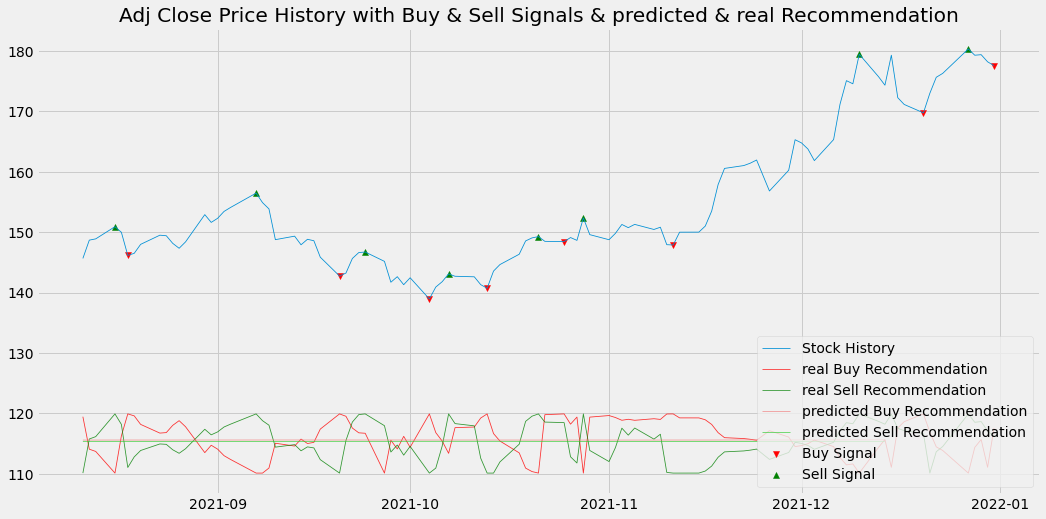

In [86]:
# Plot data
plt.figure(figsize=(16, 8))
plt.title(
    "Adj Close Price History with Buy & Sell Signals & predicted & real Recommendation")
plt.plot(df.index[-100:], df["Adj Close"][df.index[-100:]], lw=0.8,
         label="Stock History")
plt.plot(df.index[-100:], df["Rec(Buy)"][df.index[-100:]] * 10 + 110,
         lw=0.8, alpha = 0.8, label="real Buy Recommendation", c='r')
plt.plot(df.index[-100:], df["Rec(Sell)"][df.index[-100:]] * 10 + 110,
         lw=0.8, alpha = 0.8, label="real Sell Recommendation", c='g')
plt.plot(df.index[-100:], df["Rec(Buy)_pred"][df.index[-100:]] * 10 + 110,
         lw=0.8, alpha = 0.8, label="predicted Buy Recommendation", c='lightcoral')
plt.plot(df.index[-100:], df["Rec(Sell)_pred"][df.index[-100:]] * 10 + 110,
         lw=0.8, alpha = 0.8, label="predicted Sell Recommendation", c='limegreen')
plt.scatter(df.index[-100:], df['Buy'][df.index[-100:]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[-100:], df['Sell'][df.index[-100:]],
            c='g', marker="^", label="Sell Signal")
plt.legend(loc="lower right")
plt.show()

## With parameters farther away from optimized values to make network bigger

### Define x & y and create Model

In [31]:
# Create x and y; x = training and testing data (independent variable),
# y = traget (dependent) variable
x = []
y = []

# x = data of history_days days (interating forward)
# y = last value of history_days days

# index_rec_buy_sell_not_nan already was added bay creating the dataset
history_days = 70
for i in range(history_days, scaled_data.shape[0]):
    x.append(scaled_data[i - history_days:i, 0])
    y.append(
        # index_rec_buy_sell_not_nan has to be added because of index of df is used
        [df["Rec(Buy)"][df.index[i + index_rec_buy_sell_not_nan]],
         df["Rec(Sell)"][df.index[i + index_rec_buy_sell_not_nan]]]
    )
x = np.array(x)
y = np.array(y)

final_model = create_model(
    x, y,
    first_layer_type="LSTM", second_layer_type="Dense",
    neuron_percent_x=0.6, neuron_shrink=0.5, dropout_rate=0.287,
    neuron_count_min=4, layer_no_max=11,
    first_by_all_layers_ratio=0.8,
    activation_function_out=None, activation_function_rest="relu"
)
final_model.summary()

resulting_layer_no: 4
Model: "Dense_or_Dense_LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_Layer_1 (LSTM)          (None, 70, 42)            7392      
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 70, 42)            0         
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 70, 21)            5376      
_________________________________________________________________
Dropout_Layer_2 (Dropout)    (None, 70, 21)            0         
_________________________________________________________________
LSTM_Layer_3 (LSTM)          (None, 10)                1280      
_________________________________________________________________
Dropout_Layer_3 (Dropout)    (None, 10)                0         
_________________________________________________________________
Dense_Layer_4 (Dens

### Define Parameters and fit model

In [33]:
# define parameters
epochs = 50
batch_size = 128
loss_function = "mean_squared_error"
test_size = 0.2
optimizer = 'adam'
metrics = ['accuracy']

# Bootstrap
SPLITS = 2
boot = ShuffleSplit(n_splits=SPLITS, test_size=test_size)
    # test_size = 20% of x and y

# Loop through samples
current_SPLIT = 1
for train, test in boot.split(x,y):
    # Split train and test
    x_train = x[train]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = y[train]
    x_test = x[test]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = y[test]

    # check if there are nan or infinite values

    # numpy_train.isnan(ar)     # True wherever nan
    # numpy_train.isinf(ar)     # True wherever pos-inf or neg-inf

    ar_nan_x_train = np.where(np.isnan(x_train))
    ar_nan_x_test = np.where(np.isnan(x_test))

    ar_inf_x_train = np.where(np.isinf(x_train))
    ar_inf_x_test = np.where(np.isinf(x_test))

    ar_nan_y_train = np.where(np.isnan(y_train))
    ar_nan_y_test = np.where(np.isnan(y_test))

    ar_inf_y_train = np.where(np.isinf(y_train))
    ar_inf_y_test = np.where(np.isinf(y_test))

    ar_nan_inf_string_list = [
        'ar_nan_x_train', 'ar_nan_x_test', 'ar_inf_x_train', 'ar_inf_x_test',
        'ar_nan_y_train', 'ar_nan_y_test', 'ar_inf_y_train', 'ar_inf_y_test'
    ]
    i = 0
    for j, k, l in [ar_nan_x_train, ar_nan_x_test, ar_inf_x_train, ar_inf_x_test]:
        # j, k, l are the 1st, 2nd and 3rd element of list element after "in"
        # works also without [] after in
        if (j.size and k.size and l.size) == 0:
            # np_array.size == 0 checks if array is empty
            print(
                f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
                f" of SPLIT No {current_SPLIT}"
            )
        else:
            print(
                f"{ar_nan_inf_string_list[i]}:\
                \n{j, k, l}"
            )
        i += 1

    for j, k in [ar_nan_y_train, ar_nan_y_test, ar_inf_y_train, ar_inf_y_test]:
        if (j.size and k.size) == 0:
            print(f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
                f" of SPLIT No {current_SPLIT}"
            )
        else:
            print(
                f"{ar_nan_inf_string_list[i]}:\
                \n{j, k}"
            )
        i += 1
    final_model.compile(
        loss=loss_function,
        optimizer=optimizer,
        metrics=metrics
    )
    final_model.fit(
        x_train, y_train, validation_data=(x_test, y_test),
        verbose=2,
        epochs=epochs, batch_size=batch_size
    )
    current_SPLIT +=1

no nan or infinite value in ar_nan_x_train of SPLIT No 1
no nan or infinite value in ar_nan_x_test of SPLIT No 1
no nan or infinite value in ar_inf_x_train of SPLIT No 1
no nan or infinite value in ar_inf_x_test of SPLIT No 1
no nan or infinite value in ar_nan_y_train of SPLIT No 1
no nan or infinite value in ar_nan_y_test of SPLIT No 1
no nan or infinite value in ar_inf_y_train of SPLIT No 1
no nan or infinite value in ar_inf_y_test of SPLIT No 1
Epoch 1/50
35/35 - 18s - loss: 0.3591 - accuracy: 0.4987 - val_loss: 0.2913 - val_accuracy: 0.5179
Epoch 2/50
35/35 - 9s - loss: 0.2772 - accuracy: 0.4962 - val_loss: 0.1987 - val_accuracy: 0.5179
Epoch 3/50
35/35 - 9s - loss: 0.2316 - accuracy: 0.5003 - val_loss: 0.1690 - val_accuracy: 0.5179
Epoch 4/50
35/35 - 9s - loss: 0.1922 - accuracy: 0.4971 - val_loss: 0.1412 - val_accuracy: 0.5179
Epoch 5/50
35/35 - 14s - loss: 0.1689 - accuracy: 0.4804 - val_loss: 0.1191 - val_accuracy: 0.5142
Epoch 6/50
35/35 - 8s - loss: 0.1512 - accuracy: 0.5022 

Epoch 25/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.5079 - val_loss: 0.0942 - val_accuracy: 0.4665
Epoch 26/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.4942 - val_loss: 0.0941 - val_accuracy: 0.5335
Epoch 27/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.4880 - val_loss: 0.0942 - val_accuracy: 0.4665
Epoch 28/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.5079 - val_loss: 0.0943 - val_accuracy: 0.4665
Epoch 29/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.5038 - val_loss: 0.0942 - val_accuracy: 0.4665
Epoch 30/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.5074 - val_loss: 0.0942 - val_accuracy: 0.4665
Epoch 31/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.5081 - val_loss: 0.0942 - val_accuracy: 0.4665
Epoch 32/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.5097 - val_loss: 0.0941 - val_accuracy: 0.5206
Epoch 33/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.4958 - val_loss: 0.0942 - val_accuracy: 0.4665
Epoch 34/50
35/35 - 8s - loss: 0.0937 - accuracy: 0.5095 - val_loss: 0.0942 - val_accuracy: 0.4665
Epoch 35/5

### Check Usability of Model

#### Fill df with predicted Rec("Buy") & Rec("Sell")

In [34]:
# create list with all data in history_days days "rolled"
x_predict_all_data = []

j = 0
for i in range(history_days, scaled_data.shape[0]):
    x_predict_all_data.append(scaled_data[i - history_days:i, 0])
    if j < 2:
        print(
        f"x_predict_all_data[{j}]\
        \n{x_predict_all_data[-1]}\
        \n"
        )
        j += 1
# convert data to numpy array    
x_predict_all_data = np.array(x_predict_all_data)

x_predict_all_data.shape

x_predict_all_data[0]        
[0.01293657 0.01309014 0.01323591 0.01334524 0.01363417 0.01354307
 0.01333222 0.01358211 0.01349621 0.0134884  0.0131396  0.0132281
 0.01308234 0.01302247 0.01320988 0.01340511 0.01365759 0.01369143
 0.01359772 0.01363417 0.01343634 0.01373048 0.01386323 0.0136602
 0.01369143 0.01354046 0.01364718 0.0137487  0.0137051  0.01350402
 0.01362376 0.01368102 0.01433436 0.01398817 0.01423806 0.01414175
 0.01402461 0.01398817 0.01399859 0.01414435 0.01395954 0.0136654
 0.0137487  0.01396995 0.01411311 0.01402982 0.01452699 0.01491223
 0.01479249 0.01468317 0.01471961 0.01470139 0.01456864 0.01414435
 0.01456343 0.01445931 0.01420943 0.01433697 0.01412093 0.01439423
 0.01411311 0.01388145 0.01345716 0.01364718 0.01356649 0.01406626
 0.01419121 0.01395173 0.01385802 0.0139257 ]        

x_predict_all_data[1]        
[0.01309014 0.01323591 0.01334524 0.01363417 0.01354307 0.01333222
 0.01358211 0.01349621 0.0134884  0.0131396  0.0132281  0.01308234
 0.01302247 0.013

(5454, 70)

In [35]:
# reshape data for final_model input
x_predict_all_data = x_predict_all_data.reshape(
    x_predict_all_data.shape[0],
    x_predict_all_data.shape[1],
    1
)
x_predict_all_data.shape

(5454, 70, 1)

In [36]:
# predict every days Rec("Buy") & Rec("Sell") from hisory_days on
predicted_buy_and_sell_recs = final_model.predict(x_predict_all_data)
predicted_buy_and_sell_recs

array([[0.54423034, 0.5342842 ],
       [0.5442306 , 0.53428435],
       [0.54423076, 0.5342845 ],
       ...,
       [0.54581577, 0.544341  ],
       [0.54581577, 0.544341  ],
       [0.54581577, 0.544341  ]], dtype=float32)

In [37]:
predicted_buy_and_sell_recs.shape

(5454, 2)

In [38]:
df.shape

(5536, 5)

In [39]:
# fill df with predicted Rec("Buy") & Rec("Sell")
df["Rec(Buy)_pred"] = np.nan
df["Rec(Sell)_pred"] = np.nan
i = 0
for index in df.index[index_rec_buy_sell_not_nan + history_days:scaled_data.shape[0]]:
    df["Rec(Buy)_pred"][index] = predicted_buy_and_sell_recs[i][0]
    df["Rec(Sell)_pred"][index] = predicted_buy_and_sell_recs[i][1]
    i += 1
df

,Adj Close,Buy,Sell,Rec(Buy),Rec(Sell),Rec(Buy)_pred,Rec(Sell)_pred
Date,,,,,,,
2000-01-03,0.856887,NaN,0.856887,NaN,NaN,NaN,NaN
2000-01-04,0.784643,NaN,NaN,0.419690,NaN,NaN,NaN
2000-01-05,0.796125,NaN,NaN,0.363826,NaN,NaN,NaN
2000-01-06,0.727229,NaN,NaN,0.699029,NaN,NaN,NaN
2000-01-07,0.761677,NaN,NaN,0.531425,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-12-27,180.330002,NaN,180.330002,0.010000,0.990000,NaN,NaN
2021-12-28,179.289993,NaN,NaN,0.435160,0.851143,NaN,NaN
2021-12-29,179.380005,NaN,NaN,0.565765,0.863161,NaN,NaN


#### Compare predicted Rec("Buy") & Rec("Sell") with original ones

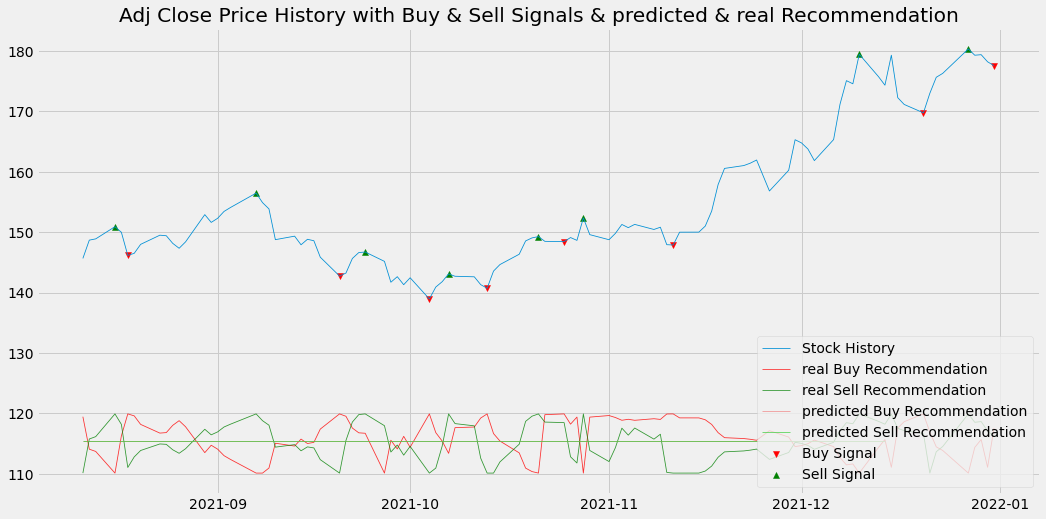

In [40]:
# Plot data
plt.figure(figsize=(16, 8))
plt.title(
    "Adj Close Price History with Buy & Sell Signals & predicted & real Recommendation")
plt.plot(df.index[-100:], df["Adj Close"][df.index[-100:]], lw=0.8,
         label="Stock History")
plt.plot(df.index[-100:], df["Rec(Buy)"][df.index[-100:]] * 10 + 110,
         lw=0.8, alpha = 0.8, label="real Buy Recommendation", c='r')
plt.plot(df.index[-100:], df["Rec(Sell)"][df.index[-100:]] * 10 + 110,
         lw=0.8, alpha = 0.8, label="real Sell Recommendation", c='g')
plt.plot(df.index[-100:], df["Rec(Buy)_pred"][df.index[-100:]] * 10 + 110,
         lw=0.8, alpha = 0.8, label="predicted Buy Recommendation", c='lightcoral')
plt.plot(df.index[-100:], df["Rec(Sell)_pred"][df.index[-100:]] * 10 + 110,
         lw=0.8, alpha = 0.8, label="predicted Sell Recommendation", c='limegreen')
plt.scatter(df.index[-100:], df['Buy'][df.index[-100:]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[-100:], df['Sell'][df.index[-100:]],
            c='g', marker="^", label="Sell Signal")
plt.legend(loc="lower right")
plt.show()

# Resumé: Model is not able to predict good buy and Sell Reccomendations out of the input data that is calculated like above

# Saved Outputs

output with n_iter and init_points = 2:\
|   iter    |  target   | dropou... | neuron... | neuron... |\
-------------------------------------------------------------\
|  1        | -0.09136  |  0.2081   |  0.7231   |  0.01011  |\
|  2        | -0.09364  |  0.1509   |  0.1553   |  0.1014   |\
|  3        | -0.09607  |  0.2175   |  0.7203   |  0.02403  |\
|  4        | -0.09532  |  0.2656   |  0.7895   |  0.1832   |\
=============================================================\
Total runtime: 0:06:00.946222\
{'target': -0.09136295158518565, 'params': {'dropout_rate': 0.20809398034658444, 'neuron_percent_x': 0.7231212485077365, 'neuron_shrink': 0.010113231069171438}}

output with n_iter and init_points = 5:\
|   iter    |  target   | dropou... | neuron... | neuron... |\
-------------------------------------------------------------\
|  1        | -0.09483  |  0.2081   |  0.7231   |  0.01011  |\
|  2        | -0.09603  |  0.1509   |  0.1553   |  0.1014   |\
|  3        | -0.09553  |  0.09294  |  0.3521   |  0.4028   |\
|  4        | -0.09526  |  0.2689   |  0.425    |  0.6884   |\
|  5        | -0.09339  |  0.102    |  0.8793   |  0.03711  |\
|  6        | -0.09392  |  0.05487  |  0.9749   |  0.02229  |\
|  7        | -0.09619  |  0.2656   |  0.7895   |  0.1832   |\
|  8        | -0.09323  |  0.003647 |  0.8373   |  0.01     |\
|  9        | -0.09508  |  0.1135   |  0.164    |  0.9478   |\
|  10       | -0.09533  |  0.3624   |  0.7313   |  0.2027   |\
=============================================================\
Total runtime: 0:44:10.557238\
{'target': -0.09323248787521618, 'params': {'dropout_rate': 0.0036473582989033264, 'neuron_percent_x': 0.8373184884179188, 'neuron_shrink': 0.01}}

# Notes

Next Idea: Do the same with stock price historys of several companies as input at once? --> Too high amout of nodes and power that is needed

see more details of bayesian optimazation at https://github.com/fmfn/BayesianOptimization